In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import transformers
import bitsandbytes as bnb
import networkx as nx
import random

random_state = 1

random.seed(random_state)

In [2]:
def euclid(list1, list2):
    return sum((p-q)**2 for p, q in zip(list1, list2)) ** .5

In [3]:
with open('df_annotations_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)
df

Document  Split  Name   Id  \
0     A2008_Commission of the European Communities v...      1  prem   A1   
1     A2008_Commission of the European Communities v...      1  prem   A2   
2     A2008_Commission of the European Communities v...      1  prem   A3   
3     A2008_Commission of the European Communities v...      1  prem   A4   
4     A2008_Commission of the European Communities v...      1  prem   A5   
...                                                 ...    ...   ...  ...   
2530                            R2021_World Duty Free v      5  prem   H7   
2531                            R2021_World Duty Free v      5  prem   H8   
2532                            R2021_World Duty Free v      5  prem   H9   
2533                            R2021_World Duty Free v      5  prem  H10   
2534                            R2021_World Duty Free v      5  conc  H11   

                                                   Text Type  \
0     must held first Article 4c CS prohibits granti...    L   
1     Also clear consistent caselaw Articles 4 CS 67...    L   
2     Court deduces Article 67 CS covers general mea...    L   
3     Court also held action taken Article 67 CS can...    L   
4     Court held particular inconceivable authors EC...    L   
...                                                 ...  ...   
2530  question matter dialogue Spanish authorities C...    F   
2531  present case action first instance WDFG compla...    F   
2532  regard General Court recalled paragraph 212 ju...    F   
2533  General Court err law concluding therefrom par...    F   
2534  Consequently sixth part WDFG’s single ground a...  NaN   

                  Scheme                                         embeddings  
0                   Rule  [-0.01507568359375, -1.73828125, 1.4287109375,...  
1     [Itpr, Prec, Rule]  [0.93017578125, -1.0146484375, 0.0575256347656...  
2           [Prec, Rule]  [0.195556640625, -1.734375, -0.1546630859375, ...  
3           [Prec, Rule]  [0.404296875, -0.2352294921875, 0.34326171875,...  
4     [Itpr, Prec, Rule]  [1.0849609375, -0.98828125, 0.39453125, 0.8774...  
...                  ...                                                ...  
2530                 NaN  [2.109375, -1.3642578125, -0.62744140625, 2.50...  
2531                 NaN  [0.880859375, -0.65966796875, -0.67626953125, ...  
2532                 NaN  [2.0234375, -1.150390625, -0.70947265625, 1.59...  
2533                 NaN  [1.6494140625, -1.5732421875, -0.857421875, 1....  
2534                 NaN  [0.853515625, -0.2034912109375, 0.038696289062...  

[2535 rows x 8 columns]

In [4]:
df_train = df[df['Split'] != 2]
df_train = df_train.dropna(subset = ['Scheme'])
df_train

Document  Split  Name     Id  \
0     A2008_Commission of the European Communities v...      1  prem     A1   
1     A2008_Commission of the European Communities v...      1  prem     A2   
2     A2008_Commission of the European Communities v...      1  prem     A3   
3     A2008_Commission of the European Communities v...      1  prem     A4   
4     A2008_Commission of the European Communities v...      1  prem     A5   
...                                                 ...    ...   ...    ...   
2520                            R2021_World Duty Free v      5  prem     G4   
2521                            R2021_World Duty Free v      5  prem     G5   
2526                            R2021_World Duty Free v      5  prem     H4   
2528                            R2021_World Duty Free v      5  prem     H6   
2529                            R2021_World Duty Free v      5  prem  H6bis   

                                                   Text    Type  \
0     must held first Article 4c CS prohibits granti...       L   
1     Also clear consistent caselaw Articles 4 CS 67...       L   
2     Court deduces Article 67 CS covers general mea...       L   
3     Court also held action taken Article 67 CS can...       L   
4     Court held particular inconceivable authors EC...       L   
...                                                 ...     ...   
2520  accordance settled caselaw appeal plea directe...       L   
2521  present case even fifth part single ground app...       L   
2526  pointed paragraph 146 appeal plea directed gro...  [F, L]   
2528  regard true decision adopts end examination Co...       L   
2529  hand General Court rightly pointed paragraph 2...       L   

                  Scheme                                         embeddings  
0                   Rule  [-0.01507568359375, -1.73828125, 1.4287109375,...  
1     [Itpr, Prec, Rule]  [0.93017578125, -1.0146484375, 0.0575256347656...  
2           [Prec, Rule]  [0.195556640625, -1.734375, -0.1546630859375, ...  
3           [Prec, Rule]  [0.404296875, -0.2352294921875, 0.34326171875,...  
4     [Itpr, Prec, Rule]  [1.0849609375, -0.98828125, 0.39453125, 0.8774...  
...                  ...                                                ...  
2520                Prec  [0.5693359375, -1.30078125, 0.0073127746582031...  
2521                Prec  [0.484130859375, -0.362548828125, -0.387695312...  
2526                Itpr  [0.34423828125, -0.83349609375, -0.04077148437...  
2528               Princ  [1.3798828125, -0.8056640625, 0.01039886474609...  
2529                Itpr  [1.4169921875, -1.34765625, -0.240234375, 1.42...  

[779 rows x 8 columns]

In [5]:
def contains_str(value, string):
    return string in value

In [6]:
df_train_Rule = df_train[df_train['Scheme'].apply(lambda x: contains_str(x, 'Rule'))]
df_train_Rule

Document  Split  Name     Id  \
0     A2008_Commission of the European Communities v...      1  prem     A1   
1     A2008_Commission of the European Communities v...      1  prem     A2   
2     A2008_Commission of the European Communities v...      1  prem     A3   
3     A2008_Commission of the European Communities v...      1  prem     A4   
4     A2008_Commission of the European Communities v...      1  prem     A5   
...                                                 ...    ...   ...    ...   
2406                            R2021_World Duty Free v      5  prem    B11   
2415                            R2021_World Duty Free v      5  prem    B17   
2416                            R2021_World Duty Free v      5  prem    B18   
2452                            R2021_World Duty Free v      5  prem    B53   
2480                            R2021_World Duty Free v      5  prem  C5bis   

                                                   Text    Type  \
0     must held first Article 4c CS prohibits granti...       L   
1     Also clear consistent caselaw Articles 4 CS 67...       L   
2     Court deduces Article 67 CS covers general mea...       L   
3     Court also held action taken Article 67 CS can...       L   
4     Court held particular inconceivable authors EC...       L   
...                                                 ...     ...   
2406  regard Court held numerous occasions objective...       L   
2415  regard Court Justice points reviewing legality...       L   
2416  Article 264 TFEU provides action well founded ...       L   
2452  Admittedly appellants rightly argued apparent ...  [F, L]   
2480  General Court established assessed facts Court...       L   

                  Scheme                                         embeddings  
0                   Rule  [-0.01507568359375, -1.73828125, 1.4287109375,...  
1     [Itpr, Prec, Rule]  [0.93017578125, -1.0146484375, 0.0575256347656...  
2           [Prec, Rule]  [0.195556640625, -1.734375, -0.1546630859375, ...  
3           [Prec, Rule]  [0.404296875, -0.2352294921875, 0.34326171875,...  
4     [Itpr, Prec, Rule]  [1.0849609375, -0.98828125, 0.39453125, 0.8774...  
...                  ...                                                ...  
2406        [Prec, Rule]  [0.91455078125, -0.69482421875, -0.76904296875...  
2415        [Prec, Rule]  [1.5009765625, -1.8251953125, -0.474853515625,...  
2416                Rule  [0.237060546875, -1.1904296875, 1.1767578125, ...  
2452        [Prec, Rule]  [0.431884765625, -0.5126953125, 0.21923828125,...  
2480        [Prec, Rule]  [0.8046875, -1.4853515625, -1.005859375, 1.484...  

[271 rows x 8 columns]

In [7]:
df_train_Itpr = df_train[df_train['Scheme'].apply(lambda x: contains_str(x, 'Itpr'))]
df_train_Itpr

Document  Split  Name     Id  \
1     A2008_Commission of the European Communities v...      1  prem     A2   
4     A2008_Commission of the European Communities v...      1  prem     A5   
7     A2008_Commission of the European Communities v...      1  prem     A8   
8     A2008_Commission of the European Communities v...      1  prem     A9   
9     A2008_Commission of the European Communities v...      1  prem    A10   
...                                                 ...    ...   ...    ...   
2499                            R2021_World Duty Free v      5  prem    D14   
2507                            R2021_World Duty Free v      5  prem     E2   
2508                            R2021_World Duty Free v      5  prem     E3   
2526                            R2021_World Duty Free v      5  prem     H4   
2529                            R2021_World Duty Free v      5  prem  H6bis   

                                                   Text    Type  \
1     Also clear consistent caselaw Articles 4 CS 67...       L   
4     Court held particular inconceivable authors EC...       L   
7     Finally State aid granted undertaking falling ...       L   
8     light foregoing must consequently held Article...       L   
9     Contrary German Government claims interpretati...  [F, L]   
...                                                 ...     ...   
2499  regard must borne mind accordance caselaw ment...       L   
2507  party entitled put forward pleas arguments ari...       L   
2508  appellants therefore entitled call question fi...       L   
2526  pointed paragraph 146 appeal plea directed gro...  [F, L]   
2529  hand General Court rightly pointed paragraph 2...       L   

                  Scheme                                         embeddings  
1     [Itpr, Prec, Rule]  [0.93017578125, -1.0146484375, 0.0575256347656...  
4     [Itpr, Prec, Rule]  [1.0849609375, -0.98828125, 0.39453125, 0.8774...  
7                   Itpr  [-0.6279296875, -1.154296875, 1.5390625, 0.588...  
8           [Itpr, Rule]  [0.65283203125, -1.828125, 0.75, 1.142578125, ...  
9           [Itpr, Rule]  [0.460693359375, -0.8759765625, -0.6455078125,...  
...                  ...                                                ...  
2499        [Itpr, Prec]  [1.9736328125, -1.0966796875, 0.06695556640625...  
2507                Itpr  [0.4736328125, -0.90234375, 0.394287109375, 2....  
2508                Itpr  [1.095703125, -1.23828125, -0.1693115234375, 1...  
2526                Itpr  [0.34423828125, -0.83349609375, -0.04077148437...  
2529                Itpr  [1.4169921875, -1.34765625, -0.240234375, 1.42...  

[267 rows x 8 columns]

In [8]:
df_train_Aut = df_train[df_train['Scheme'].apply(lambda x: contains_str(x, 'Aut'))]
df_train_Aut

Document  Split  Name  \
316      A2013_European Commission v Ireland and Others      3  prem   
402   A2016_European Commission v Aer Lingus Ltd and...      3  prem   
435   A2016_European Commission v Aer Lingus Ltd and...      3  prem   
520         A2016_European_Commission_v_World_Duty_Free      4  prem   
524         A2016_European_Commission_v_World_Duty_Free      4  prem   
569     A2017_European Commission v Italian Republic_DT      4  prem   
609     A2017_European Commission v Italian Republic_DT      4  prem   
755             A2018_Dirk Andres v European Commission      5  prem   
798             A2018_Dirk Andres v European Commission      5  prem   
809             A2018_Dirk Andres v European Commission      5  prem   
820   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
832   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
860   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
880   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
887   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
910   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
971   R2000_French Republic v Ladbroke Racing Ltd an...      1  prem   
994   R2000_French Republic v Ladbroke Racing Ltd an...      1  prem   
1000  R2000_French Republic v Ladbroke Racing Ltd an...      1  prem   
1433      R2011_France Télécom SA v European Commission      5  prem   
1467      R2011_France Télécom SA v European Commission      5  prem   
1617          R2013_Telefónica SA v European Commission      3  prem   
1624          R2013_Telefónica SA v European Commission      3  prem   
1628          R2013_Telefónica SA v European Commission      3  prem   
1629          R2013_Telefónica SA v European Commission      3  prem   
1654  R2015_European Commission v MOL Magyar Olaj- é...      3  prem   
1663  R2015_European Commission v MOL Magyar Olaj- é...      3  prem   
1680  R2015_European Commission v MOL Magyar Olaj- é...      3  prem   
1691  R2015_European Commission v MOL Magyar Olaj- é...      3  prem   
1757      R2016_DTS Distribuidora de Televisión Digital      4  prem   
1791      R2016_DTS Distribuidora de Televisión Digital      4  prem   
1840      R2016_European Commission v Hansestadt Lübeck      4  prem   
1844      R2016_European Commission v Hansestadt Lübeck      4  prem   
1854      R2016_European Commission v Hansestadt Lübeck      4  prem   
1923      R2016_Hellenic Republic v European Commission      4  prem   
2027                 R2016_Orange v European Commission      4  prem   
2052                 R2016_Orange v European Commission      4  prem   
2067                 R2016_Orange v European Commission      4  prem   
2069                 R2016_Orange v European Commission      4  prem   
2072                 R2016_Orange v European Commission      4  prem   
2073                 R2016_Orange v European Commission      4  prem   
2172  R2017_Viasat Broadcasting UK Ltd v European Co...      3  prem   
2182  R2017_Viasat Broadcasting UK Ltd v European Co...      3  prem   
2246  R2021_Prosegur Compañía de Seguridad SA, estab...      5  prem   
2254  R2021_Prosegur Compañía de Seguridad SA, estab...      5  prem   
2291  R2021_Prosegur Compañía de Seguridad SA, estab...      5  prem   
2394                            R2021_World Duty Free v      5  prem   
2402                            R2021_World Duty Free v      5  prem   
2438                            R2021_World Duty Free v      5  prem   

               Id                                               Text    Type  \
316            A9  Yet submitted Commission stated Advocate Gener...       F   
402            A6  Advocate General observed essence point 41 Opi...       F   
435           D11  follows Advocate General observed essence poin...       L   
520            B1  regards caselaw relating aid exports relied co...  [F, L]   
524            B5  observed essence Advocate G

In [9]:
df_train_Class = df_train[df_train['Scheme'].apply(lambda x: contains_str(x, 'Class'))]
df_train_Class

Document  Split  Name  \
120   A2009_Commission of the European Communities v...      1  prem   
121   A2009_Commission of the European Communities v...      1  prem   
463         A2016_European_Commission_v_World_Duty_Free      4  prem   
464         A2016_European_Commission_v_World_Duty_Free      4  prem   
465         A2016_European_Commission_v_World_Duty_Free      4  prem   
467         A2016_European_Commission_v_World_Duty_Free      4  prem   
612         A2017_European Commission v TV2_Danmark A_S      5  prem   
613         A2017_European Commission v TV2_Danmark A_S      5  prem   
614         A2017_European Commission v TV2_Danmark A_S      5  prem   
615         A2017_European Commission v TV2_Danmark A_S      5  prem   
616         A2017_European Commission v TV2_Danmark A_S      5  prem   
617         A2017_European Commission v TV2_Danmark A_S      5  prem   
653                            A2018_Commission v Spain      5  prem   
654                            A2018_Commission v Spain      5  prem   
655                            A2018_Commission v Spain      5  prem   
656                            A2018_Commission v Spain      5  prem   
657                            A2018_Commission v Spain      5  prem   
658                            A2018_Commission v Spain      5  prem   
659                            A2018_Commission v Spain      5  prem   
780             A2018_Dirk Andres v European Commission      5  prem   
781             A2018_Dirk Andres v European Commission      5  prem   
782             A2018_Dirk Andres v European Commission      5  prem   
783             A2018_Dirk Andres v European Commission      5  prem   
784             A2018_Dirk Andres v European Commission      5  prem   
785             A2018_Dirk Andres v European Commission      5  prem   
789             A2018_Dirk Andres v European Commission      5  prem   
791             A2018_Dirk Andres v European Commission      5  prem   
828   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
833   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
844   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
912   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
919   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
920   A2018_Scuola Elementare Maria Montessori Srl v...      3  prem   
930   R1997_Tiercé Ladbroke SA v Commission of the E...      1  prem   
942   R1997_Tiercé Ladbroke SA v Commission of the E...      1  prem   
1654  R2015_European Commission v MOL Magyar Olaj- é...      3  prem   
1820      R2016_European Commission v Hansestadt Lübeck      4  prem   
1821      R2016_European Commission v Hansestadt Lübeck      4  prem   
1822      R2016_European Commission v Hansestadt Lübeck      4  prem   
1823      R2016_European Commission v Hansestadt Lübeck      4  prem   
1824      R2016_European Commission v Hansestadt Lübeck      4  prem   
1825      R2016_European Commission v Hansestadt Lübeck      4  prem   
2148  R2017_Viasat Broadcasting UK Ltd v European Co...      3  prem   
2149  R2017_Viasat Broadcasting UK Ltd v European Co...      3  prem   
2150  R2017_Viasat Broadcasting UK Ltd v European Co...      3  prem   
2155  R2017_Viasat Broadcasting UK Ltd v European Co...      3  prem   
2156  R2017_Viasat Broadcasting UK Ltd v European Co...      3  prem   
2157  R2017_Viasat Broadcasting UK Ltd v European Co...      3  prem   
2158  R2017_Viasat Broadcasting UK Ltd v European Co...      3  prem   
2159  R2017_Viasat Broadcasting UK Ltd v European Co...      3  prem   
2191        R2021_FVE Holýšov I and Others v Commission      5  prem   

                Id                                               Text    Type  \
120             A2  relation first condition set therein settled c...       L   
121             A3  present case Court First Instance held paragra...       F   
463             A1  First must recalled according Court’s s

In [10]:
df_train_Prec = df_train[df_train['Scheme'].apply(lambda x: contains_str(x, 'Prec'))]
df_train_Prec

Document  Split  Name   Id  \
1     A2008_Commission of the European Communities v...      1  prem   A2   
2     A2008_Commission of the European Communities v...      1  prem   A3   
3     A2008_Commission of the European Communities v...      1  prem   A4   
4     A2008_Commission of the European Communities v...      1  prem   A5   
5     A2008_Commission of the European Communities v...      1  prem   A6   
...                                                 ...    ...   ...  ...   
2502                            R2021_World Duty Free v      5  prem  D16   
2514                            R2021_World Duty Free v      5  prem   F2   
2515                            R2021_World Duty Free v      5  prem   F3   
2520                            R2021_World Duty Free v      5  prem   G4   
2521                            R2021_World Duty Free v      5  prem   G5   

                                                   Text    Type  \
1     Also clear consistent caselaw Articles 4 CS 67...       L   
2     Court deduces Article 67 CS covers general mea...       L   
3     Court also held action taken Article 67 CS can...       L   
4     Court held particular inconceivable authors EC...       L   
5     Court also held first indent Article 672 CS de...       L   
...                                                 ...     ...   
2502  Court Justice held measure measure issue desig...       L   
2514  arguments cannot however upheld since apparent...  [F, L]   
2515  stage Member State thus called demonstrate dif...       L   
2520  accordance settled caselaw appeal plea directe...       L   
2521  present case even fifth part single ground app...       L   

                  Scheme                                         embeddings  
1     [Itpr, Prec, Rule]  [0.93017578125, -1.0146484375, 0.0575256347656...  
2           [Prec, Rule]  [0.195556640625, -1.734375, -0.1546630859375, ...  
3           [Prec, Rule]  [0.404296875, -0.2352294921875, 0.34326171875,...  
4     [Itpr, Prec, Rule]  [1.0849609375, -0.98828125, 0.39453125, 0.8774...  
5           [Prec, Rule]  [0.05633544921875, -1.2216796875, 0.4230957031...  
...                  ...                                                ...  
2502                Prec  [1.08203125, -1.0966796875, -0.65283203125, 0....  
2514       [Prec, Princ]  [0.37890625, 0.330322265625, 0.5732421875, 0.6...  
2515       [Prec, Princ]  [1.11328125, -1.2724609375, 0.088134765625, 0....  
2520                Prec  [0.5693359375, -1.30078125, 0.0073127746582031...  
2521                Prec  [0.484130859375, -0.362548828125, -0.387695312...  

[421 rows x 8 columns]

In [11]:
df_test = df[df['Split'] == 2]
df_test = df_test.dropna(subset = ['Scheme'])
df_test

Document  Split  Name   Id  \
172   A2010_NDSHT Nya Destination Stockholm Hotell &...      2  prem   A2   
177   A2010_NDSHT Nya Destination Stockholm Hotell &...      2  prem   B2   
178   A2010_NDSHT Nya Destination Stockholm Hotell &...      2  prem   B3   
179   A2010_NDSHT Nya Destination Stockholm Hotell &...      2  prem   B4   
180   A2010_NDSHT Nya Destination Stockholm Hotell &...      2  prem   B5   
...                                                 ...    ...   ...  ...   
2123       R2017_European Commission v Frucona Košice a      2  prem  D13   
2124       R2017_European Commission v Frucona Košice a      2  prem  D14   
2126       R2017_European Commission v Frucona Košice a      2  prem  D16   
2130       R2017_European Commission v Frucona Košice a      2  prem  D20   
2135       R2017_European Commission v Frucona Košice a      2  prem  D25   

                                                   Text    Type        Scheme  \
172   regard must observed follows Article 58 Statut...       L  [Prec, Rule]   
177   regard Court repeatedly held action annulment ...       L  [Prec, Rule]   
178   follows also settled caselaw concerning admiss...       L          Prec   
179   contrast form act decision adopted principle i...       L          Itpr   
180   therefore principle irrelevant classification ...       L          Itpr   
...                                                 ...     ...           ...   
2123  connection also borne mind lawfulness decision...       L          Prec   
2124  However information ‘available’ Commission inc...       L  [Itpr, Prec]   
2126  Paragraphs 180 213 235 judgment appeal Commiss...       F          Itpr   
2130  Advocate General noted paragraphs 125 131 Opin...       F           Aut   
2135  considerations far concern information normall...  [F, L]          Prec   

                                             embeddings  
172   [0.5068359375, -1.6494140625, -0.43408203125, ...  
177   [1.076171875, -0.91064453125, -0.53271484375, ...  
178   [0.90185546875, -1.087890625, -0.5048828125, 1...  
179   [0.92431640625, -0.471435546875, -0.3063964843...  
180   [0.7216796875, -0.82373046875, 0.39501953125, ...  
...                                                 ...  
2123  [0.83251953125, -0.8701171875, -0.16796875, 1....  
2124  [1.4931640625, -1.1728515625, -0.70751953125, ...  
2126  [0.55419921875, -1.5498046875, -0.5234375, 1.4...  
2130  [1.2119140625, -1.08984375, 0.0924072265625, -...  
2135  [0.62255859375, -1.1865234375, -0.74951171875,...  

[129 rows x 8 columns]

In [12]:
device = torch.device('cuda')
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [13]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16,
                  "quantization_config": {"load_in_4bit": True}},
    device_map="cuda:0"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [14]:
Rule_training_graph = pickle.load(open('task3_Rule_.01.pickle', 'rb'))
Itpr_training_graph = pickle.load(open('task3_Itpr_.01.pickle', 'rb'))
Aut_training_graph = pickle.load(open('task3_Aut_.01.pickle', 'rb'))
Prec_training_graph = pickle.load(open('task3_Prec_.01.pickle', 'rb'))
Class_training_graph = pickle.load(open('task3_Class_.01.pickle', 'rb'))


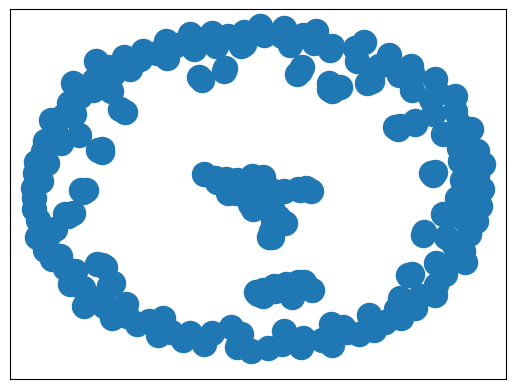

In [15]:
nx.draw_networkx(Rule_training_graph, with_labels = False)

In [16]:
average_degs = sum([Rule_training_graph.degree[i] for i in Rule_training_graph])/len(Rule_training_graph), sum([Itpr_training_graph.degree[i] for i in Itpr_training_graph])/len(Itpr_training_graph)
average_degs

(2.7011070110701105, 2.6741573033707864)

In [17]:
def test(template, nexamples):

    count = 0
    autTP = 0
    autFN = 0
    autFP = 0
    classTP = 0
    classFN = 0
    classFP = 0
    itprTP = 0
    itprFN = 0
    itprFP = 0
    precTP = 0
    precFN = 0
    precFP = 0
    #princTP = 0
    #princFN = 0
    #princFP = 0
    ruleTP = 0
    ruleFN = 0
    ruleFP = 0

    for i in range(len(df_test)):

        Rule_subgraph_radius = 39.97              #SET MANUALLY, on the training set, on average these yield a subgraph of size (N*25)**0.5
        Itpr_subgraph_radius = 41.02
        Aut_subgraph_radius = 38.51
        Class_subgraph_radius = 46.86
        Prec_subgraph_radius = 34.13

        query = 'Text: '+ df_test.iloc[i]['Text']+'\n'+'Answer: '

        Rule_test_graph = Rule_training_graph.copy()     
        Itpr_test_graph = Itpr_training_graph.copy()
        Aut_test_graph = Aut_training_graph.copy()
        Class_test_graph = Class_training_graph.copy()
        Prec_test_graph = Prec_training_graph.copy()


        for j in range(len(Rule_training_graph)):
            if euclid(df_train_Rule.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > Rule_subgraph_radius:
                Rule_test_graph.remove_node(j)


        while(len(Rule_test_graph) < (nexamples+4)//5):     #If the subgraph doesn't have enough nodes, increment the radius
            Rule_subgraph_radius *= 1.1
            Rule_test_graph = Rule_training_graph.copy()
            for j in range(len(Rule_training_graph)):
                if euclid(df_train_Rule.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > Rule_subgraph_radius:
                    Rule_test_graph.remove_node(j)
            #print(subgraph_radius)

        for j in range(len(Itpr_training_graph)):
            if euclid(df_train_Itpr.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > Itpr_subgraph_radius:
                Itpr_test_graph.remove_node(j)


        while(len(Itpr_test_graph) < (nexamples+4)//5):     #If the subgraph doesn't have enough nodes, increment the radius
            Itpr_subgraph_radius *= 1.1
            Itpr_test_graph = Itpr_training_graph.copy()
            for j in range(len(Itpr_training_graph)):
                if euclid(df_train_Itpr.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > Itpr_subgraph_radius:
                    Itpr_test_graph.remove_node(j)
            #print(subgraph_radius)

        for j in range(len(Aut_training_graph)):
            if euclid(df_train_Aut.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > Aut_subgraph_radius:
                Aut_test_graph.remove_node(j)


        while(len(Aut_test_graph) < (nexamples+4)//5):     #If the subgraph doesn't have enough nodes, increment the radius
            Aut_subgraph_radius *= 1.1
            Aut_test_graph = Aut_training_graph.copy()
            for j in range(len(Aut_training_graph)):
                if euclid(df_train_Aut.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > Aut_subgraph_radius:
                    Aut_test_graph.remove_node(j)
            #print(subgraph_radius)

        for j in range(len(Class_training_graph)):
            if euclid(df_train_Class.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > Class_subgraph_radius:
                Class_test_graph.remove_node(j)


        while(len(Class_test_graph) < (nexamples+4)//5):     #If the subgraph doesn't have enough nodes, increment the radius
            Class_subgraph_radius *= 1.1
            Class_test_graph = Class_training_graph.copy()
            for j in range(len(Class_training_graph)):
                if euclid(df_train_Class.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > Class_subgraph_radius:
                    Class_test_graph.remove_node(j)

        for j in range(len(Prec_training_graph)):
            if euclid(df_train_Prec.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > Prec_subgraph_radius:
                Prec_test_graph.remove_node(j)


        while(len(Prec_test_graph) < (nexamples+4)//5):     #If the subgraph doesn't have enough nodes, increment the radius
            Prec_subgraph_radius *= 1.1
            Prec_test_graph = Prec_training_graph.copy()
            for j in range(len(Prec_training_graph)):
                if euclid(df_train_Prec.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > Prec_subgraph_radius:
                    Prec_test_graph.remove_node(j)






        
        Rule_selected_nodes = []
        Itpr_selected_nodes = []
        Aut_selected_nodes = []
        Prec_selected_nodes = []
        Class_selected_nodes = []
        Rule_communities = nx.community.louvain_communities(Rule_test_graph, seed = random_state)
        Rule_sorted_communities = sorted(Rule_communities, key = lambda x: len(x), reverse = True)
        Itpr_communities = nx.community.louvain_communities(Itpr_test_graph, seed = random_state)
        Itpr_sorted_communities = sorted(Itpr_communities, key = lambda x: len(x), reverse = True)
        Aut_communities = nx.community.louvain_communities(Aut_test_graph, seed = random_state)
        Aut_sorted_communities = sorted(Aut_communities, key = lambda x: len(x), reverse = True)
        Prec_communities = nx.community.louvain_communities(Prec_test_graph, seed = random_state)
        Prec_sorted_communities = sorted(Prec_communities, key = lambda x: len(x), reverse = True)
        Class_communities = nx.community.louvain_communities(Class_test_graph, seed = random_state)
        Class_sorted_communities = sorted(Class_communities, key = lambda x: len(x), reverse = True)
        #print(sorted_communities)
        #print(len(sorted_communities))



        if len(Rule_sorted_communities) >= (nexamples+4)//5:    #If there are enough communities:
            for l in range((nexamples+4)//5):
                Rule_subgraph = Rule_test_graph.subgraph(Rule_sorted_communities[l])
                Rule_selected_nodes.append(sorted(nx.pagerank(Rule_subgraph).items(), key=lambda kv: kv[1], reverse = True )[0][0])
                #print(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True ))
        else:                                       #If there are less communities than nodes to choose:
            numberofelements = 2
            while len(Rule_selected_nodes) < (nexamples+4) //5:
                Rule_selected_nodes = []
                for element in Rule_sorted_communities:
                    Rule_subgraph = Rule_test_graph.subgraph(element)
                    Rule_selected_nodes += [foo[0] for foo in sorted(nx.pagerank(Rule_subgraph).items(), key=lambda kv: kv[1], reverse = True )][:numberofelements]
                    numberofelements += 1

        if len(Itpr_sorted_communities) >= (nexamples+4)//5:    #If there are enough communities:
            for l in range((nexamples+4)//5):
                Itpr_subgraph = Itpr_test_graph.subgraph(Itpr_sorted_communities[l])
                Itpr_selected_nodes.append(sorted(nx.pagerank(Itpr_subgraph).items(), key=lambda kv: kv[1], reverse = True )[0][0])
                #print(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True ))
        else:                                       #If there are less communities than nodes to choose:
            numberofelements = 2
            while len(Itpr_selected_nodes) < (nexamples+4) //5:
                Itpr_selected_nodes = []
                for element in Itpr_sorted_communities:
                    Itpr_subgraph = Itpr_test_graph.subgraph(element)
                    Itpr_selected_nodes += [foo[0] for foo in sorted(nx.pagerank(Itpr_subgraph).items(), key=lambda kv: kv[1], reverse = True )][:numberofelements]
                    numberofelements += 1
            #print(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True ))
        
        if len(Aut_sorted_communities) >= (nexamples+4)//5:    #If there are enough communities:
            for l in range((nexamples+4)//5):
                Aut_subgraph = Aut_test_graph.subgraph(Aut_sorted_communities[l])
                Aut_selected_nodes.append(sorted(nx.pagerank(Aut_subgraph).items(), key=lambda kv: kv[1], reverse = True )[0][0])
                #print(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True ))
        else:                                       #If there are less communities than nodes to choose:
            numberofelements = 2
            while len(Aut_selected_nodes) < (nexamples+4) //5:
                Aut_selected_nodes = []
                for element in Aut_sorted_communities:
                    Aut_subgraph = Aut_test_graph.subgraph(element)
                    Aut_selected_nodes += [foo[0] for foo in sorted(nx.pagerank(Aut_subgraph).items(), key=lambda kv: kv[1], reverse = True )][:numberofelements]
                    numberofelements += 1

        if len(Prec_sorted_communities) >= (nexamples+4)//5:    #If there are enough communities:
            for l in range((nexamples+4)//5):
                Prec_subgraph = Prec_test_graph.subgraph(Prec_sorted_communities[l])
                Prec_selected_nodes.append(sorted(nx.pagerank(Prec_subgraph).items(), key=lambda kv: kv[1], reverse = True )[0][0])
                #print(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True ))
        else:                                       #If there are less communities than nodes to choose:
            numberofelements = 2
            while len(Prec_selected_nodes) < (nexamples+4) //5:
                Prec_selected_nodes = []
                for element in Prec_sorted_communities:
                    Prec_subgraph = Prec_test_graph.subgraph(element)
                    Prec_selected_nodes += [foo[0] for foo in sorted(nx.pagerank(Prec_subgraph).items(), key=lambda kv: kv[1], reverse = True )][:numberofelements]
                    numberofelements += 1

        if len(Class_sorted_communities) >= (nexamples+4)//5:    #If there are enough communities:
            for l in range((nexamples+4)//5):
                Class_subgraph = Class_test_graph.subgraph(Class_sorted_communities[l])
                Class_selected_nodes.append(sorted(nx.pagerank(Class_subgraph).items(), key=lambda kv: kv[1], reverse = True )[0][0])
                #print(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True ))
        else:                                       #If there are less communities than nodes to choose:
            numberofelements = 2
            while len(Class_selected_nodes) < (nexamples+4) //5:
                Class_selected_nodes = []
                for element in Class_sorted_communities:
                    Class_subgraph = Class_test_graph.subgraph(element)
                    Class_selected_nodes += [foo[0] for foo in sorted(nx.pagerank(Class_subgraph).items(), key=lambda kv: kv[1], reverse = True )][:numberofelements]
                    numberofelements += 1
        



        Rule_selected_nodes = Rule_selected_nodes[:(nexamples+4)//5]     #The final chosen demonstrations
        Itpr_selected_nodes = Itpr_selected_nodes[:(nexamples+4)//5]
        Class_selected_nodes = Class_selected_nodes[:(nexamples+4)//5]
        Prec_selected_nodes = Prec_selected_nodes[:(nexamples+4)//5]
        Aut_selected_nodes = Aut_selected_nodes[:(nexamples+4)//5]
        #print('Selected Nodes:', Rule_selected_nodes)

        examples_text = []
        
        for el in list(range((nexamples+4)//5)):
            examples_text.append('Text: '+ df_train_Rule.iloc[Rule_selected_nodes[el]]['Text'] + '\n' + 'Answer: '+ str(df_train_Rule.iloc[Rule_selected_nodes[el]]['Scheme'])+'\n\n')
            examples_text.append('Text: '+ df_train_Itpr.iloc[Itpr_selected_nodes[el]]['Text'] + '\n' + 'Answer: '+ str(df_train_Itpr.iloc[Itpr_selected_nodes[el]]['Scheme'])+'\n\n')
            examples_text.append('Text: '+ df_train_Aut.iloc[Aut_selected_nodes[el]]['Text'] + '\n' + 'Answer: '+ str(df_train_Aut.iloc[Aut_selected_nodes[el]]['Scheme'])+'\n\n')
            examples_text.append('Text: '+ df_train_Prec.iloc[Prec_selected_nodes[el]]['Text'] + '\n' + 'Answer: '+ str(df_train_Prec.iloc[Prec_selected_nodes[el]]['Scheme'])+'\n\n')
            examples_text.append('Text: '+ df_train_Class.iloc[Class_selected_nodes[el]]['Text'] + '\n' + 'Answer: '+ str(df_train_Class.iloc[Class_selected_nodes[el]]['Scheme'])+'\n\n')

        random.shuffle(examples_text)

        examples_text = examples_text[:nexamples]

        text_examples = ''      #Building text examples

        for el in examples_text:
            text_examples += el
        
        print('query:\n'+ query,'\n')
        print('retrieved examples:\n\n'+ text_examples,'\n\n')

        messages = [{'role': 'system', 'content': template},{"role": "user", "content": text_examples},{"role": "user", "content": query}]

        outputs = pipeline(
            messages,
            max_new_tokens=10,
            do_sample = False
        )
        final_output = outputs[0]['generated_text'][-1]['content']
        print('LLM output:', final_output)
        print('ground truth:', df_test.iloc[i]['Scheme'])
        print(200*'-')

        if 'Aut' in final_output and 'Aut' in df_test.iloc[i]['Scheme']:
            autTP += 1
        if 'Aut' in final_output and 'Aut' not in df_test.iloc[i]['Scheme']:
            autFP += 1
        if 'Aut' not in final_output and 'Aut' in df_test.iloc[i]['Scheme']:
            autFN += 1
        
        if 'Class' in final_output and 'Class' in df_test.iloc[i]['Scheme']:
            classTP += 1
        if 'Class' in final_output and 'Class' not in df_test.iloc[i]['Scheme']:
            classFP += 1
        if 'Class' not in final_output and 'Class' in df_test.iloc[i]['Scheme']:
            classFN += 1

        if 'Itpr' in final_output and 'Itpr' in df_test.iloc[i]['Scheme']:
            itprTP += 1
        if 'Itpr' in final_output and 'Itpr' not in df_test.iloc[i]['Scheme']:
            itprFP += 1
        if 'Itpr' not in final_output and 'Itpr' in df_test.iloc[i]['Scheme']:
            itprFN += 1

        if 'Prec' in final_output and 'Prec' in df_test.iloc[i]['Scheme']:
            precTP += 1
        if 'Prec' in final_output and 'Prec' not in df_test.iloc[i]['Scheme']:
            precFP += 1
        if 'Prec' not in final_output and 'Prec' in df_test.iloc[i]['Scheme']:
            precFN += 1

        if 'Rule' in final_output and 'Rule' in df_test.iloc[i]['Scheme']:
            ruleTP += 1
        if 'Rule' in final_output and 'Rule' not in df_test.iloc[i]['Scheme']:
            ruleFP += 1
        if 'Rule' not in final_output and 'Rule' in df_test.iloc[i]['Scheme']:
            ruleFN += 1

    if autTP == 0:
        autF1 = 0
    else:
        autPREC = autTP/(autTP+autFP)
        autREC = autTP/(autTP+autFN)
        autF1 = 2/((1/autPREC)+(1/autREC))

    if classTP == 0:
        classF1 = 0
    else:
        classPREC = classTP/(classTP+classFP)
        classREC = classTP/(classTP+classFN)
        classF1 = 2/((1/classPREC)+(1/classREC))

    if itprTP == 0:
        itprF1 = 0
    else:
        itprPREC = itprTP/(itprTP+itprFP)
        itprREC = itprTP/(itprTP+itprFN)
        itprF1 = 2/((1/itprPREC)+(1/itprREC))

    if precTP == 0:
        precF1 = 0
    else:
        precPREC = precTP/(precTP+precFP)
        precREC = precTP/(precTP+precFN)
        precF1 = 2/((1/precPREC)+(1/precREC))

    if ruleTP == 0:
        ruleF1 = 0
    else:
        rulePREC = ruleTP/(ruleTP+ruleFP)
        ruleREC = ruleTP/(ruleTP+ruleFN)
        ruleF1 = 2/((1/rulePREC)+(1/ruleREC))

    print('Authoritative F1:', autF1)
    print('Verbal Classification F1:', classF1)
    print('Interpretation F1:', itprF1)
    print('Precedent F1:', precF1)
    print('Rule F1:', ruleF1)
    print()


    print('macro F1:', (autF1 + classF1 + itprF1 + precF1 + ruleF1)/5)
    print('macro F1 (reliable):', (autF1 + precF1 + ruleF1)/3)


In [18]:
template = '''Classify the following legal premise as one or more of the following argumentative schemes: Rule, Prec, Class, Itpr, Princ. Rule: whether there is an explicit or implicit reference to an article of law or citation of the text of a certain article. Prec: whether there is a reference to a previous ruling of the Supreme Court or the Court of Justice of the European Union. Class: if there is a definition of a legal concept or its constituent elements. Itpr: if there is reference to one of the interpretative criteria contained in Article 12 of the prelegislations (literal, teleological, psychological, systematic) to the Civil Code. Princ: if there is a reference to a general principle of law (e.g. principle of proportionality). The expected output is a list with all applicable labels. For example: ['Prec', 'Princ', 'Rule']. Only reply with the list of labels.'''

In [19]:
test(template, 5)

C:\Users\alfio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\alfio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard must observed follows Article 58 Statute Court Justice conjunction Article 1132 Rules Procedure Court Justice appeal appellant may put forward relevant argument provided subjectmatter proceedings General Court changed appeal Case C‑22905 P PKK KNK v Council 2007 ECR I‑439 paragraph 66 Case C‑806 P Herrero Romeu v Commission 2007 ECR I‑10333 paragraph 32
Answer:  

retrieved examples:

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 clear appellant’s arguments include detailed specific criticism grounds judgment appeal seek large extent challenge observance General Court limits detailed rules governing exercise review could event raised
Answer: Aut

Text: Commission challenges view line argument set paragraph 13 present judgment pointed case interpretation national law General Court Court Justice jurisdiction appeal determine whether law distorted distortion must obvious do

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard Court repeatedly held action annulment purposes Article 230 EC must available acts adopted institutions whatever nature form intended legal effects capable affecting interests applicant bringing distinct change legal position see inter alia Athinaïki Techniki v Commission paragraph 29 caselaw cited Case C‑36208 P Internationaler Hilfsfonds v Commission 2010 ECR I‑0000 paragraph 51
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: regards caselaw relating aid exports relied contested de

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: follows also settled caselaw concerning admissibility actions annulment necessary look actual substance acts challenged order classify see particular Case 6081 IBM v Commission 1981 ECR 2639 paragraph 9 Case C‑14796 Netherlands v Commission 2000 ECR I‑4723 paragraph 27
Answer:  

retrieved examples:

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: according Court’s settled caselaw fact number undertakings able claim entitlement national measure large undertakings belong various economic sectors sufficient call question selective nature measure therefore rule classification State aid see inter alia judgments 13 February 2003 Spain v Commission C‑40900 EUC200392 paragraph 48 8 September 2011 Commission v Netherlands C‑27908 P EUC2011551 paragraph 50
Answer: Prec

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EU

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: contrast form act decision adopted principle irrelevant right challenge acts decisions way action annulment
Answer:  

retrieved examples:

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: Commission could whenever examined individual aid measure go back decision approving aid scheme already involved examination light Article 92 Treaty
Answer: Rule

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: follows reading grounds measure issue judgment take form tax advantage derogated ordinary tax system rather involved application ‘general’ tax scheme based criteria also general
Answer: Prec

 


LLM output: ['Prec']
ground truth: Itpr
-------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore principle irrelevant classification act question whether satisfies certain formal requirements namely particular duly identified author mentions provisions providing legal basis
Answer:  

retrieved examples:

Text: event must borne mind mere fact measure issue general nature may priori benefit undertakings subject corporate tax mean cannot selective
Answer: Itpr

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: apparent paragraphs 46 52 observed essence Advocate General point 76 Opinion existing aid altered breach compatibility conditions imposed Commission Council longer regarded authorised result loses status existing aid entirety
Answer: ['Aut', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore irrelevant act may described ‘decision’ refer Article 42 3 4 Regulation 6591999
Answer:  

retrieved examples:

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: must recalled fact taxpayers satisfying conditions application measure benefit measure cannot make selective measure judgment 29 March 2012 3M Italia C‑41710 EUC2012184 paragraph 42
Answer: Prec

Text: finding follows examination wording context aim Article 1c Regulation 6591999
Answer: ['Itpr', 'Rule']

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

 


LLM output: ['Itpr', 'Rule']
ground truth: ['Itpr', 'Rule']
---------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: also importance Member State concerned notified act issue Commission infringing Article 25 regulation error capable altering substance act see Athinaïki Techniki v Commission paragraphs 43 44 caselaw cited
Answer:  

retrieved examples:

Text: regards argument FT could interpreted context La Poste decision adopted definition Commission’s opinion tax regime issue must noted General Court without erring law rejected argument paragraphs 265 269 judgment appeal
Answer: Itpr

Text: Second recalled Commission required establish aid real effect trade Member States competition actually distorted examine whether aid liable affect trade distort competition judgment 8 September 2011 Commission v Netherlands C‑27908 P EUC2011551 paragraph 13 caselaw cited
Answer: Prec

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services eve

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Furthermore principle measures definitively determine position Commission upon conclusion administrative procedure intended legal effects capable affecting interests complainant constitute acts open challenge purposes Article 230 EC intermediate measures whose purpose prepare final decision effects see Athinaïki Techniki v Commission paragraph 42 caselaw cited
Answer:  

retrieved examples:

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether pro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard possible definitive actionable nature measures taken Commission procedure reviewing State aid noted first Commission must Article 101 Regulation 6591999 carry examination possession information whatever source regarding allegedly unlawful aid
Answer:  

retrieved examples:

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising directly indirectly particular measure also required establish advantage specifically benefits one undertakings
Answer: ['Aut', 'Class', 'Rule']

Text: also noted essence Advocate General point 109 Opinion follows caselaw Court recalled paragraphs 90 93 present judgment selectivity tax measure cannot precisely assessed basis reference framework consisting provisions artificially taken broader legislative framework
Answer: ['Aut', 'Itpr']

Text: However claimed

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: examination complaint basis provision gives rise initiation preliminary examination stage Article 883 EC obliges Commission examine immediately possible existence aid compatibility common market see effect Athinaïki Techniki v Commission paragraph 37
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Article 131 Regulation 6591999 applicable context examination complaint alleging unlawful aid obliges Commission close preliminary examination stage adopting decision pursuant Article 42 3 4 regulation say decision finding aid exist raising objections initiating formal investigation procedure since institution authorised persist failure act preliminary examination stage
Answer:  

retrieved examples:

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU cannot accepted
Answer: ['Aut', 'Itpr', 'Rule']

Text: examining present plea noted first Article 4 Council Regulation EC 6591999 22 March 1999 laying detailed rules application Article 88 EC Treaty OJ 1999 L 83 p 1 provides stage aid measures notified undergo preliminary examination purpose enable Commission form initial view whether aid c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: stage procedure completed Commission bound consequently either initiate next stage procedure provided Article 882 EC adopt definitive decision rejecting complaint see effect Athinaïki Techniki v Commission paragraph 40 caselaw cited
Answer:  

retrieved examples:

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: hand General Court rightly pointed paragraph 206 judgment appeal Commission decision issue determine conditions application measure issue might made possible certain situations classify measure aid
Answer: Itpr

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Commission finds following examination complaint investigation revealed grounds concluding State aid within meaning Article 87 EC refuses implication initiate procedure provided Article 882 EC see effect Case C‑36795 P Commission v Sytraval Brink’s France 1998 ECR I‑1719 paragraph 47
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: far Scuola Elementare Maria Montessori also bases first part first ground appeal principle sincere cooperation must recalled Article 43 TEU principle applies throughout procedure examination measure reference provisions EU law State aid see effect judgments 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraph 147 caselaw cited 2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regards Commission’s finding measures complained constituted existing aid noted existing aid course subject constant review provided Article 881 EC must regarded lawful long Commission found incompatible common market see Case C‑4493 NamurLes assurances du crédit 1994 ECR I‑3829 paragraph 34 Case C‑40099 Italy v Commission 2001 ECR I‑7303 paragraph 48
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However receives complaint relating allegedly unlawful aid Commission classifying measure existing aid subjects procedure provided Article 881 EC thus refuses implication initiate procedure provided Article 882 EC see effect CIRFS Others v Commission paragraphs 25 26 Case C‑32199 P ARAP Others v Commission 2002 ECR I‑4287 paragraph 61
Answer:  

retrieved examples:

Text: Article 1071 TFEU distinguish measures State intervention reference causes aims defines basis effects thus independently techniques used see effect judgments 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 28 June 2018 Andres liquidator insolvency Heitkamp BauHolding v Commission C‑20316 P EUC2018505 paragraph 91
Answer: ['Prec', 'Rule']

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient exclude measures outright classification ‘aid’ purposes Article 107 TFEU since provision disting

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: decision refusing initiate procedure provided Article 882 EC definitive cannot characterised mere provisional measure CIRFS Others v Commission paragraph 26 effect Athinaïki Techniki v Commission paragraphs 54 58
Answer:  

retrieved examples:

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU cannot accepted
Answer: ['Aut', 'Itpr', 'Rule']

Text: absence implementing measures natural legal person although directly concerned act question would able obtain judicial review act infringed provisions pleading provisions unlawful proceedings initiated national court judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 27 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 35 caselaw cited
Answer: Prec

Text: therefore conflic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: situation persons intended benefit procedural guarantees afforded provision may secure compliance therewith able challenge decision question European Union judicature fourth paragraph Article 230 EC
Answer:  

retrieved examples:

Text: context must stated preliminary point determination reference framework must carried following exchange arguments Member State concerned must follow objective examination content structure specific effects applicable rules national law State
Answer: Itpr

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: principle applies equally whether ground decision taken Commission regards aid compatible common market view existence aid must discounted Commission v Sytraval Brink’s France paragraph 47 considers existing aid see effect CIRFS Others v Commission paragraph 27 ARAP Others v Commission paragraph 62
Answer:  

retrieved examples:

Text: order determine whether measure selective therefore examined whether within context specified legal regime measure constitutes advantage certain undertakings others light objective pursued regime comparable factual legal situation judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 28 July 2011 Mediaset v Commission C‑40310 P published EUC2011533 paragraph 36
Answer: Prec

Text: regards specifically rules State aid must noted objective preserve competition see effect judgments 15 June 2006 Air Liquide Industries Belgium C‑39304 C‑4105 EUC2006403 paragraph 27 caselaw cited 17 July 2008 Essent Network Noord Others C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: finding corroborated Article 20 Regulation 6591999 governs rights interested parties
Answer:  

retrieved examples:

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: finding follows examination wording context aim Article 1c Regulation 6591999
Answer: ['Itpr', 'Rule']

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

 


LLM output: ['Itpr', 'Rule']
ground truth: Rule
------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According second third sentences Article 202 thereof obtaining interested party information concerning alleged unlawful aid alleged misuse aid Commission either consider insufficient grounds taking view case inform interested party thereof take decision case concerning subjectmatter information supplied
Answer:  

retrieved examples:

Text: follows aid granted ECSC Treaty without notified delay Commission exercising supervisory powers ordering recovery aid render recovery decision unlawful except exceptional cases show Commission manifestly failed act clearly breached duty diligence
Answer: ['Itpr', 'Rule']

Text: follows aid granted ECSC Treaty without notified delay Commission exercising supervisory powers ordering recovery aid render recovery decision unlawful except exceptional cases show Commission manifestly failed act clearly breached duty diligence
Answer: ['Itpr', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Communi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: follows Commission examined information taken position takes decision
Answer:  

retrieved examples:

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: following examination considers plan compatible common market must without delay initiate procedure provided paragraph 2 article
Answer: ['Itpr', 'Rule']

Text: examination carried time Article 931 Treaty particularly event complaints Commission may receive
Answer: Rule

Text: Secondly also apparent caselaw examination selectivity must carried within context ‘a particular legal regime
Answer: Prec

 


LLM output: ['Rule']
ground truth: Itpr
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Therefore action annulment decision initiate procedure pursuant Article 882 EC brought party concerned within meaning article must considered admissible party seeks thereby safeguard procedural rights available latter provision see Athinaïki Techniki v Commission paragraph 36 caselaw cited
Answer:  

retrieved examples:

Text: certain pleas may indeed must raised courts motion question whether statement reasons decision issue lacking inadequate falls within scope essential procedural requirements plea going substantive legality decision falls within scope infringement Treaties rule law relating application within meaning Article 263 TFEU contrast examined Courts European Union raised applicant see effect Case C36795 P Commission v Sytraval Brink’s France 1998 ECR I1719 paragraph 67 Case C26597 P VBA v Florimex Others 2000 ECR I2061 paragraph 114 Commission v Ireland Others paragraph 40
Answer: Prec

Text: implementation matter Member States persons may plead invalidity bas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: appellant undertaking competition company benefiting measures complained without doubt interested party purposes Article 882 EC see Commission v Sytraval Brink’s France paragraph 41 Case C‑31907 P 3F v Commission 2009 ECR I‑5963 paragraph 32 regard definition term Article 1h Regulation 6591999
Answer:  

retrieved examples:

Text: Indeed according settled caselaw grounds judgment General Court disclose infringement EU law operative part shown well founded legal grounds infringement capable bringing setting aside judgment judgments 30 September 2003 Biret International v Council C‑9302 P EUC2003517 paragraph 60 caselaw cited 14 October 2014 Buono Others v Commission C‑1213 P C‑1313 P EUC20142284 paragraph 62 caselaw cited
Answer: Prec

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely autom

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: circumstances Commission’s complaint reference notice relating State aid field taxation ineffective see effect Case C18299 P Salzgitter v Commission 2003 ECR I10761 paragraphs 54 55 unnecessary consider content scope notice stage
Answer:  

retrieved examples:

Text: Natural legal persons unable conditions admissibility fourth paragraph Article 263 TFEU challenge EU regulatory act directly EU judicature protected application act ability challenge implementing measures act entails judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 28 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 36 caselaw cited
Answer: ['Prec', 'Rule']

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw definition aid general subsidy given includes positive benefits subsidies also State measures various forms mitigate charges normally included budget undertaking thus without subsidies strict sense word similar character effect see Case C14399 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke 2001 ECR I8365 paragraph 38 Joined Cases C‑7808 C8008 Paint Graphos Others 2011 ECR I‑0000 paragraph 45 caselaw cited
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: regard Court held numerous occasions objective pursued measures State intervention suffic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Consequently measure public authorities grant certain undertakings favourable tax treatment although involving transfer State resources places recipients favourable financial position taxpayers amounts State aid within meaning Article 871 EC see Case C38792 Banco Exterior de España 1994 ECR I877 paragraph 14 Paint Graphos Others paragraph 46 caselaw cited
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: General Court recalled paragraph 26 judgment appeal persons decision addressed may claim individually concerned within meaning fourth paragraph Article 263 TFEU decision af

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: hand advantages resulting general measure applicable without distinction economic operators constitute State aid within meaning Article 87 EC see effect Case C‑15698 Germany v Commission 2000 ECR I‑6857 paragraph 22 Joined Cases C‑39304 C‑4105 Air Liquide Industries Belgium 2006 ECR I‑5293 paragraph 32 caselaw cited
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore necessary determine whether proposed tax reform selective selectivity constituent factor concept State aid see Case C‑8803 Portugal v Commission 2006 ECR I‑7115 paragraph 54
Answer:  

retrieved examples:

Text: Commission may therefore restrict preliminary examination Article 883 EC taking decision favour aid able satisfy initial examination aid compatible common market see Case C‑43107 P Bouygues Bouygues Télécom v Commission 2009 ECR I‑2665 paragraph 61 caselaw cited Austria v ScheucherFleisch Others paragraph 70
Answer: ['Prec', 'Rule']

Text: also follows function repayment aid general rule save exceptional circumstances Commission exceed bounds discretion recognised caselaw Court asks Member State recover sums granted way unlawful aid since restoring previous situation see Case C‑7597 Belgium v Commission 1999 ECR I‑3671 paragraph 66 Case C‑31099 Italy v Commission 2002 ECR I‑2289 paragraph 99
Answer: Prec

Text: Advocate General observes points 107 110 Opi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regards appraisal condition selectivity clear settled caselaw Article 871 EC requires assessment whether particular legal regime national measure favour ‘certain undertakings production certain goods’ comparison others light objective pursued regime comparable factual legal situation AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke paragraph 41 Case C‑48706 P British Aggregates v Commission 2008 ECR I‑10515 paragraph 82 caselaw cited
Answer:  

retrieved examples:

Text: Natural legal persons unable conditions admissibility fourth paragraph Article 263 TFEU challenge EU regulatory act directly EU judicature protected application act ability challenge implementing measures act entails judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 28 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 36 caselaw cited
Answer: ['Prec', 'Rule']

Text: relation first condition set therein settled caselaw person dire

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: noted paragraph 73 selective advantages advantages resulting general measure applicable without distinction economic operators fall within concept State aid
Answer:  

retrieved examples:

Text: regards condition relating existence selective advantage accordance settled caselaw interventions form whatsoever liable favour undertakings directly indirectly must regarded economic advantages recipient undertaking would obtained normal market conditions considered State aid
Answer: Prec

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: matters regard fact measure irrespective form legislative means used effect placing recipient undertakings position favourable undertakings although undertakings comparable factual legal situation light objective pursued tax system concerned
Answer: Itpr

Text: apparent paragraphs 46 52 observed essence Advocate

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: First appropriate recall Court consistently held Article 871 EC distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see British Aggregates v Commission paragraphs 85 89 caselaw cited Case C‑27908 P Commission v Netherlands 2011 ECR I‑0000 paragraph 51
Answer:  

retrieved examples:

Text: regards criterion trade affected General Court recalled paragraph 191 judgment appeal follows caselaw Court Justice grant aid Member State form tax relief taxable persons must regarded likely effect trade consequently fulfilling criterion taxable persons perform economic activity field trade conceivable competition operators established Member States judgments 3 March 2005 Heiser C‑17203 EUC2005130 paragraph 35 30 April 2009 Commission v Italy Wam C‑49406 P EUC2009272 paragraph 51
Answer: Prec

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may princip

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court admittedly held paragraph 56 Portugal v Commission determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: Accordingly fact tax measure contrary provisions EU law Articles 107 108 TFEU mean exemption measure enjoyed certain taxpayers cannot classified State aid long measure question produces effects visàvis taxpayers either repealed declared unlawful therefore inapplicable see effect judgment 30 March 2005 Heiser C‑17203 EUC2005130 paragraph 38
Answer: ['Prec', 'Rule']

Text: relation first condition set therein sett

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However contrary General Court’s reasoning proposition put forward Government Gibraltar United Kingdom caselaw make classification tax system ‘selective’ conditional upon system designed way undertakings might enjoy selective advantage general liable tax burden undertakings benefit derogating provisions selective advantage may identified difference normal tax burden borne former undertakings
Answer:  

retrieved examples:

Text: Consequently Advocate General observed point 65 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 contrary appellant’s contentions lack recognition obstacles crossborder business combinations Commission decided measure issue could correct reference system purposes selectivity analysis took view measure assessed light broader set rules included rules applicable amortisation financial goodwill case acquisition shareholdings resident companies principles applicable amortisation goodwill general according Commiss

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: interpretation selectivity criterion would require contrary caselaw cited paragraph 87 order tax system classifiable ‘selective’ must designed accordance certain regulatory technique
Answer:  

retrieved examples:

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: determination reference framework particular importance case tax measures since existence economic advantage purposes Article 1071 TFEU may established compared ‘normal’ taxation
Answer: ['Itpr', 'Rule']

Text: follows foregoing appropriate criterion establishing selectivity measure issue consists determining whether measure introduces operators light objective pursued general tax system concerned comparable factual legal situation distinction justified nature general structure system see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC201

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: consequence would national tax rules fall outset outside scope control State aid merely adopted different regulatory technique although produce effects law andor fact
Answer:  

retrieved examples:

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: Court Justice held measure measure issue designed facilitate exports may regarded selective ben

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: true absence European Union rules governing matter falls within competence Member States infra‑State bodies fiscal autonomy designate bases assessment spread tax burden across different factors production economic sectors General Court held paragraph 146 judgment appeal
Answer:  

retrieved examples:

Text: Advocate General stated point 86 Opinion fundamental difference one hand assessment selectivity general schemes exemption relief definition confer advantage assessment selectivity optional provisions national law prescribing imposition additional charges
Answer: ['Aut', 'Itpr']

Text: Next since outside spheres EU tax law harmonised Member State concerned defines exercising exclusive competence matter direct taxation characteristics constituting tax determination reference system ‘normal’ tax regime necessary analyse condition relating selectivity must take account characteristics see effect judgment 16 March 2021 Commission v Poland C‑56219 P EUC2021201 paragraphs 38 3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Admittedly according caselaw cited paragraph 73 different tax burden resulting application ‘general’ tax regime sufficient establish selectivity taxation purposes Article 871 EC
Answer:  

retrieved examples:

Text: Second regards merits plea Article 44 Regulation 178581 merely provides Articles 92 93 94 Treaty apply production trade sugar save otherwise provided Regulation
Answer: Rule

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: noted Advocate General point 96 Opinion DTS’s argument followed would lead conclusion tax levied sectoral level imposed undertakings competition beneficiary aid financed tax must examined Articles 107 108 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: follows considerations General Court err law finding special tax regime conferred advantage FT purposes Article 871 EC even though exact amount aid granted regime determined reference certain factors unr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Thus criteria forming basis assessment adopted tax system must also order capable recognised conferring selective advantages characterise recipient undertakings virtue properties specific privileged category thus permitting regime described favouring ‘certain’ undertakings production ‘certain’ goods within meaning Article 871 EC
Answer:  

retrieved examples:

Text: regards particular national measures confer tax advantage must recalled measure nature although involving transfer State resources places recipients favourable position taxpayers capable procuring selective advantage recipients consequently constituting State aid within meaning Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: However course considering second ground appeal found Member State confers economic advantage upon undertaking belonging fiscal nature process used grant advantage mean applicability private investor test automatically ruled
Answer: Itpr

Text: merits recalled according Court’s settled ca

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: apparent judgment appeal documents included file appellants submitted General Court contrary Commission stated point 97 grounds contested decision normal tax rules company profits could used valid basis comparison thus reference framework assessment selectivity tax scheme issue
Answer:  

retrieved examples:

Text: Furthermore pointed paragraph 70 General Court cannot circumstances substitute reasoning author contested act result Court Justice jurisdiction appeal ascertain whether General Court made substitution thus erred law
Answer: Itpr

Text: also noted essence Advocate General point 109 Opinion follows caselaw Court recalled paragraphs 90 93 present judgment selectivity tax measure cannot precisely assessed basis reference framework consisting provisions artificially taken broader legislative framework
Answer: ['Aut', 'Itpr']

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concom

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Even case tax scheme issue confer economic advantage general realignment scheme
Answer:  

retrieved examples:

Text: Even though true purposes ECSC Treaty rules apply based domain State aid fundamental requirement legal certainty
Answer: ['Itpr', 'Rule']

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: objective attained aid question together appropriate default interest repaid recipient words undertakings actually enjoyed benefit
Answer: Itpr

Text: Similarly basis obliged engage new tariff negotiations supplier sign new agreement order put effect Commission’s decision
Answer: Prec

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

 


LLM output: ['Rule']
ground truth: Itpr
------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court Justice stated determination reference framework purpose determining whether measure selective particular importance case tax measures since existence advantage may established compared “normal” taxation Case C8803 Portugal v Commission 2006 ECR I7115 paragraph 56 say taxation normally applicable undertakings light objective pursued scheme question factual legal situation comparable undertakings benefiting scheme Case C14399 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke 2001 ECR I8365 paragraph 41
Answer:  

retrieved examples:

Text: contrast since assessment context appeal legal classification given national law General Court light provision EU law constitutes question law falls within jurisdiction Court Justice see effect judgments 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraph 83 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraphs 61 63
Answer: Prec

Text: relation first condition set therein settled caselaw pe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Commission examining scheme light rules State aid envisage subjective choices might made beneficiaries scheme absence scheme examine scheme order determine whether entails objective standpoint economic advantage reference tax provisions derogates would normally applicable absence scheme see effect Case C14804 Unicredito Italiano 2005 ECR I11137 paragraph 118
Answer:  

retrieved examples:

Text: Accordingly fact tax measure contrary provisions EU law Articles 107 108 TFEU mean exemption measure enjoyed certain taxpayers cannot classified State aid long measure question produces effects visàvis taxpayers either repealed declared unlawful therefore inapplicable see effect judgment 30 March 2005 Heiser C‑17203 EUC2005130 paragraph 38
Answer: ['Prec', 'Rule']

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stag

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According Court’s caselaw however State aid defined Treaty Functioning European Union legal concept must interpreted basis objective factors
Answer:  

retrieved examples:

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU cannot accepted
Answer: ['Aut', 'Itpr', 'Rule']

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: reason European Union judicature must principle regard specific features case technical complex nature Commission’s assessments carry comprehensive review whether measure falls within scope Article 1071 TFEU see inter alia Case C8398 P France v Ladbroke Racing Commission 2000 ECR I3271 paragraph 25 Case C48706 P British Aggregates v Commission 2008 ECR I10515 paragraph 111
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: according Court’s settled caselaw fact number undertakings able claim entitlement national measure large undertakings belong various economic sectors suff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover according equally wellestablished caselawthe concept State aid refer State measures differentiate undertakings therefore prima facie selective differentiation arises nature general scheme system form part see effect inter alia AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke paragraph 42 Portugal v Commission paragraph 52 British Aggregates v Commission paragraph 83 Joined Cases C10609 P C10709 P Commission Spain v Government Gibraltar United Kingdom 2011 ECR I11113 paragraph 145
Answer:  

retrieved examples:

Text: regards specifically rules State aid must noted objective preserve competition see effect judgments 15 June 2006 Air Liquide Industries Belgium C‑39304 C‑4105 EUC2006403 paragraph 27 caselaw cited 17 July 2008 Essent Network Noord Others C‑20606 EUC2008413 paragraph 60
Answer: ['Itpr', 'Prec']

Text: According caselaw measure granted State resources puts recipient undertaking favourable financial situation competitors reason distorts threatens di

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: apparent considerations carrying necessary comprehensive review characterisation tax scheme issue State aid General Court examine whether differentiation undertakings arising scheme due nature general scheme tax system formed part
Answer:  

retrieved examples:

Text: basis caselaw use regulatory technique cannot enable national tax rules escape outset scrutiny concerning State aid provided FEU Treaty resorting regulatory technique used sufficient define relevant reference framework purposes assessing condition relating selectivity except order ensure form State intervention prevails decisively effects
Answer: ['Itpr', 'Rule']

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: cannot deduced fact agreement could exc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Admittedly Court Justice held judicial review limited regard whether measure comes within scope Article 1071 TFEU case appraisals Commission technical complex nature see inter alia France v Ladbroke Racing Commission paragraph 25 British Aggregates v Commission paragraph 114
Answer:  

retrieved examples:

Text: Natural legal persons unable conditions admissibility fourth paragraph Article 263 TFEU challenge EU regulatory act directly EU judicature protected application act ability challenge implementing measures act entails judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 28 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 36 caselaw cited
Answer: ['Prec', 'Rule']

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court First Instance rightly observed measure vitiated misuse powers appears basis objective relevant consistent evidence taken exclusive main purpose achieving end stated see inter alia Case C‑11097 Netherlands v Council 2001 ECR I‑8763 paragraph 137 cases cited
Answer:  

retrieved examples:

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient exclude measures outright classification ‘aid’ purposes Article 107 TFEU since provision distinguish measures State intervention reference causes aims defines relation effects see effect judgments 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraphs 84 85 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 48
Answer: ['Itpr', 'Prec', 'Rule']

Text: Indeed according settled caselaw grounds judgment General Court disclose infringement EU law operative part shown well founded legal grounds infringement capable bringing setting aside 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court First Instance undertook assessment facts unless clear sense evidence produced distorted constitute question law subject review Court Justice see inter alia Joined Cases C‑28099 P C‑28299 P Moccia Irme Others v Commission 2001 ECR I‑4717 paragraph 78 Joined Cases C‑23899 P C‑24499 P C‑24599 P C‑24799 P C‑25099 P C‑25299 P C‑25499 P Limburgse Vinyl Maatschappij Others v Commission 2002 ECR I‑8375 paragraph 285
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity nationa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: must borne mind allow party put forward first time Court Justice plea law raised Court First Instance would allow bring Court whose jurisdiction appeals limited case wider ambit came Court First Instance
Answer:  

retrieved examples:

Text: party entitled put forward pleas arguments arising judgment appeal seek criticise law correctness
Answer: Itpr

Text: regards thirdly Commissions claim alternative Court set aside words view paragraph 36 English version judgment appeal clear grounds judgment Court First Instance decide admissibility application basis subjective appraisal interests applicants explained basis rules governing admissibility actions Article 173 Treaty
Answer: Rule

Text: Lastly regards argument General Court failed regard obligation state reasons relation principle limitation settled caselaw court thereby required provide account follows exhaustively point point reasoning articulated parties case
Answer: Prec

Text: present case Court First Instance held pa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: appeal Court’s jurisdiction confined review findings law pleas argued Court First Instance see particular Case C13692 P Commission v Brazzelli Lualdi Others 1994 ECR I1981 paragraph 59 Case C‑795 P John Deere v Commission 1998 ECR I‑3111 paragraph 62 Case C‑21701 P Hendrickx v Cedefop 2003 ECR I‑3701 paragraph 37
Answer:  

retrieved examples:

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'R

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: respect borne mind pursuant Article 58 Statute Court Justice appeal Court Justice limited points law lie grounds particular infringement Community law Court First Instance
Answer:  

retrieved examples:

Text: hand General Court rightly pointed paragraph 196 judgment appeal Commission decision issue determine conditions application measure issue might made possible certain situations classify measure aid
Answer: Itpr

Text: Lastly regards argument General Court failed regard obligation state reasons relation principle limitation settled caselaw court thereby required provide account follows exhaustively point point reasoning articulated parties case
Answer: Prec

Text: addition Advocate General stated point 38 opinion clear paragraphs 22 32 36 defence lodged Commission General Court Commission indeed understood complaint summarised refuted pleading
Answer: Aut

Text: regards thirdly Commissions claim alternative Court set aside words view paragraph 36 English version judgm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Advocate General states point 20 Opinion Commission’s appeal based precisely upon allegation Court First Instance infringed Community law failing follow apply interpretation Articles 87 EC 253 EC laid caselaw Court Justice
Answer:  

retrieved examples:

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 Nov

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Regarding Wam’s argument Commission’s appeal invites Court Justice first review substance judgment appeal rather limited review ‘essential procedural requirement’ laid Article 230 EC second carry review substance Court Justice jurisdiction appeal stage noted Article 230 EC gives Court Justice jurisdiction review acts Community institutions Court First Instance
Answer:  

retrieved examples:

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading breach obligation state reasons der

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Appeals judgments Court First Instance governed however terms Article 2251 EC Statute Court Justice
Answer:  

retrieved examples:

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: regards fourth part ground appeal recalled appellant must pursuant Article 256 TFEU first paragraph Article 58 Statute Court Justice European Union Article 1681d Rules Procedure Court Justice indicate precisely evidence alleged distorted General Court demonstrate errors appraisal view led distortion
Answer: Rule

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: must recalled case

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Next must noted obligation provide statement reasons essential procedural requirement must distinguished question whether reasoning well founded latter concerned substantive legality measure issue see effect Case C‑31099 Italy v Commission 2002 ECR I‑2289 paragraph 48
Answer:  

retrieved examples:

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: hand General Court rightly pointed paragraph 206 judgment appeal Commission decision issue determine conditions application measure issue might made possible certain situations classify measure aid
Answer: Itpr

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: necessary reasoning go relevant facts points law since

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw statement reasons required Article 253 EC must appropriate measure issue must disclose clear unequivocal fashion reasoning followed institution adopted measure way enable persons concerned ascertain reasons enable Court carry review
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: Moreover interpretation according act could time general application relation second limb fourth paragraph Article 263 TFEU general application relation third limb fourth paragraph Article 263 TFEU would run counter objective behind addition provision relax conditions ad

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 253 EC must assessed regard wording also context legal rules governing matter question Case C‑8803 Portugal v Commission 2006 ECR I‑7115 paragraph 88 caselaw cited
Answer:  

retrieved examples:

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC20097

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Applied classification measure aid principle requires statement reasons Commission considers measure concerned falls within scope Article 871 EC
Answer:  

retrieved examples:

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: Applied classification measure aid principle requires statement reasons Commission considers measure concerned falls within scope Article 1071 TFEU
Answer: ['Princ', 'Rule']

Text: follows foregoing appropriate criterion establishing selectivity measure issue consists determining whether measure introduces operators light objective pursued general tax system concerned comparable factual legal situation distinction justified nature general structure system see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 61
Answer: Prec

Text: merits recalled according Court’

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard even cases apparent circumstances granted aid liable affect trade Member States distort threaten distort competition Commission must least set circumstances statement reasons decision see Portugal v Commission paragraph 89 caselaw cited
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: Furthermore pointed paragraph 70 General Court cannot circumstances substitute reasoning author contested act result Court Justice jurisdiction appeal ascertain whether General Court made substitution thus erred law
Answer: Itpr

Text: cannot deduced fact agreement could excluded reaso

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: context noted also according settled caselaw purpose categorising national measure State aid necessary demonstrate aid real effect trade Member States competition actually distorted examine whether aid liable affect trade distort competition Case C22204 Cassa di Risparmio di Firenze Others 2006 ECR I‑289 paragraph 140 caselaw cited
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC19882

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard specifically condition trade Member States affected follows caselaw grant aid Member State form tax relief taxable persons must regarded likely effect trade consequently meeting condition taxable persons perform economic activity field trade conceivable competition operators established Member States see Portugal v Commission paragraph 91 Case C‑17203 Heiser 2005 ECR I‑1627 paragraph 35
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Furthermore Court held aid granted Member State strengthens position undertaking compared undertakings competing intraCommunity trade latter must regarded influenced aid Cassa di Risparmio di Firenze Others paragraph 141 caselaw cited
Answer:  

retrieved examples:

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holdin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard fact economic sector liberalised Community level may serve determine aid real potential effect competition affects trade Member States Cassa di Risparmio di Firenze Others paragraph 142 caselaw cited
Answer:  

retrieved examples:

Text: regard fact economic sector subject liberalisation EU level may serve determine aid question real potential effect competition affects trade Member States judgment 30 April 2009 Commission v Italy Wam C‑49406 P EUC2009272 paragraph 53 caselaw cited
Answer: Prec

Text: must held analysis Commission’s decisionmaking practice regard aid granted undertakings fall ECSC Treaty cannot affect interpretation Court First Instance Articles 4c CS 67 CS
Answer: ['Itpr', 'Rule']

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard condition distortion competition borne mind regard principle aid intended release undertaking costs would normally bear daytoday management normal activities distorts conditions competition see Case C‑15698 Germany v Commission 2000 ECR I‑6857 paragraph 30 Heiser paragraph 55
Answer:  

retrieved examples:

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern within meaning fourth paragraph Article 263 TFEU stemming judgment 15 July 1963 Plaumann v Commission 2562 EUC196317
Answer: ['Aut', 'Prec', 'Rule']

Text: selective follows reasoning set paragraphs 41 47 55 present judgment within context particular legal regime effect conferring advantage certain undertakings others different sector sector light objective pursued regime comparable factual legal situation
Answer: Itpr

Text: sufficient absence ri

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: findings examination interdependence EU Far Eastern markets relate possibility indirect effect trade intraCommunity competition referred principally Tubemeuse judgement
Answer:  

retrieved examples:

Text: regard clear Court’s caselaw necessary financial balance economic viability undertaking entrusted operation service general economic interest threatened
Answer: Prec

Text: Even though true purposes ECSC Treaty rules apply based domain State aid fundamental requirement legal certainty
Answer: ['Itpr', 'Rule']

Text: completion stage Commission make finding either measure constitute aid falls within scope Article 871 EC
Answer: ['Itpr', 'Rule']

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particul

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: settled case‑law General Court obliged reject inadmissible head claim application brought essential matters law fact head claim based indicated coherently intelligibly application Case C‑21405 P Rossi v OHIM 2006 ECR I‑7057 paragraph 37 order 13 March 2007 Case C‑15006 P Arizona Chemical Others v Commission published ECR paragraph 45
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: Article 1071 TFEU distinguish measures State intervention reference causes aims defines basis effects thus independently techniques used see effect judgments 15 November 2011 Commission Spain v G

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: General Court entitled pointing Article 441c Rules Procedure application must state subject‑matter proceedings summary pleas law application based manner sufficiently clear precise enable defendant prepare defence General Court give ruling reject argument alleging infringement Article 88 EC Regulation 6591999 inadmissible ground satisfy conditions
Answer:  

retrieved examples:

Text: First Advocate General observed point 48 Opinion declaration Article 11 contested decision scheme issue partially incompatible common market addressed solely Member State decision addressed namely Kingdom Spain therefore decision binding persons accordance fourth paragraph Article 288 TFEU
Answer: Aut

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading br

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According established case‑law Court following restructuring entailing transfer production facilities one company newly constituted manufacturing companies since former company continues interest newly constituted manufacturing companies companies may far aid granted concerned together form single group notwithstanding fact newly constituted manufacturing companies legal personality separate former company see effect Case 32382 Intermills v Commission 1984 ECR 3809 paragraph 11
Answer:  

retrieved examples:

Text: Consequently Advocate General observed point 65 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 contrary appellant’s contentions lack recognition obstacles crossborder business combinations Commission decided measure issue could correct reference system purposes selectivity analysis took view measure assessed light broader set rules included rules applicable amortisation financial goodwill case acquisition shareholdings 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: former company new operating companies form economic unit inter alia restructuring carried constitutes indivisible whole industrial economic point view see effect Intermills v Commission paragraph 12
Answer:  

retrieved examples:

Text: sufficient absence rights issue would possible undertaking perform particular tasks entrusted maintenance rights necessary enable holder perform tasks general economic interest assigned economically acceptable conditions judgment 15 November 2007 International Mail Spain C‑16206 EUC2007681 paragraph 35 caselaw cited
Answer: Prec

Text: examination selectivity condition therefore implies principle determination first reference framework within measure concerned falls determination greater importance case tax measures since existence advantage may established compared ‘normal’ taxation see effect judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC201697

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: also apparent Court’s case‑law entity owning controlling shareholdings company actually exercises control involving directly indirectly management thereof must regarded taking part economic activity carried controlled undertaking Case C‑22204 Cassa di Risparmio di Firenze Others 2006 ECR I‑289 paragraphs 112 118
Answer:  

retrieved examples:

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient exclude measures outright classification ‘aid’ purposes Article 107 TFEU since provision distinguish measures State intervention reference causes aims defines relation effects see effect judgments 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraphs 84 85 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 48
Answer: ['Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: case simple separation undertaking two different entities first pursues directly former economic activity second controls first fully involved management would sufficient deprive rules European Union relating State aid practical effect
Answer:  

retrieved examples:

Text: Court Justice held measure measure issue designed facilitate exports may regarded selective benefits undertakings carrying crossborder transactions particular investment transactions disadvantage undertakings comparable factual legal situation light objective pursued tax system concerned carry transactions kind within national territory judgment WDFG paragraph 119
Answer: Prec

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: would enable second entity benefit subsidies advantages granted State means State resources use whole part benefit former interest also economic unit formed two entities Cassa di Risparmio di Firenze Others paragraph 114
Answer:  

retrieved examples:

Text: regards particular national measures confer tax advantage must recalled measure nature although involving transfer State resources places recipients favourable position taxpayers capable procuring selective advantage recipients consequently constituting State aid within meaning Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: regards particular national measures confer tax advantage must recalled measure nature although involving transfer State resources places recipients favourable position taxpayers capable procuring selective advantage r

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: may reveal possible exercise functions relating control direction financial support – going beyond simple placing capital investor – illustrate existence organic functional links entity owning controlling shareholding company controlled company fact members management committee controlling body entity appointed equivalent bodies controlled company see effect Cassa di Risparmio di Firenze Others paragraphs 116 117
Answer:  

retrieved examples:

Text: difficult see social policy objectives pursed collective agreements could seriously undermined – risk reason exclusion agreements scope Article 851 Treaty Albany – acknowledging negotiates terms conditions work members trade union appellant could competitive situation relation trade unions whose members benefit different wage conditions establishment register DIS register
Answer: ['Itpr', 'Rule']

Text: follows foregoing appropriate criterion establishing selectivity measure issue consists determining whether measure introduce

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: settled case‑law duty incumbent upon General Court Article 36 first paragraph Article 53 Statute Court Justice state reasons judgments require General Court provide account follows exhaustively one one arguments articulated parties case
Answer:  

retrieved examples:

Text: noted Commission national courts give definitive decision claim reimbursement tax alleged unlawful light law Member State concerned contrary provisions EU law Articles 107 108 TFEU necessary court obtained Court Justice way reference preliminary ruling clarification may necessary scope interpretation EU law
Answer: ['Itpr', 'Rule']

Text: First Advocate General observed point 48 Opinion declaration Article 11 contested decision scheme issue partially incompatible common market addressed solely Member State decision addressed namely Kingdom Spain therefore decision binding persons accordance fourth paragraph Article 288 TFEU
Answer: Aut

Text: relation first condition set therein settled caselaw person d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: reasoning may therefore implicit condition enables persons concerned know measures question taken provides Court Justice sufficient material exercise powers review Case C‑43107 P Bouygues Bouygues Télécom v Commission 2009 ECR I‑2665 paragraph 42 order 21 January 2010 Case C‑15009 P Iride Iride Energia v Commission published ECR paragraph 42
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: according Court’s settled caselaw fact number undertakings able claim entitlement national measure large undertakings belong various economic sectors sufficient call question selective na

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Next clear Court’s case‑law need prevent cumulative effect aid repaid aid planned regardless whether individual aid aid covered aid scheme issue TWD v Commission caselaw allows Commission make compatibility aid conditional upon prior repayment earlier unlawful aid see effect order Iride Iride Energia v Commission paragraphs 49 50 70
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: regards merits settled caselaw Commission may approve general aid schemes course review must carry Articles 92 93 Treaty dispense notification Member States individual aid measures taken schemes subject reservations may express decision allowin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: First Commission must appropriate take account cumulative effect earlier unlawful aid repaid new aid see effect Case C‑35595 P TWD v Commission paragraphs 26 27 second find new aid compatible common market evidence disposal enables reach conclusion see effect order Iride Iride Engergia v Commission paragraph 70
Answer:  

retrieved examples:

Text: contrary settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraph 87 caselaw cited
Answer: Prec

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commis

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: General Court correctly pointed paragraph 187 judgment appeal apparent TWD v Commission caselaw Commission decides initiate formal investigation procedure Member State potential beneficiary new aid provide Commission evidence capable showing aid compatible common market obligation also extends need establish new aid earlier unlawful aid incompatible common market repaid cumulative effect
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: hand General Court rightly pointed paragraph 206 judgmen

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Lastly since clear Court’s case‑law sufficient Commission establish aid issue capable affecting trade Member States distorting competition order Iride Iride Energia v Commission paragraph 72 General Court acted correctly finding Commission required circumstances case carry specific detailed examination advantages derived aid issue referring specifically position AEP ACEA market question relative competitors trends Community trade
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: therefore con

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: pointed paragraph 77 duty incumbent upon General Court state reasons judgments require address expressly arguments articulated parties reasoning sufficient enables persons concerned know measures question taken provides Court Justice sufficient material exercise powers review
Answer:  

retrieved examples:

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: hand General Court rightly pointed paragraph 206 judgment appeal Commission decision issue determine conditions application measure issue might made possible certain situations classify measure aid
Answer: Itpr

Text: Lastly regards argument General Court failed regard obligation state reasons relation principle

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover clear paragraphs 186 188 judgment appeal General Court set therein interpretation TWD v Commission caselaw
Answer:  

retrieved examples:

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: appeal amounts reality request reexamination application submitted General Court Court Justice jurisdiction undertake appeal see judgment 30 May 2013 Quinn Barlo Others v Commission C‑7012 P published EUC2013351 paragraph 26 caselaw cited
Answer: ['Itpr', 'Prec']

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16498 P EUC200048 paragraph 42 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Articles 482 Rules Procedure General Court provides new plea law may introduced course proceedings unless based matters law fact come light course procedure see effect judgment 12 November 2009 Case C‑56408 P SGL Carbon v Commission published ECR paragraphs 20 34
Answer:  

retrieved examples:

Text: apparent recitals 1 3 directions adopted order supplement clarify rules applicable conduct proceedings Court interest proper administration justice intended replace relevant provisions Statute Court Justice European Union Rules Procedure Court see effect order President Court 30 April 2010 Ziegler v Commission C‑11309 PR published EUC2010242 paragraph 33
Answer: ['Prec', 'Rule']

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: first place regards plea alleging breach conditions laid fourth paragraph Article 230 EC made clear outset Article 4 Regulation 6591999 provides stage aid measures notified undergo preliminary examination purpose enable Commission form initial view whether aid notified compatible common market
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: completion stage Commission make finding either measure constitute aid falls within scope Article 871 EC
Answer:  

retrieved examples:

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: must held analysis Commission’s decisionmaking practice regard aid granted undertakings fall ECSC Treaty cannot affect interpretation Court First Instance Articles 4c CS 67 CS
Answer: ['Itpr', 'Rule']

Text: regard clear Court’s caselaw necessary financial balance economic viability undertaking entrusted operation service general economic interest threatened
Answer: Prec

Text: apparent paragraphs 46 52 observed essence Advocate General point 76 Opinion existing aid altered breach compatibility conditions imposed Commission Council longer regarded authorised result loses status existing aid entirety
Answer: ['Aut', 'It

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: following preliminary examination Commission finds notwithstanding fact measure notified falls within scope Article 871 EC raise doubts compatibility common market Commission adopt decision raise objections Article 43 Regulation 6591999
Answer:  

retrieved examples:

Text: examining present plea noted first Article 4 Council Regulation EC 6591999 22 March 1999 laying detailed rules application Article 88 EC Treaty OJ 1999 L 83 p 1 provides stage aid measures notified undergo preliminary examination purpose enable Commission form initial view whether aid compatible common market
Answer: ['Itpr', 'Rule']

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Commission adopts decision raise objections declares measure compatible common market also – implication – refuses initiate formal investigation procedure laid Article 882 EC Article 61 Regulation 6591999
Answer:  

retrieved examples:

Text: Commission adopts decision declares measure compatible common market also – implication – refuses initiate formal investigation procedure laid Article 882 EC Article 61 Regulation 6591999 Commission v Kronoply Kronotex paragraph 45 Austria v ScheucherFleisch Others paragraph 42
Answer: ['Prec', 'Rule']

Text: Commission preliminary examination finds doubts raised compatibility common market notified measure far falls within scope Article 871 EC adopt decision raise objections Article 43 Regulation 6591999 Commission v Kronoply Kronotex paragraph 44 TF1 v Commission paragraph 48 Austria v ScheucherFleisch Others paragraph 41
Answer: ['Prec', 'Rule']

Text: First must recalled according Court’s settled caselaw classification national me

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: following preliminary examination finds measure notified raises doubts compatibility common market Commission required adopt basis Article 44 Regulation 6591999 decision initiating formal investigation procedure Article 882 EC Article 61 regulation
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: following preliminary examination finds measure notified raises doubts compatibility common market Commission required adopt basis Article 44 Regulation 6591999 decision initiating formal investigation procedure Article 882 EC Article 61 regulation Commission v Kronoply Kronotex p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: latter provision decision call upon Member State concerned upon interested parties submit comments within prescribed period must rule exceed one month
Answer:  

retrieved examples:

Text: evidence must show clearly time conferring economic advantage see effect France v Commission paragraphs 71 72 Member State concerned took decision make investment means measure actually implemented public undertaking
Answer: ['Itpr', 'Prec']

Text: Commission take account factors put forward Member State concerned generally carry examination rigorous sufficiently reasoned manner order enable full judicial review
Answer: Itpr

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 para

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Since doubts must trigger initiation formal investigation procedure interested parties referred Article 1h Regulation 6591999 participate must held interested party within meaning latter provision directly individually concerned decision
Answer:  

retrieved examples:

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16498 P EUC200048 paragraph 42 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraph 142
Answer: Prec

Text: Moreover stated paragraph 33 excluded trade union may regarded ‘concerned’ within meaning Article 882 EC shows interests members might affected granting aid
Answer: ['Itpr', 'Rule']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Ar

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: beneficiaries procedural guarantees provided Article 882 EC Article 61 Regulation 6591999 able ensure guarantees respected must possible challenge European Union judicature decision raise objections see effect Case C‑7803 P Commission v Aktionsgemeinschaft Recht und Eigentum 2005 ECR I‑10737 paragraph 35 caselaw cited Case C‑48706 P British Aggregates v Commission 2008 ECR I‑10515 paragraph 28 Case C‑31907 P 3F v Commission 2009 ECR I‑5963 paragraph 31 caselaw cited
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: Indeed according settled caselaw grounds judgment General Court disclose infringement EU law operative part shown well founded legal grounds infringement capable bringing setting aside judgment judgments 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly specific status ‘interested party’ within meaning Article 1h Regulation 6591999 conjunction specific subjectmatter action sufficient distinguish individually purposes fourth paragraph Article 230 EC applicant contesting decision raise objections
Answer:  

retrieved examples:

Text: According settled caselaw Court expression ‘does entail implementing measures’ within meaning third limb fourth paragraph Article 263 TFEU must interpreted light objective provision apparent drafting history ensure individuals break law order access court
Answer: ['Itpr', 'Prec', 'Rule']

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court
Answer: ['Aut', 'Itpr', 'Rule']

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory ac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard although applicant contests Commission decision initiate formal investigation procedure must accordance Article 441c Rules Procedure General Court define subjectmatter action application initiating proceedings requirement satisfied requisite legal standard applicant identifies decision seeks annulled
Answer:  

retrieved examples:

Text: Even action annulment Commission decision raise objections hence initiate formal review procedure Article 882 EC held admissible applicant shows party concerned within meaning provision stricter criteria defined line caselaw following Plaumann applicable case interpret caselaw cited preceding paragraph referring person made complaint Commission would amount depriving substance caselaw considered connection first ground appeal cited paragraph 30 order appeal relating effect applicant’s competitive position
Answer: ['Itpr', 'Prec', 'Rule']

Text: circumstances Advocate General observes point 71 Opinion would artificial require competi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: matters little whether application initiating proceedings states seeking annulment ‘a decision raise objections’ – term used Article 43 Regulation 6591999 – decision initiate formal investigation procedure since Commission takes position aspects question means single decision
Answer:  

retrieved examples:

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU cannot accepted
Answer: ['Aut', 'Itpr', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard first third pleas General Court thus rightly pointed paragraph 81 judgment appeal according settled caselaw General Court interpret action challenging exclusively merits aid assessment decision seeking reality ensure respect procedural rights available applicant Article 882 EC applicant expressly raised plea effect
Answer:  

retrieved examples:

Text: circumstances General Court correct hold paragraph 323 judgment appeal finding existence aid depended number ‘circumstances unrelated to’ special tax regime fact business tax charged annually level tax rates voted year authorities territory FT establishments
Answer: Itpr

Text: addition obligation state reasons require General Court provide account follows exhaustively onebyone arguments put forward parties case General Court’s reasoning may therefore implicit condition enables persons concerned know upheld arguments provides Court Justice sufficient material exercise power review order 13 December 2012 Alliance One I

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: circumstances interpretation plea would tantamount redefining subjectmatter action see effect judgment 29 November 2007 Case C‑17606 P Stadtwerke Schwäbisch Hall Others v Commission paragraph 25
Answer:  

retrieved examples:

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16498 P EUC200048 paragraph 42 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraph 142
Answer: Prec

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: appeal amounts reality request reexamination application submitted General Court Court Justice jurisdiction undertake appeal see judgment 30 May 2013 Quinn B

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: use arguments nothing however bring change subjectmatter action conditions admissibility see effect 3F v Commission paragraph 35
Answer:  

retrieved examples:

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: finding follows examination wording context aim Article 1c Regulation 6591999
Answer: ['Itpr', 'Rule']

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: purpose must like interest bringing proceedings continue exist final decision failing need adjudicate
Answer: Prec

 


LLM output: ['Prec']
ground truth: Prec
-------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: contrary existence doubts concerning compatibility precisely evidence must adduced order show Commission required initiate formal investigation procedure Article 882 EC Article 61 Regulation 6591999
Answer:  

retrieved examples:

Text: regards finally purpose third limb fourth paragraph Article 263 TFEU may seen paragraphs 22 23 26 objective relax conditions admissibility actions annulment brought natural legal persons acts general application exception legislative nature
Answer: ['Itpr', 'Rule']

Text: General Court pointed paragraph 28 order appeal also clear settled caselaw possibility determining less precisely number even identity persons measure applies means implies must regarded individual concern long measure applied virtue objective legal factual situation defined see effect Case C45198 Antillean Rice Mills v Council 2001 ECR I8949 paragraph 52
Answer: Prec

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Article 1h Regulation 6591999 ‘interested party’ means inter alia person undertaking association undertakings whose interests might affected granting aid say particular competing undertakings beneficiary aid
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity national measure condition relating question whether competition trade affected
Answer: ['Aut', 'Itpr', 'Prec']

Text: Furthermore aid granted Member State strengthens position undertaking compared undertakings competi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: words term covers indeterminate group persons see effect Case 32382 Intermills v Commission 1984 ECR 3809 paragraph 16
Answer:  

retrieved examples:

Text: fact resources concerned may administered entities distinct public authorities source resources may private significance regard see effect judgments 2 July 1974 Italy v Commission 17373 EUC197471 paragraph 35 8 May 2003 Italy SIM 2 Multimedia v Commission C‑32899 C‑39900 EUC2003252 paragraph 33
Answer: Prec

Text: result aid cannot considered separately method financing see effect judgment 14 April 2005 AEM AEM Torino C‑12803 C‑12903 EUC2005224 paragraph 45
Answer: ['Itpr', 'Prec']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: findings observed Advocate General points 6

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: consequence provision rule possibility undertaking direct competitor beneficiary aid requires raw material production process categorised interested party provided undertaking demonstrates interests could adversely affected grant aid
Answer:  

retrieved examples:

Text: regards condition relating existence selective advantage accordance settled caselaw interventions form whatsoever liable favour undertakings directly indirectly must regarded economic advantages recipient undertaking would obtained normal market conditions considered State aid
Answer: Prec

Text: apparent paragraphs 46 52 observed essence Advocate General point 76 Opinion existing aid altered breach compatibility conditions imposed Commission Council longer regarded authorised result loses status existing aid entirety
Answer: ['Aut', 'Itpr']

Text: Indeed always necessary tax measure order established selective derogate ordinary tax system fact characterised highly relevant regard effect measure two catego

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: purpose necessary undertaking establish requisite legal standard aid likely specific effect situation see effect 3F v Commission paragraph 33
Answer:  

retrieved examples:

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: sufficient absence rights issue would possible undertaking perform particular tasks entrusted maintenance rights necessary enable holder perform tasks general economic interest assigned economically acceptable conditions judgment 15 November 2007 International Mail Spain C‑16206 EUC2007681 paragraph 35 caselaw cited
Answer: Prec

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw Court classification ‘State aid’ within meaning Article 1071 TFEU requires conditions set provision fulilled
Answer:  

retrieved examples:

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU cannot accepted
Answer: ['Aut', 'Itpr', 'Rule']

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: Consequently must considered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU ext

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Thus first must intervention State State resources
Answer:  

retrieved examples:

Text: Third must confer selective advantage recipient
Answer: Prec

Text: follows even situation Community legislature expressly laid period limitation Commission cannot indefinitely delay exercise power
Answer: Itpr

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

 


LLM output: ['Rule']
ground truth: Class
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: second intervention must liable affect trade Member States
Answer:  

retrieved examples:

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: First must intervention State State resources
Answer: Class

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: purpose must like interest bringing proceedings continue exist final decision failing need adjudicate
Answer: Prec

 


LLM output: ['Prec']
ground truth: Class
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: third must confer selective advantage recipient
Answer:  

retrieved examples:

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: latter case may measure raise doubts compatibility common market
Answer: Itpr

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: Third must confer selective advantage recipient
Answer: Prec

Text: Third must confer selective advantage recipient
Answer: Class

 


LLM output: ['Class', 'Rule']
ground truth: Class
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: fourth must distort threaten distort competition judgments 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 40 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 53
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: general applica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: concept ‘aid’ embraces positive benefits subsidies also measures various forms mitigate charges normally included budget undertaking therefore without subsidies strict sense word similar character effect judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 30
Answer:  

retrieved examples:

Text: However imposition supplementary requirement identify particular category undertakings additional analytical method applicable selectivity tax matters may deduced Court’s settled caselaw essentially involves ascertaining whether exclusion certain operators benefit tax advantage arises measure derogating ordinary tax system constitutes discrimination respect operators cannot inferred Court’s caselaw particular judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732
Answer: ['Itpr', 'Prec']

Text: relation first condition set therein settled caselaw person directly concerned Community m

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However conditions measure must meet order treated ‘aid’ purposes Article 107 TFEU met recipient undertaking could circumstances correspond normal market conditions obtained advantage made available State resources judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 70 caselaw cited
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: regards criterion trade affected General Court recalled paragr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: public creditor grants payment facilities respect debt payable undertaking assessment made applying principle private creditor test judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 32
Answer:  

retrieved examples:

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: apparent judgment fact coming compulsory levy contrary sufficient identify State resources see effect judgment 28 March 2019 Germany v Commission C‑40516 P EUC2019268 paragraphs 65 72
Answer: Prec

Text: Furthermore tax specifically intended finance aid proves contrary provisions Treaty Commission cannot declare aid scheme charge forms part compatible internal market see effect judgment 21 October 2003 van Calster Others C‑26101 C‑26201 EUC2003571 paragraphs 47 48 caselaw cited
Answer: ['Prec', 'Rule']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly private creditor test exception applies Member State requests constituent elements State aid incompatible common market laid Article 1071 TFEU exist
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: However course considering second ground appeal found Member State confers economic advantage upon undertaking belonging fiscal nature process used grant advantage mean applicability private investor test automatically ruled
Answer: Itpr

Text: relation first condition set therein sett

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: fact test applicable among factors Commission required take account purposes establishing whether aid exists see effect judgments 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 103 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 32
Answer:  

retrieved examples:

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 clear appellant’s arguments include detailed specific criticism grounds judgment appeal seek large extent challenge observance General Court limits detailed rules governing exercise review could event raised
Answer: Aut

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: according Court’s settled caselaw fact number undertakings able claim entitlement national measure large undertakings belong various economic secto

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: result appears private creditor test might applicable Commission ask Member State concerned provide relevant information enabling determine whether conditions applying test satisfied judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 33
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: contrast since assessment context appeal legal classification given national law General Court light provision EU law constitutes question law falls within jurisdiction Court Justice see effect judgments 3 April 2014 France v Commission C‑55912 P EU

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: first place clear caselaw Court appears private creditor test might applicable Commission examine possibility irrespective request effect
Answer:  

retrieved examples:

Text: position would different alteration fact constituted separate aid measure assessed separately would therefore influence assessment Commission already made original aid plan
Answer: Itpr

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays conditions use goods services always therefore nature selective measure purposes Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: regard suffice state Advocate General done points 37 39 Opinion arguments relate Court First Instances assessment facts cannot challenged Court Justice appeal
Answer: Aut

Text: regard clear Court’s caselaw necessary financial balance economic viability undertaking entrusted operation service general economic interest threatened
Answer: Prec

Text: Second intervention must 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly Advocate General noted points 72 76 Opinion nothing prevents recipient aid invoking applicability test recipient invoke test falls Commission assess whether test needs applied assess application
Answer:  

retrieved examples:

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16498 P EUC200048 paragraph 42 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraph 142
Answer: Prec

Text: relation first condition set the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: second place regards relevance subjective state mind must noted Advocate General pointed point 74 Opinion starting point determining whether private operator test applied must economic nature Member State’s action Member State subjectively speaking thought acting alternative courses action considered adopting measure question
Answer:  

retrieved examples:

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect par

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: case private creditor test intended determine whether recipient undertaking would manifestly obtained comparable facilities private creditor situation close possible public creditor sought recover sums due debtor financial difficulty judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 72 accordingly whether undertaking could circumstances correspond normal market conditions obtained advantage made available State resources judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 70
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Second must noted Commission doubt applicability test clear paragraph 24 present judgment asked Slovak State relevant information regard carried overall assessment evidence see effect judgment 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 86
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: also noted essence Advocate General point 109 Opinion follows caselaw Court recalled paragraphs 90 93 present judgment selectivity tax measure cannot precisely assessed basis reference framew

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: accordance Court’s settled caselaw applying private creditor test Commission must carry overall assessment taking account relevant evidence case enabling determine whether recipient company would manifestly obtained comparable facilities private creditor see effect judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 73 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 47
Answer:  

retrieved examples:

Text: Indeed according settled caselaw grounds judgment General Court disclose infringement EU law operative part shown well founded legal grounds infringement capable bringing setting aside judgment judgments 30 September 2003 Biret International v Council C‑9302 P EUC2003517 paragraph 60 caselaw cited 14 October 2014 Buono Others v Commission C‑1213 P C‑1313 P EUC20142284 paragraph 62 caselaw cited
Answer: Prec

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provide

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard information liable significant influence decisionmaking process normally prudent diligent private creditor situation close possible public creditor seeking recover sums due debtor experiencing difficulty making payments must regarded relevant judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 78 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 54
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover purposes applying private creditor test relevant evidence information available developments foreseeable time decision taken see effect judgment 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 105
Answer:  

retrieved examples:

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern within meaning fourth paragraph Article 263 TFEU stemming judgment 15 July 1963 Plaumann v Commission 2562 EUC196317
Answer: ['Aut', 'Prec', 'Rule']

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: Nonetheless except material factor justify course actio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: examination Commission whether particular measures classified State aid public authorities act way private creditor requires complex economic assessment judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 74 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 48
Answer:  

retrieved examples:

Text: according Court’s settled caselaw fact number undertakings able claim entitlement national measure large undertakings belong various economic sectors sufficient call question selective nature measure therefore rule classification State aid see inter alia judgments 13 February 2003 Spain v Commission C‑40900 EUC200392 paragraph 48 8 September 2011 Commission v Netherlands C‑27908 P EUC2011551 paragraph 50
Answer: Prec

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 clear appellant’s arguments include detailed specific cr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: connection must observed context review Courts European Union complex economic assessments made Commission field State aid Courts substitute economic assessment Commission judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 75 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 49
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity national measure condition relating question whether competition trade affected

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Courts European Union must inter alia establish whether evidence relied factually accurate reliable consistent also whether evidence contains relevant information must taken account order assess complex situation whether capable substantiating conclusions drawn judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 76 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 50
Answer:  

retrieved examples:

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted operation service general economic interest see effect judgments 23 October 1997 Commission v France C‑15994 EUC1997501 paragraph 54 28 February 2013 Ordem dos Técnicos Oficiais de Contas C‑112 EUC2013127 paragraph 106
Answer: ['Itpr', 'Prec', 'Rule']

Text: contrast since assessment context appeal legal classification given national law Ge

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: connection also borne mind lawfulness decision concerning State aid falls assessed European Union judicature light information available Commission time decision adopted judgment 2 September 2010 Commission v Scott C‑29007 P EUC2010480 paragraph 91 caselaw cited
Answer:  

retrieved examples:

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16498 P EUC200048 paragraph 42 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraph 142
Answer: Prec

Text: hand General Court rightly pointed paragraph 206 judgment appeal Commission decision 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However information ‘available’ Commission includes seemed relevant assessment carried accordance caselaw referred paragraphs 59 61 present judgment could obtained upon request Commission administrative procedure
Answer:  

retrieved examples:

Text: also noted essence Advocate General point 109 Opinion follows caselaw Court recalled paragraphs 90 93 present judgment selectivity tax measure cannot precisely assessed basis reference framework consisting provisions artificially taken broader legislative framework
Answer: ['Aut', 'Itpr']

Text: Since figures delimit range within final amount established General Court found referring particular paragraphs 31 40 Commission v France contested decision contained appropriate information enable amount determined without much difficulty
Answer: Prec

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Paragraphs 180 213 235 judgment appeal Commission’s objections referred paragraph 64 present judgment directed read legal context referred General Court imply new requirements incompatible caselaw Court Justice
Answer:  

retrieved examples:

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern within meaning fourth paragraph Article 263 TFEU stemming judgment 15 July 1963 Plaumann v Commission 2562 EUC196317
Answer: ['Aut', 'Prec', 'Rule']

Text: Moreover apparent paragraphs 301 305 judgment appeal judgment vitiated inadequate statement reasons regards assessment plea alleging breach principle legal certainty raised FT French Republic
Answer: Itpr

Text: relat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Advocate General noted paragraphs 125 131 Opinion General Court merely noted paragraphs 191 195 198 199 judgment appeal internal contradictions decision issue made findings fact according none evidence administrative file able substantiate liquidation factors used Commission
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar U

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: considerations far concern information normally prudent diligent private creditor situation close possible local tax office could priori ignore capable justifying General Court’s decision Commission failed take consideration relevant information see effect judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraphs 77 78 81
Answer:  

retrieved examples:

Text: regards criterion trade affected General Court recalled paragraph 191 judgment appeal follows caselaw Court Justice grant aid Member State form tax relief taxable persons must regarded likely effect trade consequently fulfilling criterion taxable persons perform economic activity field trade conceivable competition operators established Member States judgments 3 March 2005 Heiser C‑17203 EUC2005130 paragraph 35 30 April 2009 Commission v Italy Wam C‑49406 P EUC2009272 paragraph 51
Answer: Prec

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nat

In [20]:
test(template, 10)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard must observed follows Article 58 Statute Court Justice conjunction Article 1132 Rules Procedure Court Justice appeal appellant may put forward relevant argument provided subjectmatter proceedings General Court changed appeal Case C‑22905 P PKK KNK v Council 2007 ECR I‑439 paragraph 66 Case C‑806 P Herrero Romeu v Commission 2007 ECR I‑10333 paragraph 32
Answer:  

retrieved examples:

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 clear appellant’s arguments include detailed specific criticism grounds judgment appeal seek large extent challenge observance General Court limits detailed rules governing exercise review could event raised
Answer: Aut

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted operation service general economic interest see effect judgm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard Court repeatedly held action annulment purposes Article 230 EC must available acts adopted institutions whatever nature form intended legal effects capable affecting interests applicant bringing distinct change legal position see inter alia Athinaïki Techniki v Commission paragraph 29 caselaw cited Case C‑36208 P Internationaler Hilfsfonds v Commission 2010 ECR I‑0000 paragraph 51
Answer:  

retrieved examples:

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: contrast since assessment context appeal legal classification given national law General Court light provision EU law constitutes question law falls within jurisdiction Court Justice se

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: follows also settled caselaw concerning admissibility actions annulment necessary look actual substance acts challenged order classify see particular Case 6081 IBM v Commission 1981 ECR 2639 paragraph 9 Case C‑14796 Netherlands v Commission 2000 ECR I‑4723 paragraph 27
Answer:  

retrieved examples:

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted operation service general economic interest see effect judgments 23 October 1997 Commission v France C‑15994 EUC1997501 paragraph 54 28 February 2013 Ordem dos Técnicos Oficiais de Contas C‑112 EUC2013127 paragraph 106
Answer: ['Itpr', 'Prec', 'Rule']

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: contrast form act decision adopted principle irrelevant right challenge acts decisions way action annulment
Answer:  

retrieved examples:

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: regard suffice state Advocate General done points 37 39 Opinion arguments relate Court First Instances assessment facts cannot challenged Court Justice appeal
Answer: Aut

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: Commission could whenever examined individual aid measure go back decision approving aid scheme already involved examination light Article 92 Treaty
Answer: Rule

Text: matters regard fact measure irrespective form legislative means used effect placing recipient u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore principle irrelevant classification act question whether satisfies certain formal requirements namely particular duly identified author mentions provisions providing legal basis
Answer:  

retrieved examples:

Text: may seen paragraphs 90 92 recovery unlawful aid may considered objectively absolutely impossible Commission finds following detailed examination two cumulative conditions satisfied namely difficulties relied Member State concerned real alternative methods recovery
Answer: ['Class', 'Itpr']

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore irrelevant act may described ‘decision’ refer Article 42 3 4 Regulation 6591999
Answer:  

retrieved examples:

Text: Second regards merits plea Article 44 Regulation 178581 merely provides Articles 92 93 94 Treaty apply production trade sugar save otherwise provided Regulation
Answer: Rule

Text: apparent judgment fact coming compulsory levy contrary sufficient identify State resources see effect judgment 28 March 2019 Germany v Commission C‑40516 P EUC2019268 paragraphs 65 72
Answer: Prec

Text: addition argument support judgment appeal cannot case based judgment 18 July 2013 P C‑612 EUC2013525 since judgment Court rule constitute reference framework case
Answer: ['Itpr', 'Prec']

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: must recalled fact taxpayers satisfying conditions application measure benefit measure cannot make selective m

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: also importance Member State concerned notified act issue Commission infringing Article 25 regulation error capable altering substance act see Athinaïki Techniki v Commission paragraphs 43 44 caselaw cited
Answer:  

retrieved examples:

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: regards criterion trade affected General Court recalled paragraph 191 judgment appeal follows caselaw Court Justice grant aid Member State form tax relief taxable persons must regarded likely effect trade consequently fulfilling criterion taxable persons perform economic activity field trade conceivable competition operators established Member States judgments 3 March 2005 Heiser C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Furthermore principle measures definitively determine position Commission upon conclusion administrative procedure intended legal effects capable affecting interests complainant constitute acts open challenge purposes Article 230 EC intermediate measures whose purpose prepare final decision effects see Athinaïki Techniki v Commission paragraph 42 caselaw cited
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard possible definitive actionable nature measures taken Commission procedure reviewing State aid noted first Commission must Article 101 Regulation 6591999 carry examination possession information whatever source regarding allegedly unlawful aid
Answer:  

retrieved examples:

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising directly indirectly particular measure also required establish advantage specifically benefits one undertakings
Answer: ['Aut', 'Class', 'Rule']

Text: context must stated preliminary point determination reference framework must carried following exchange arguments Member State concerned must follow objective examination content structure specific effects applicable rules national law State
Answer: Itpr

Text: also noted essence Advocate General point 109 Opin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: examination complaint basis provision gives rise initiation preliminary examination stage Article 883 EC obliges Commission examine immediately possible existence aid compatibility common market see effect Athinaïki Techniki v Commission paragraph 37
Answer:  

retrieved examples:

Text: implementation matter Member States persons may plead invalidity basic act concerned national courts cause refer questions Court preliminary ruling Article 267 TFEU judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 29 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 37 caselaw cited
Answer: ['Prec', 'Rule']

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraph

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Article 131 Regulation 6591999 applicable context examination complaint alleging unlawful aid obliges Commission close preliminary examination stage adopting decision pursuant Article 42 3 4 regulation say decision finding aid exist raising objections initiating formal investigation procedure since institution authorised persist failure act preliminary examination stage
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: examining present plea noted first Article 4 Council Regulation EC 6591999 22 March 1999 laying detailed rules application Article 88 EC Treaty OJ 1999 L 83 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: stage procedure completed Commission bound consequently either initiate next stage procedure provided Article 882 EC adopt definitive decision rejecting complaint see effect Athinaïki Techniki v Commission paragraph 40 caselaw cited
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: decision visàvis undertaking seek contest decision measure general application covering situations determined objectively entails legal effects class persons envisaged general abstract manner Van der Kooy Others v Commission cited paragraph 15 Case C692 Federmineraria Others v Commission 1993 ECR

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Commission finds following examination complaint investigation revealed grounds concluding State aid within meaning Article 87 EC refuses implication initiate procedure provided Article 882 EC see effect Case C‑36795 P Commission v Sytraval Brink’s France 1998 ECR I‑1719 paragraph 47
Answer:  

retrieved examples:

Text: follows settled caselaw Court defence may relied Member State action failure fulfil obligations brought Commission basis Article 1082 TFEU absolute impossibility implementing correctly Commission’s decision order recovery aid question see effect judgments 15 January 1986 Commission v Belgium 5284 EUC19863 paragraph 14 1 June 2006 Commission v Italy C‑20705 published EUC2006366 paragraph 45 9 November 2017 Commission v Greece C‑48116 published EUC2017845 paragraph 28 caselaw cited caselaw relates however solely pleas raised defence Member State order recovery made Commission whether absolute impossibility recovering aid may already established stage formal 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regards Commission’s finding measures complained constituted existing aid noted existing aid course subject constant review provided Article 881 EC must regarded lawful long Commission found incompatible common market see Case C‑4493 NamurLes assurances du crédit 1994 ECR I‑3829 paragraph 34 Case C‑40099 Italy v Commission 2001 ECR I‑7303 paragraph 48
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: According caselaw measure granted State resources puts recipient undertaking favourable financial situation competitors reason distorts threatens distort competition affects tra

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However receives complaint relating allegedly unlawful aid Commission classifying measure existing aid subjects procedure provided Article 881 EC thus refuses implication initiate procedure provided Article 882 EC see effect CIRFS Others v Commission paragraphs 25 26 Case C‑32199 P ARAP Others v Commission 2002 ECR I‑4287 paragraph 61
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: Indeed according settled caselaw grounds judgment General Court disclose infringement EU law operative part shown well founded legal grounds infringement capable bringing setting aside judgment judgments 30 September 2003 Biret International 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: decision refusing initiate procedure provided Article 882 EC definitive cannot characterised mere provisional measure CIRFS Others v Commission paragraph 26 effect Athinaïki Techniki v Commission paragraphs 54 58
Answer:  

retrieved examples:

Text: Natural legal persons unable conditions admissibility fourth paragraph Article 263 TFEU challenge EU regulatory act directly EU judicature protected application act ability challenge implementing measures act entails judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 28 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 36 caselaw cited
Answer: ['Prec', 'Rule']

Text: absence implementing measures natural legal person although directly concerned act question would able obtain judicial review act infringed provisions pleading provisions unlawful proceedings initiated national court judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 parag

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: situation persons intended benefit procedural guarantees afforded provision may secure compliance therewith able challenge decision question European Union judicature fourth paragraph Article 230 EC
Answer:  

retrieved examples:

Text: Advocate General observes points 116 117 Opinion circumstance information needed recovery unlawful aid question could obtained Italian land registry tax databases must regarded caused internal difficulties attributable national authorities’ acts omissions
Answer: Aut

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: regard must borne mind accordance caselaw mentioned paragraph 28 General Court fully entitled 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: principle applies equally whether ground decision taken Commission regards aid compatible common market view existence aid must discounted Commission v Sytraval Brink’s France paragraph 47 considers existing aid see effect CIRFS Others v Commission paragraph 27 ARAP Others v Commission paragraph 62
Answer:  

retrieved examples:

Text: According caselaw measure granted State resources puts recipient undertaking favourable financial situation competitors reason distorts threatens distort competition affects trade Member States excluded outright categorised ‘aid’ purposes Article 87 EC aims pursued State see effect Case C697 Italy v Commission 1999 ECR I2981 paragraph 15 Case C15698 Germany v Commission 2000 ECR I6857 paragraph 25 caselaw cited Joined Cases C7109 P C7309 P C7609 P Comitato ‘Venezia vuole vivere’ Others v Commission 2011 ECR I4727 paragraph 94 caselaw cited
Answer: ['Prec', 'Rule']

Text: borne mind first view mandatory nature review State aid Commission Arti

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: finding corroborated Article 20 Regulation 6591999 governs rights interested parties
Answer:  

retrieved examples:

Text: finding follows examination wording context aim Article 1c Regulation 6591999
Answer: ['Itpr', 'Rule']

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: finding follows examination wording context aim Article 1c Regulation 6591999
Answer: ['Itpr', 'Rule']

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: result aid cannot considered separately method financing see effect judgment 14 April 2005 AEM AEM Torino C‑12803 C‑12903 EUC2005224 paragraph 45
Answer: ['Itpr', 'Prec']

Text: result aid canno

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According second third sentences Article 202 thereof obtaining interested party information concerning alleged unlawful aid alleged misuse aid Commission either consider insufficient grounds taking view case inform interested party thereof take decision case concerning subjectmatter information supplied
Answer:  

retrieved examples:

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading breach obligation state reasons derives Article 36 Statute Court Justice applicable General Court virtue first paragraph Article 53 Statute Article 117 Rules Procedure General Court order 13 December 2012 Alliance One International v Commission C‑59311 P published EUC2012804 paragraph 27
Answer: ['Prec', 'Rule']

Text: relation first condition set therein

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: follows Commission examined information taken position takes decision
Answer:  

retrieved examples:

Text: second place contrary Commission’s contentions measure benefits one economic sector undertakings sector necessarily selective
Answer: Itpr

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: stated recital 14 preamble regulation limitation period established reasons legal certainty
Answer: Rule

Text: following examination considers plan compatible common market must without delay initiate procedure provided paragraph 2 article
Answer: ['Itpr', 'Rule']

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: Thus measures various forms mitigate charges normally included budget undertaking therefore without subsidies strict meaning word similar character effect considered constitute aid jud

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Therefore action annulment decision initiate procedure pursuant Article 882 EC brought party concerned within meaning article must considered admissible party seeks thereby safeguard procedural rights available latter provision see Athinaïki Techniki v Commission paragraph 36 caselaw cited
Answer:  

retrieved examples:

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: must nonetheless recalled grounds decision General Court reveal infringement EU law operative part judgment seen well founded legal grounds infringement capable leading annulment decision substitution grounds must made judgment 26 July 2017 Council v LTTE C‑59914 P EUC2017583 paragraph 75 caselaw cited
Answer: Prec

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general applicat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: appellant undertaking competition company benefiting measures complained without doubt interested party purposes Article 882 EC see Commission v Sytraval Brink’s France paragraph 41 Case C‑31907 P 3F v Commission 2009 ECR I‑5963 paragraph 32 regard definition term Article 1h Regulation 6591999
Answer:  

retrieved examples:

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: Natural legal persons unable conditions admissibility fourth paragrap

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: circumstances Commission’s complaint reference notice relating State aid field taxation ineffective see effect Case C18299 P Salzgitter v Commission 2003 ECR I10761 paragraphs 54 55 unnecessary consider content scope notice stage
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw definition aid general subsidy given includes positive benefits subsidies also State measures various forms mitigate charges normally included budget undertaking thus without subsidies strict sense word similar character effect see Case C14399 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke 2001 ECR I8365 paragraph 38 Joined Cases C‑7808 C8008 Paint Graphos Others 2011 ECR I‑0000 paragraph 45 caselaw cited
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Consequently measure public authorities grant certain undertakings favourable tax treatment although involving transfer State resources places recipients favourable financial position taxpayers amounts State aid within meaning Article 871 EC see Case C38792 Banco Exterior de España 1994 ECR I877 paragraph 14 Paint Graphos Others paragraph 46 caselaw cited
Answer:  

retrieved examples:

Text: General Court recalled paragraph 26 judgment appeal persons decision addressed may claim individually concerned within meaning fourth paragraph Article 263 TFEU decision affects reason certain attributes peculiar reason circumstances differentiated persons virtue factors distinguishes individually case person addressedjudgments 15 July 1963 Plaumann v Commission 2562 EUC196317 107 3 October 2013 Inuit Tapiriit Kanatami Others v Parliament Council C‑58311 P EUC2013625 paragraph 72 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 46
Answer: Rule

Text: regards cas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: hand advantages resulting general measure applicable without distinction economic operators constitute State aid within meaning Article 87 EC see effect Case C‑15698 Germany v Commission 2000 ECR I‑6857 paragraph 22 Joined Cases C‑39304 C‑4105 Air Liquide Industries Belgium 2006 ECR I‑5293 paragraph 32 caselaw cited
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted operation service general economic interest see effect judgments 23 October 1997 Commission v France C‑15994 EUC1997501 paragraph 54 28 February 2013 Ordem dos Técnicos Oficiais de Contas C‑112 E

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore necessary determine whether proposed tax reform selective selectivity constituent factor concept State aid see Case C‑8803 Portugal v Commission 2006 ECR I‑7115 paragraph 54
Answer:  

retrieved examples:

Text: Accordingly fact tax measure contrary provisions EU law Articles 107 108 TFEU mean exemption measure enjoyed certain taxpayers cannot classified State aid long measure question produces effects visàvis taxpayers either repealed declared unlawful therefore inapplicable see effect judgment 30 March 2005 Heiser C‑17203 EUC2005130 paragraph 38
Answer: ['Prec', 'Rule']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: examination selectivity condition therefore implies principle determination first reference framework within measure concerned falls determination greater importance case tax measures since existence advantage may established compared ‘

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regards appraisal condition selectivity clear settled caselaw Article 871 EC requires assessment whether particular legal regime national measure favour ‘certain undertakings production certain goods’ comparison others light objective pursued regime comparable factual legal situation AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke paragraph 41 Case C‑48706 P British Aggregates v Commission 2008 ECR I‑10515 paragraph 82 caselaw cited
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition rela

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: noted paragraph 73 selective advantages advantages resulting general measure applicable without distinction economic operators fall within concept State aid
Answer:  

retrieved examples:

Text: follows paragraph 78 applicable test among factors Commission required take account purposes establishing existence aid
Answer: Itpr

Text: following examination considers plan compatible common market must without delay initiate procedure provided paragraph 2 article
Answer: ['Itpr', 'Rule']

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: matters regard fact measure irrespective form legislative means used effect placing recipient undertakings position favourable undertakings although undertakings comparable factual legal situation light objective pursued tax system concerned
Answer: Itpr

Text: Since two categories bet identical existence advantage purpo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: First appropriate recall Court consistently held Article 871 EC distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see British Aggregates v Commission paragraphs 85 89 caselaw cited Case C‑27908 P Commission v Netherlands 2011 ECR I‑0000 paragraph 51
Answer:  

retrieved examples:

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: regards criterion trade affected General Court recalled paragraph 191 judgment appeal follows caselaw Court Justice grant aid Member State form tax relief taxable persons must regarded likely effect trade consequently fulfilling criterion taxable persons perform economic activity field trade conceivable competition operators established Member States judgments 3 March 2005 Heiser C‑17203 EUC2005130 paragraph 35 30 April 2009 Commission v Italy Wam C‑49406 P EUC2009272 par

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court admittedly held paragraph 56 Portugal v Commission determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic result

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However contrary General Court’s reasoning proposition put forward Government Gibraltar United Kingdom caselaw make classification tax system ‘selective’ conditional upon system designed way undertakings might enjoy selective advantage general liable tax burden undertakings benefit derogating provisions selective advantage may identified difference normal tax burden borne former undertakings
Answer:  

retrieved examples:

Text: regards particular national measures confer tax advantage must recalled measure nature although involving transfer State resources places recipients favourable position taxpayers capable procuring selective advantage recipients consequently constituting State aid within meaning Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: regards particular national measures confer tax advantage must recalled measure nature although involving transfer State resources places recipients favourable position taxpayers capable procuring selective advantage recipien

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: interpretation selectivity criterion would require contrary caselaw cited paragraph 87 order tax system classifiable ‘selective’ must designed accordance certain regulatory technique
Answer:  

retrieved examples:

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: determination reference framework particular importance case tax measures since existence economic advantage purposes Article 1071 TFEU may established compared ‘normal’ taxation
Answer: ['Itpr', 'Rule']

Text: However follows caselaw purposes establishing selectivity tax measure regulatory technique used decisive result always necessary derogate common tax system fact derogation result use regulatory technique relevant purposes follows two categories operators distinguished priori treated differently namely covered derogation covered ordinary taxation regime even though two cat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: consequence would national tax rules fall outset outside scope control State aid merely adopted different regulatory technique although produce effects law andor fact
Answer:  

retrieved examples:

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 54 caselaw cited
Answer: ['Class', 'Prec']

Text: context order classify national tax measure ‘selective’ Commission must begin identifying ordinary ‘normal’ tax system applicable Member State concerned thereafter demonstrate tax measure issue derogation ordinary system far differentiates op

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: true absence European Union rules governing matter falls within competence Member States infra‑State bodies fiscal autonomy designate bases assessment spread tax burden across different factors production economic sectors General Court held paragraph 146 judgment appeal
Answer:  

retrieved examples:

Text: basis caselaw use regulatory technique cannot enable national tax rules escape outset scrutiny concerning State aid provided FEU Treaty resorting regulatory technique used sufficient define relevant reference framework purposes assessing condition relating selectivity except order ensure form State intervention prevails decisively effects
Answer: ['Itpr', 'Rule']

Text: regards particular national measures confer tax advantage must recalled measure nature although involving transfer State resources places recipients favourable position taxpayers capable procuring selective advantage recipients consequently constitutes State aid within meaning Article 1071 TFEU
Answer: [

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Admittedly according caselaw cited paragraph 73 different tax burden resulting application ‘general’ tax regime sufficient establish selectivity taxation purposes Article 871 EC
Answer:  

retrieved examples:

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: follows considerations General Court err law finding special tax regime conferred advantage FT purposes Article 871 EC even though exact amount aid granted regime determined reference certain factors unrelated regime
Answer: ['Itpr', 'Rule']

Text: stated paragraph 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Thus criteria forming basis assessment adopted tax system must also order capable recognised conferring selective advantages characterise recipient undertakings virtue properties specific privileged category thus permitting regime described favouring ‘certain’ undertakings production ‘certain’ goods within meaning Article 871 EC
Answer:  

retrieved examples:

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: However course considering second ground appeal found Member State confers economic advantage upon undertaking belonging fiscal nature process used grant advantage mean applicability private investor test automatically ruled
Answer: Itpr

Text: First order determine whether measure although applying generally set economic operators effect ultimately conferring advantage certain undertakings examined apparent casela

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: apparent judgment appeal documents included file appellants submitted General Court contrary Commission stated point 97 grounds contested decision normal tax rules company profits could used valid basis comparison thus reference framework assessment selectivity tax scheme issue
Answer:  

retrieved examples:

Text: Advocate General observed essence point 41 Opinion assessment cannot carried comparing amount airlines subject lower rate ATT required pay hypothetical tax amount calculated basis rate Ryanair accepts apply flight airline period covered decision issue
Answer: Aut

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 Dece

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Even case tax scheme issue confer economic advantage general realignment scheme
Answer:  

retrieved examples:

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: objective attained aid question together appropriate default interest repaid recipient words undertakings actually enjoyed benefit
Answer: Itpr

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: follows reading grounds measure issue judgment take form tax advantage derogated ordinary tax system rather involved application ‘general’ tax scheme based criteria also general
Answer: Prec

Text: Even though true purposes ECSC Treaty rules apply based domain State aid fundamental requirement legal certainty
Answer: ['Itpr', 'Rule']

Text: Similarly basis obliged engage n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court Justice stated determination reference framework purpose determining whether measure selective particular importance case tax measures since existence advantage may established compared “normal” taxation Case C8803 Portugal v Commission 2006 ECR I7115 paragraph 56 say taxation normally applicable undertakings light objective pursued scheme question factual legal situation comparable undertakings benefiting scheme Case C14399 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke 2001 ECR I8365 paragraph 41
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan De

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Commission examining scheme light rules State aid envisage subjective choices might made beneficiaries scheme absence scheme examine scheme order determine whether entails objective standpoint economic advantage reference tax provisions derogates would normally applicable absence scheme see effect Case C14804 Unicredito Italiano 2005 ECR I11137 paragraph 118
Answer:  

retrieved examples:

Text: However imposition supplementary requirement identify particular category undertakings additional analytical method applicable selectivity tax matters may deduced Court’s settled caselaw essentially involves ascertaining whether exclusion certain operators benefit tax advantage arises measure derogating ordinary tax system constitutes discrimination respect operators cannot inferred Court’s caselaw particular judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732
Answer: ['Itpr', 'Prec']

Text: Commission demonstrate 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According Court’s caselaw however State aid defined Treaty Functioning European Union legal concept must interpreted basis objective factors
Answer:  

retrieved examples:

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court
Answer: ['Aut', 'Itpr', 'Rule']

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: reason European Union judicature must principle regard specific features case technical complex nature Commission’s assessments carry comprehensive review whether measure falls within scope Article 1071 TFEU see inter alia Case C8398 P France v Ladbroke Racing Commission 2000 ECR I3271 paragraph 25 Case C48706 P British Aggregates v Commission 2008 ECR I10515 paragraph 111
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity national measure condition relating question wheth

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover according equally wellestablished caselawthe concept State aid refer State measures differentiate undertakings therefore prima facie selective differentiation arises nature general scheme system form part see effect inter alia AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke paragraph 42 Portugal v Commission paragraph 52 British Aggregates v Commission paragraph 83 Joined Cases C10609 P C10709 P Commission Spain v Government Gibraltar United Kingdom 2011 ECR I11113 paragraph 145
Answer:  

retrieved examples:

Text: regards specifically rules State aid must noted objective preserve competition see effect judgments 15 June 2006 Air Liquide Industries Belgium C‑39304 C‑4105 EUC2006403 paragraph 27 caselaw cited 17 July 2008 Essent Network Noord Others C‑20606 EUC2008413 paragraph 60
Answer: ['Itpr', 'Prec']

Text: test applicable among factors Commission required take account purposes establishing whether aid exists see effect Case C34296 Spain v Commission 19

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: apparent considerations carrying necessary comprehensive review characterisation tax scheme issue State aid General Court examine whether differentiation undertakings arising scheme due nature general scheme tax system formed part
Answer:  

retrieved examples:

Text: According reasoning existence derogation exception reference framework identified Commission cannot establish measure issue favours ‘certain undertakings production certain goods’ within meaning provision measure available priori undertaking directed particular category undertakings would undertakings favoured measure category economic transactions
Answer: Prec

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising directly indirectly particular measure also required establish advantage specifically benefits one undertakings


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Admittedly Court Justice held judicial review limited regard whether measure comes within scope Article 1071 TFEU case appraisals Commission technical complex nature see inter alia France v Ladbroke Racing Commission paragraph 25 British Aggregates v Commission paragraph 114
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Membe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court First Instance rightly observed measure vitiated misuse powers appears basis objective relevant consistent evidence taken exclusive main purpose achieving end stated see inter alia Case C‑11097 Netherlands v Council 2001 ECR I‑8763 paragraph 137 cases cited
Answer:  

retrieved examples:

Text: Natural legal persons unable conditions admissibility fourth paragraph Article 263 TFEU challenge EU regulatory act directly EU judicature protected application act ability challenge implementing measures act entails judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 28 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 36 caselaw cited
Answer: ['Prec', 'Rule']

Text: Indeed according settled caselaw grounds judgment General Court disclose infringement EU law operative part shown well founded legal grounds infringement capable bringing setting aside judgment judgments 30 September 2003 Biret International v

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court First Instance undertook assessment facts unless clear sense evidence produced distorted constitute question law subject review Court Justice see inter alia Joined Cases C‑28099 P C‑28299 P Moccia Irme Others v Commission 2001 ECR I‑4717 paragraph 78 Joined Cases C‑23899 P C‑24499 P C‑24599 P C‑24799 P C‑25099 P C‑25299 P C‑25499 P Limburgse Vinyl Maatschappij Others v Commission 2002 ECR I‑8375 paragraph 285
Answer:  

retrieved examples:

Text: According judgment applicant individually concerned decision addressed another person decision affects reason certain attributes peculiar reason circumstances differentiated persons see also field State aid judgments 19 October 2000 Italy Sardegna Lines v Commission C‑1598 C‑10599 EUC2000570 paragraph 32 9 June 2011 Comitato Venezia vuole vivere Others v Commission C‑7109 P C‑7309 P C‑7609 P EUC2011368 paragraph 52 fields judgments 17 January 1985 PiraikiPatraiki Others v Commission 1182 EUC198518 paragraphs 11 19 31 13 Marc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: must borne mind allow party put forward first time Court Justice plea law raised Court First Instance would allow bring Court whose jurisdiction appeals limited case wider ambit came Court First Instance
Answer:  

retrieved examples:

Text: addition Advocate General stated point 38 opinion clear paragraphs 22 32 36 defence lodged Commission General Court Commission indeed understood complaint summarised refuted pleading
Answer: Aut

Text: However penalty falling foul distinction made Rules Procedure appeal main proceedings crossappeal requirement laid second sentence Article 1783 rules may understood based premiss pleas arguments set reply analogous raised appeal main proceedings
Answer: ['Itpr', 'Rule']

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: Moreover follows provisions appeal inadmissible far merely repeats pleas law argumen

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: appeal Court’s jurisdiction confined review findings law pleas argued Court First Instance see particular Case C13692 P Commission v Brazzelli Lualdi Others 1994 ECR I1981 paragraph 59 Case C‑795 P John Deere v Commission 1998 ECR I‑3111 paragraph 62 Case C‑21701 P Hendrickx v Cedefop 2003 ECR I‑3701 paragraph 37
Answer:  

retrieved examples:

Text: Fourth must distort threaten distort competition see judgments 24 July 2003 Altmark Trans Regierungspräsidium Magdeburg C‑28000 EUC2003415 paragraph 75 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 64 19 December 2013 Association Vent De Colère Others C‑26212 EUC2013851 paragraph 15
Answer: ['Class', 'Prec']

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 clear appellant’s arguments include detailed specific criticism grounds judgment appeal seek large extent challenge observance General Court limits detailed

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: respect borne mind pursuant Article 58 Statute Court Justice appeal Court Justice limited points law lie grounds particular infringement Community law Court First Instance
Answer:  

retrieved examples:

Text: noted Advocate General point 219 Opinion provision falls within context limits established intervention procedure must read light Article 129 regulation states intervention limited supporting whole part form order sought one parties ancillary main proceedings intervener must accept case finds time intervention
Answer: ['Aut', 'Itpr', 'Rule']

Text: hand General Court rightly pointed paragraph 196 judgment appeal Commission decision issue determine conditions application measure issue might made possible certain situations classify measure aid
Answer: Itpr

Text: regards Court First Instance’s finding adoption Second Third Steel Aid Code led ambiguity whether subsequent application ZRFG notified ‘plan’ within meaning Article 6 third code must first held article expres

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Advocate General states point 20 Opinion Commission’s appeal based precisely upon allegation Court First Instance infringed Community law failing follow apply interpretation Articles 87 EC 253 EC laid caselaw Court Justice
Answer:  

retrieved examples:

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: follows rules governing proceedings EU Courts particular Article 21 Statute Court Justice European Union applicable General Court pursuant first paragraph Article 53 Statute Article 441 Rules Procedure General Court version applicable originating application lodged case principle determined delimited parties EU Courts cannot adjudicate ultra petita se

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Regarding Wam’s argument Commission’s appeal invites Court Justice first review substance judgment appeal rather limited review ‘essential procedural requirement’ laid Article 230 EC second carry review substance Court Justice jurisdiction appeal stage noted Article 230 EC gives Court Justice jurisdiction review acts Community institutions Court First Instance
Answer:  

retrieved examples:

Text: follows General Court correctly held paragraph 217 judgment appeal context proceedings Court must make necessary determinations order reach finding failure fulfil obligations result plea defence raised intervener relates element fact law Commission must necessarily take account analysis capable altering framework dispute even relied Member State concerned
Answer: Itpr

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Appeals judgments Court First Instance governed however terms Article 2251 EC Statute Court Justice
Answer:  

retrieved examples:

Text: Advocate General stated point 91 Opinion issue question present case caselaw arising judgments relevant proceedings
Answer: Aut

Text: appeal amounts reality request reexamination application submitted General Court Court Justice jurisdiction undertake appeal see judgment 30 May 2013 Quinn Barlo Others v Commission C‑7012 P published EUC2013351 paragraph 26 caselaw cited
Answer: ['Itpr', 'Prec']

Text: General Court recalled paragraph 43 judgment appeal accordance settled caselaw classification ‘State aid’ requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: reality appeal amounts request reexamination application submitted Court First Instance Article 49 EC Statute Court Justice falls outside jurisdiction Court Justice see particular order 25 March 1998 Case C17497 P FFSA Others v Commission 1998 ECR I1303 pa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Next must noted obligation provide statement reasons essential procedural requirement must distinguished question whether reasoning well founded latter concerned substantive legality measure issue see effect Case C‑31099 Italy v Commission 2002 ECR I‑2289 paragraph 48
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: However imposition supplementary requirement identify particular category undertakings additional analytical method applicable selectivity tax matters may deduced Court’s settled caselaw essentially involves ascertaining whether exclusion certain operators bene

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw statement reasons required Article 253 EC must appropriate measure issue must disclose clear unequivocal fashion reasoning followed institution adopted measure way enable persons concerned ascertain reasons enable Court carry review
Answer:  

retrieved examples:

Text: According settled caselaw relating Article 253 EC applied Article 15 CS statement reasons required act adverse effects must appropriate measure issue must disclose clear unequivocal fashion reasoning followed institution adopted measure way enable persons concerned ascertain reasons enable Court carry review
Answer: ['Prec', 'Rule']

Text: Moreover interpretation according act could time general application relation second limb fourth paragraph Article 263 TFEU general application relation third limb fourth paragraph Article 263 TFEU would run counter objective behind addition provision relax conditions admissibility annulment actions brought natural legal persons
Answer: ['Itpr', 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 253 EC must assessed regard wording also context legal rules governing matter question Case C‑8803 Portugal v Commission 2006 ECR I‑7115 paragraph 88 caselaw cited
Answer:  

retrieved examples:

Text: Accordingly fact tax measure contrary provisions EU law Articles 107 108 TFEU mean exemption measure enjoyed certain taxpayers cannot classified State aid long measure question produces effects visàvis taxpayers either repealed declared unlawful therefore inapplicable see effect judgment 30 March 2005 Heiser C‑17203 EUC2005130 paragraph 38
Answer: ['Prec', 'Rule']

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Applied classification measure aid principle requires statement reasons Commission considers measure concerned falls within scope Article 871 EC
Answer:  

retrieved examples:

Text: follows foregoing appropriate criterion establishing selectivity measure issue consists determining whether measure introduces operators light objective pursued general tax system concerned comparable factual legal situation distinction justified nature general structure system see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 61
Answer: Prec

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: follows Member State relies test administrative procedure must doubt establish unequivocally basis objective verifiable evidence measure implemented falls ascribed State acting shareholder
Answer: Itpr

Text: hand

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard even cases apparent circumstances granted aid liable affect trade Member States distort threaten distort competition Commission must least set circumstances statement reasons decision see Portugal v Commission paragraph 89 caselaw cited
Answer:  

retrieved examples:

Text: Court Justice held measure measure issue designed facilitate exports may regarded selective benefits undertakings carrying crossborder transactions particular investment transactions disadvantage undertakings comparable factual legal situation light objective pursued tax system concerned carry transactions kind within national territory judgment WDFG paragraph 119
Answer: Prec

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: Furthermore 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: context noted also according settled caselaw purpose categorising national measure State aid necessary demonstrate aid real effect trade Member States competition actually distorted examine whether aid liable affect trade distort competition Case C22204 Cassa di Risparmio di Firenze Others 2006 ECR I‑289 paragraph 140 caselaw cited
Answer:  

retrieved examples:

Text: order determine whether measure selective therefore examined whether within context specified legal regime measure constitutes advantage certain undertakings others light objective pursued regime comparable factual legal situation judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 28 July 2011 Mediaset v Commission C‑40310 P published EUC2011533 paragraph 36
Answer: Prec

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 Jul

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard specifically condition trade Member States affected follows caselaw grant aid Member State form tax relief taxable persons must regarded likely effect trade consequently meeting condition taxable persons perform economic activity field trade conceivable competition operators established Member States see Portugal v Commission paragraph 91 Case C‑17203 Heiser 2005 ECR I‑1627 paragraph 35
Answer:  

retrieved examples:

Text: regards criterion trade affected General Court recalled paragraph 191 judgment appeal follows caselaw Court Justice grant aid Member State form tax relief taxable persons must regarded likely effect trade consequently fulfilling criterion taxable persons perform economic activity field trade conceivable competition operators established Member States judgments 3 March 2005 Heiser C‑17203 EUC2005130 paragraph 35 30 April 2009 Commission v Italy Wam C‑49406 P EUC2009272 paragraph 51
Answer: Prec

Text: present case Court First Instance held paragra

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Furthermore Court held aid granted Member State strengthens position undertaking compared undertakings competing intraCommunity trade latter must regarded influenced aid Cassa di Risparmio di Firenze Others paragraph 141 caselaw cited
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard fact economic sector liberalised Community level may serve determine aid real potential effect competition affects trade Member States Cassa di Risparmio di Firenze Others paragraph 142 caselaw cited
Answer:  

retrieved examples:

Text: must held analysis Commission’s decisionmaking practice regard aid granted undertakings fall ECSC Treaty cannot affect interpretation Court First Instance Articles 4c CS 67 CS
Answer: ['Itpr', 'Rule']

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 54 caselaw cited
Answer: ['Class', 'Prec']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard condition distortion competition borne mind regard principle aid intended release undertaking costs would normally bear daytoday management normal activities distorts conditions competition see Case C‑15698 Germany v Commission 2000 ECR I‑6857 paragraph 30 Heiser paragraph 55
Answer:  

retrieved examples:

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: sufficient absence rights issue would possible undertaking perform particular tasks entrusted maintenance rights necessary enable holder perform tasks general economic interest assigned economically acceptable conditions judgment 15 November 2007 International Mail Spain C‑16206 EUC2007681 paragraph

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: findings examination interdependence EU Far Eastern markets relate possibility indirect effect trade intraCommunity competition referred principally Tubemeuse judgement
Answer:  

retrieved examples:

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: regard true decision adopts end examination Commission may exercise discretion differentiate beneficiaries aid scheme notified regard certain characteristics display conditions fulfil
Answer: Itpr

Text: Even though true purposes ECSC Treaty rules apply based domain State aid fundamental requirement legal certainty
Answer: ['Itpr', 'Rule']

Text: Similarly basis obliged engage new tariff negotiations supplier sign new agreement order put effect Commission’s decision
Answer: Prec

Text: recalled first obligation notify on

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: settled case‑law General Court obliged reject inadmissible head claim application brought essential matters law fact head claim based indicated coherently intelligibly application Case C‑21405 P Rossi v OHIM 2006 ECR I‑7057 paragraph 37 order 13 March 2007 Case C‑15006 P Arizona Chemical Others v Commission published ECR paragraph 45
Answer:  

retrieved examples:

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted operation service general economic interest see effect judgments 23 October 1997 Commission v France C‑15994 EUC1997501 paragraph 54 28 February 2013 Ordem dos Técnicos Oficiais de Contas C‑112 EUC2013127 paragraph 106
Answer: ['Itpr', 'Prec', 'Rule']

Text: Natural legal persons unable conditions admissibility fourth paragraph Article 263 TFEU challenge EU regulatory act directly EU judicature protected application act ability challenge implement

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: General Court entitled pointing Article 441c Rules Procedure application must state subject‑matter proceedings summary pleas law application based manner sufficiently clear precise enable defendant prepare defence General Court give ruling reject argument alleging infringement Article 88 EC Regulation 6591999 inadmissible ground satisfy conditions
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant second

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According established case‑law Court following restructuring entailing transfer production facilities one company newly constituted manufacturing companies since former company continues interest newly constituted manufacturing companies companies may far aid granted concerned together form single group notwithstanding fact newly constituted manufacturing companies legal personality separate former company see effect Case 32382 Intermills v Commission 1984 ECR 3809 paragraph 11
Answer:  

retrieved examples:

Text: Consequently Advocate General observed point 65 Opinion contrary appellants’ contentions lack recognition obstacles crossborder business combinations Commission decided measure issue could correct reference system purposes selectivity analysis took view measure assessed light broader set rules included rules applicable amortisation financial goodwill case acquisition shareholdings resident companies principles applicable amortisation goodwill general according C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: former company new operating companies form economic unit inter alia restructuring carried constitutes indivisible whole industrial economic point view see effect Intermills v Commission paragraph 12
Answer:  

retrieved examples:

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: activity consisting offering goods services given market economic activity see effect judgment 27 June 2017 Congregación de Escuelas Pías Provincia Betania C‑7416 EUC2017496 paragraphs 39 41 45 caselaw cited
Answer: ['Class', 'Prec']

Text: However possibility cannot excluded priori reference Albany line caselaw excessively restrictive interpretation concept ‘market’ connection que

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: also apparent Court’s case‑law entity owning controlling shareholdings company actually exercises control involving directly indirectly management thereof must regarded taking part economic activity carried controlled undertaking Case C‑22204 Cassa di Risparmio di Firenze Others 2006 ECR I‑289 paragraphs 112 118
Answer:  

retrieved examples:

Text: apparent Court’s established caselaw Article 1071 TFEU draw distinction measures State intervention basis techniques used national authorities see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraph 87 caselaw cited
Answer: ['Prec', 'Rule']

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient exclude measures outright classification ‘aid’ purposes Article 107 TFEU since provision distinguish measures State intervention reference causes aims defines relation effects see effect judgments 22 December 2008 Br

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: case simple separation undertaking two different entities first pursues directly former economic activity second controls first fully involved management would sufficient deprive rules European Union relating State aid practical effect
Answer:  

retrieved examples:

Text: Court Justice held measure measure issue designed facilitate exports may regarded selective benefits undertakings carrying crossborder transactions particular investment transactions disadvantage undertakings comparable factual legal situation light objective pursued tax system concerned carry transactions kind within national territory judgment WDFG paragraph 119
Answer: Prec

Text: measure accordingly operated de facto discrimination undertakings comparable situation light objective pursued regime case objective putting place generalised taxation resident companies
Answer: Prec

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourt

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: would enable second entity benefit subsidies advantages granted State means State resources use whole part benefit former interest also economic unit formed two entities Cassa di Risparmio di Firenze Others paragraph 114
Answer:  

retrieved examples:

Text: However course considering second ground appeal found Member State confers economic advantage upon undertaking belonging fiscal nature process used grant advantage mean applicability private investor test automatically ruled
Answer: Itpr

Text: regards particular national measures confer tax advantage must recalled measure nature although involving transfer State resources places recipients favourable position taxpayers capable procuring selective advantage recipients consequently constituting State aid within meaning Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: follows Advocate General observed essence point 62 Opinion recovery aid entails restitution advantage procured aid recipient restitution economic benefit 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: may reveal possible exercise functions relating control direction financial support – going beyond simple placing capital investor – illustrate existence organic functional links entity owning controlling shareholding company controlled company fact members management committee controlling body entity appointed equivalent bodies controlled company see effect Cassa di Risparmio di Firenze Others paragraphs 116 117
Answer:  

retrieved examples:

Text: difficult see social policy objectives pursed collective agreements could seriously undermined – risk reason exclusion agreements scope Article 851 Treaty Albany – acknowledging negotiates terms conditions work members trade union appellant could competitive situation relation trade unions whose members benefit different wage conditions establishment register DIS register
Answer: ['Itpr', 'Rule']

Text: However possibility cannot excluded priori reference Albany line caselaw excessively restrictive interpretation concept ‘mark

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: settled case‑law duty incumbent upon General Court Article 36 first paragraph Article 53 Statute Court Justice state reasons judgments require General Court provide account follows exhaustively one one arguments articulated parties case
Answer:  

retrieved examples:

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading breach obligation state reasons derives Article 36 Statute Court J

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: reasoning may therefore implicit condition enables persons concerned know measures question taken provides Court Justice sufficient material exercise powers review Case C‑43107 P Bouygues Bouygues Télécom v Commission 2009 ECR I‑2665 paragraph 42 order 21 January 2010 Case C‑15009 P Iride Iride Energia v Commission published ECR paragraph 42
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: according Court’s settled caselaw fact number undertakings able claim entitlement national measure large undertakings belong various economic sectors sufficient call question selective na

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Next clear Court’s case‑law need prevent cumulative effect aid repaid aid planned regardless whether individual aid aid covered aid scheme issue TWD v Commission caselaw allows Commission make compatibility aid conditional upon prior repayment earlier unlawful aid see effect order Iride Iride Energia v Commission paragraphs 49 50 70
Answer:  

retrieved examples:

Text: regards merits settled caselaw Commission may approve general aid schemes course review must carry Articles 92 93 Treaty dispense notification Member States individual aid measures taken schemes subject reservations may express decision allowing schemes Italy v Commission cited paragraph 21 Case C27895 P Siemens v Commission 1997 ECR I2507 paragraphs 31 33
Answer: ['Prec', 'Rule']

Text: noted Advocate General point 96 Opinion DTS’s argument followed would lead conclusion tax levied sectoral level imposed undertakings competition beneficiary aid financed tax must examined Articles 107 108 TFEU
Answer: ['Aut

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: First Commission must appropriate take account cumulative effect earlier unlawful aid repaid new aid see effect Case C‑35595 P TWD v Commission paragraphs 26 27 second find new aid compatible common market evidence disposal enables reach conclusion see effect order Iride Iride Engergia v Commission paragraph 70
Answer:  

retrieved examples:

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: contrary settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraph 87 caselaw cited
Answer: Prec

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring M

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: General Court correctly pointed paragraph 187 judgment appeal apparent TWD v Commission caselaw Commission decides initiate formal investigation procedure Member State potential beneficiary new aid provide Commission evidence capable showing aid compatible common market obligation also extends need establish new aid earlier unlawful aid incompatible common market repaid cumulative effect
Answer:  

retrieved examples:

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planni

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Lastly since clear Court’s case‑law sufficient Commission establish aid issue capable affecting trade Member States distorting competition order Iride Iride Energia v Commission paragraph 72 General Court acted correctly finding Commission required circumstances case carry specific detailed examination advantages derived aid issue referring specifically position AEP ACEA market question relative competitors trends Community trade
Answer:  

retrieved examples:

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular lega

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: pointed paragraph 77 duty incumbent upon General Court state reasons judgments require address expressly arguments articulated parties reasoning sufficient enables persons concerned know measures question taken provides Court Justice sufficient material exercise powers review
Answer:  

retrieved examples:

Text: noted Court Justice consistently held General Court established assessed facts Court Justice jurisdiction Article 256 TFEU solely review legal characterisation facts conclusions law drawn
Answer: ['Prec', 'Rule']

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: paragraphs 70 71 judgment Court stated supplementary requirement identify particular category undertakings exclusively favoured measure question may distinguished reason specific properties common characteristic cannot inferred caselaw Court Justice
Answer: Prec

Text: n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover clear paragraphs 186 188 judgment appeal General Court set therein interpretation TWD v Commission caselaw
Answer:  

retrieved examples:

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16498 P EUC200048 paragraph 42 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraph 142
Answer: Prec

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Cl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Articles 482 Rules Procedure General Court provides new plea law may introduced course proceedings unless based matters law fact come light course procedure see effect judgment 12 November 2009 Case C‑56408 P SGL Carbon v Commission published ECR paragraphs 20 34
Answer:  

retrieved examples:

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16498 P EUC200048 paragraph 42 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraph 142
Answer: Prec

Text: Consequently Advocate General observed essence point 49 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 tax measure question inseparable general tax system Member State concerned reference 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: first place regards plea alleging breach conditions laid fourth paragraph Article 230 EC made clear outset Article 4 Regulation 6591999 provides stage aid measures notified undergo preliminary examination purpose enable Commission form initial view whether aid notified compatible common market
Answer:  

retrieved examples:

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court
Answer: ['Aut', 'Itpr', 'Rule']

Text: Advocate General observed point 33 Opinion Telefónica’s action concerned solely challenging declaration Article 11 contested decision scheme issue partially incompatible common market criticise recovery aid ordered Article 41 decision directions issued Kingdom Spain Article 62 thereof
Answer: Aut

Text: relation first conditio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: completion stage Commission make finding either measure constitute aid falls within scope Article 871 EC
Answer:  

retrieved examples:

Text: follows reading grounds measure issue judgment take form tax advantage derogated ordinary tax system rather involved application ‘general’ tax scheme based criteria also general
Answer: Prec

Text: Court also held compatibility aid common market assessed context Steel Aid Codes light rules force date actually paid Falck Acciaierie di Bolzano v Commission paragraph 117
Answer: Prec

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: position would different alteration fact constituted separate aid measure assessed separately would therefore influence assessment Commission already made original aid plan
Answer: Itpr

Text: apparent paragraphs 46 52 observed essence Advocate General point 76 Opinion ex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: following preliminary examination Commission finds notwithstanding fact measure notified falls within scope Article 871 EC raise doubts compatibility common market Commission adopt decision raise objections Article 43 Regulation 6591999
Answer:  

retrieved examples:

Text: Advocate General observed point 33 Opinion Telefónica’s action concerned solely challenging declaration Article 11 contested decision scheme issue partially incompatible common market criticise recovery aid ordered Article 41 decision directions issued Kingdom Spain Article 62 thereof
Answer: Aut

Text: Moreover approach adopted General Court confirmed wording Article 151 Regulation 6591999 apparent Commission’s powers recover aid subject limitation period
Answer: ['Itpr', 'Rule']

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept ‘regulatory act’ within meaning third limb fourth paragraph Ar

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Commission adopts decision raise objections declares measure compatible common market also – implication – refuses initiate formal investigation procedure laid Article 882 EC Article 61 Regulation 6591999
Answer:  

retrieved examples:

Text: Commission preliminary examination finds doubts raised compatibility common market notified measure far falls within scope Article 871 EC adopt decision raise objections Article 43 Regulation 6591999 Commission v Kronoply Kronotex paragraph 44 TF1 v Commission paragraph 48 Austria v ScheucherFleisch Others paragraph 41
Answer: ['Prec', 'Rule']

Text: Advocate General observed point 33 Opinion Telefónica’s action concerned solely challenging declaration Article 11 contested decision scheme issue partially incompatible common market criticise recovery aid ordered Article 41 decision directions issued Kingdom Spain Article 62 thereof
Answer: Aut

Text: Commission preliminary examination finds doubts raised compatibility common market not

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: following preliminary examination finds measure notified raises doubts compatibility common market Commission required adopt basis Article 44 Regulation 6591999 decision initiating formal investigation procedure Article 882 EC Article 61 regulation
Answer:  

retrieved examples:

Text: Court held paragraphs 29 31 Case C11002 Commission v Council 2004 ECR I6333 intention EC Treaty providing Article 88 EC aid kept constant review monitored Commission finding aid may incompatible common market arrived subject review General Court Court Justice means appropriate procedure Commission’s responsibility set motion
Answer: ['Itpr', 'Prec', 'Rule']

Text: Commission preliminary examination finds doubts raised compatibility common market notified measure far falls within scope Article 871 EC adopt decision raise objections Article 43 Regulation 6591999 Commission v Kronoply Kronotex paragraph 44 TF1 v Commission paragraph 48 Austria v ScheucherFleisch Others paragraph 41
Answer: ['Pr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: latter provision decision call upon Member State concerned upon interested parties submit comments within prescribed period must rule exceed one month
Answer:  

retrieved examples:

Text: regards second limb fourth paragraph Article 263 TFEU Court repeatedly held field State aid decisions Commission authorising prohibiting national scheme general application
Answer: ['Prec', 'Rule']

Text: follows caselaw could applicable within limits specified Court actions annulment either Commission decision closing procedure initiated Article 882 EC decision raise objections hence initiate formal review procedure provision
Answer: ['Itpr', 'Rule']

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Since doubts must trigger initiation formal investigation procedure interested parties referred Article 1h Regulation 6591999 participate must held interested party within meaning latter provision directly individually concerned decision
Answer:  

retrieved examples:

Text: follows caselaw could applicable within limits specified Court actions annulment either Commission decision closing procedure initiated Article 882 EC decision raise objections hence initiate formal review procedure provision
Answer: ['Itpr', 'Rule']

Text: follows caselaw could applicable within limits specified Court actions annulment either Commission decision closing procedure initiated Article 882 EC decision raise objections hence initiate formal review procedure provision
Answer: ['Itpr', 'Rule']

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: beneficiaries procedural guarantees provided Article 882 EC Article 61 Regulation 6591999 able ensure guarantees respected must possible challenge European Union judicature decision raise objections see effect Case C‑7803 P Commission v Aktionsgemeinschaft Recht und Eigentum 2005 ECR I‑10737 paragraph 35 caselaw cited Case C‑48706 P British Aggregates v Commission 2008 ECR I‑10515 paragraph 28 Case C‑31907 P 3F v Commission 2009 ECR I‑5963 paragraph 31 caselaw cited
Answer:  

retrieved examples:

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary per

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly specific status ‘interested party’ within meaning Article 1h Regulation 6591999 conjunction specific subjectmatter action sufficient distinguish individually purposes fourth paragraph Article 230 EC applicant contesting decision raise objections
Answer:  

retrieved examples:

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: regards concept ‘regulatory acts’ Court held scope restricted concept ‘acts’ used first second limbs fourth paragraph Article 263 TFEU refers acts acts general application legislative acts see effect judgment 3 October 2013 Inuit Tapiriit Kanatami Others v Parliament Council C‑58311 P EUC2013625 paragraphs 58 61
Answer: ['Itpr', 'Prec', 'Rule']

Text: Moreover approach adopted General Court confirmed wording Article 151 Regulation 6591999 apparent Commission’s powers recover aid subject lim

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard although applicant contests Commission decision initiate formal investigation procedure must accordance Article 441c Rules Procedure General Court define subjectmatter action application initiating proceedings requirement satisfied requisite legal standard applicant identifies decision seeks annulled
Answer:  

retrieved examples:

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: Natural legal persons unable conditions governing admissibility laid fourth paragraph Article 263 TFEU challenge regulatory act European Union directly European Union judicature protected application act ability challenge implementing measures act entails
Answer: ['Itpr', 'Rule']

Text: Even action annulment Commission decision raise objections hence initiate formal review 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: matters little whether application initiating proceedings states seeking annulment ‘a decision raise objections’ – term used Article 43 Regulation 6591999 – decision initiate formal investigation procedure since Commission takes position aspects question means single decision
Answer:  

retrieved examples:

Text: According settled caselaw Court expression ‘does entail implementing measures’ within meaning third limb fourth paragraph Article 263 TFEU must interpreted light objective provision apparent drafting history ensure individuals break law order access court
Answer: ['Itpr', 'Prec', 'Rule']

Text: According settled caselaw Court expression ‘does entail implementing measures’ within meaning third limb fourth paragraph Article 263 TFEU must interpreted light objective provision apparent drafting history ensure individuals break law order access court
Answer: ['Itpr', 'Prec', 'Rule']

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard first third pleas General Court thus rightly pointed paragraph 81 judgment appeal according settled caselaw General Court interpret action challenging exclusively merits aid assessment decision seeking reality ensure respect procedural rights available applicant Article 882 EC applicant expressly raised plea effect
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: addition obligation state reasons require General Court provide account follows exhaustively onebyone arguments put forward parties case General Court’s reasoning may therefore implicit condition enables pe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: circumstances interpretation plea would tantamount redefining subjectmatter action see effect judgment 29 November 2007 Case C‑17606 P Stadtwerke Schwäbisch Hall Others v Commission paragraph 25
Answer:  

retrieved examples:

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: findings observed Advocate General points 66 72 Opinion consistent Court’s caselaw field see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 60
Answer: ['Aut', 'Prec']

Text: However existence discretion may enable authorities favour certain undertakings production certain goods detriment others therefore establish existence aid within meaning Article 1071 TFEU see effect judgment 15 July 2004 Spain v Commission C‑50100 EUC2004438 paragraph 121
Answer: ['Prec', 'Rule']

Text: First must recalled according Court’s settled caselaw classification national measure ‘State ai

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: use arguments nothing however bring change subjectmatter action conditions admissibility see effect 3F v Commission paragraph 35
Answer:  

retrieved examples:

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: regard suffice state Advocate General done points 37 39 Opinion arguments relate Court First Instances assessment facts cannot challenged Court Justice appeal
Answer: Aut

Text: Secondly also apparent caselaw examination selectivity must carried within context ‘a particular legal regime
Answer: Prec

Text: event must borne mind mere fact measure issue general nature may priori benefit undertakings subject corporate tax mean cannot selective
Answer: Itpr

Text: purpose must like interest bringing proceedings continue exist final decision failing need adjudicate
Answer: Prec

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Cl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: contrary existence doubts concerning compatibility precisely evidence must adduced order show Commission required initiate formal investigation procedure Article 882 EC Article 61 Regulation 6591999
Answer:  

retrieved examples:

Text: addition Advocate General stated point 38 opinion clear paragraphs 22 32 36 defence lodged Commission General Court Commission indeed understood complaint summarised refuted pleading
Answer: Aut

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: regards finally purpose third limb fourth paragraph Article 263 TFEU may seen paragraphs 22 23 26 objective relax conditions admissibility actions annulment brought na

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Article 1h Regulation 6591999 ‘interested party’ means inter alia person undertaking association undertakings whose interests might affected granting aid say particular competing undertakings beneficiary aid
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: Furthermore aid granted Member State strengthens position undertaking compared undertakings competing trade within European Union undertakings must regarded affected aid judgment 10 January 2006 Cassa di Risparmio di Firenze Others C‑22204 EUC20068 paragraph 141
Answer: Prec

Text: Article 1d Regulation 6591999 defines ‘aid scheme’ ‘any act basis without implementing measures required individual aid awards may made undertakings defined within act general abstract

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: words term covers indeterminate group persons see effect Case 32382 Intermills v Commission 1984 ECR 3809 paragraph 16
Answer:  

retrieved examples:

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: findings observed Advocate General points 66 72 Opinion consistent Court’s caselaw field see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 60
Answer: ['Aut', 'Prec']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: Fourth must distort threaten distort competition see judgments 24 July 2003 Altmark Trans Regierungspräsidium Magdeburg C‑28000 EUC2003415 paragraph 75 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragrap

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: consequence provision rule possibility undertaking direct competitor beneficiary aid requires raw material production process categorised interested party provided undertaking demonstrates interests could adversely affected grant aid
Answer:  

retrieved examples:

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: context must stated preliminary point determination reference framework must carried following exchange arguments Member State concerned must follow obje

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: purpose necessary undertaking establish requisite legal standard aid likely specific effect situation see effect 3F v Commission paragraph 33
Answer:  

retrieved examples:

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: regards finally purpose third limb fourth paragraph Article 263 TFEU may seen paragraphs 22 23 26 objective relax conditions admissibility actions annulment brought natural legal persons acts general application exception legislative nature
Answer: ['Itpr', 'Rule']

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw Court classification ‘State aid’ within meaning Article 1071 TFEU requires conditions set provision fulilled
Answer:  

retrieved examples:

Text: Consequently must considered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU extends nonlegislative acts general application
Answer: ['Itpr', 'Rule']

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court
Answer: ['Aut', 'Itpr', 'Rule']

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: According settled ca

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Thus first must intervention State State resources
Answer:  

retrieved examples:

Text: Third must confer selective advantage recipient
Answer: Prec

Text: however examine effects alteration original aid scheme
Answer: Prec

Text: Even though true purposes ECSC Treaty rules apply based domain State aid fundamental requirement legal certainty
Answer: ['Itpr', 'Rule']

Text: follows even situation Community legislature expressly laid period limitation Commission cannot indefinitely delay exercise power
Answer: Itpr

Text: First must intervention State State resources
Answer: Class

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: Since provision established broad terms capable covering alteration also aid concerned alteration
Answer: Itpr

Text: regard suffice state 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: second intervention must liable affect trade Member States
Answer:  

retrieved examples:

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: Secondly also apparent caselaw examination selectivity must carried within context ‘a particular legal regime
Answer: Prec

Text: case prohibition applies aid measure introduced alteration
Answer: Itpr

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: examination carried time Article 931 Treaty particularly event complaints Commission may receive
Answer: Rule

Text: purpose must like interest bringing proceedings continue exist final decision failing need adjudicate
Answer: Prec

Text: regard suffice state Advocate General done points 37 39

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: third must confer selective advantage recipient
Answer:  

retrieved examples:

Text: Third must confer selective advantage recipient
Answer: Class

Text: Third must confer selective advantage recipient
Answer: Prec

Text: Third must confer selective advantage recipient
Answer: Class

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: interpretation selectivity criterion would require order tax system classifiable ‘selective’ must designed accordance certain regulatory technique
Answer: Itpr

Text: also appear legislative texts governing structural regional policy measures Community
Answer: Rule

Text: concept selectivity Advocate General states point 75 Opinion thus linked discrimination
Answer: ['Aut', 'Itpr']

Text: therefore irrelevant whether act question entails implementing measures regard persons
Answer: Prec

Text: Advocate General obser

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: fourth must distort threaten distort competition judgments 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 40 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 53
Answer:  

retrieved examples:

Text: According judgment applicant individually concerned decision addressed another person decision affects reason certain attributes peculiar reason circumstances differentiated persons see also field State aid judgments 19 October 2000 Italy Sardegna Lines v Commission C‑1598 C‑10599 EUC2000570 paragraph 32 9 June 2011 Comitato Venezia vuole vivere Others v Commission C‑7109 P C‑7309 P C‑7609 P EUC2011368 paragraph 52 fields judgments 17 January 1985 PiraikiPatraiki Others v Commission 1182 EUC198518 paragraphs 11 19 31 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 93
Answer: Prec

Text: Fourth must distort threaten distort competition see judgments 24 July

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: concept ‘aid’ embraces positive benefits subsidies also measures various forms mitigate charges normally included budget undertaking therefore without subsidies strict sense word similar character effect judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 30
Answer:  

retrieved examples:

Text: regards particular national measures confer tax advantage must recalled measure nature although involving transfer State resources places recipients favourable position taxpayers capable procuring selective advantage recipients consequently constituting State aid within meaning Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However conditions measure must meet order treated ‘aid’ purposes Article 107 TFEU met recipient undertaking could circumstances correspond normal market conditions obtained advantage made available State resources judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 70 caselaw cited
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern wi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: public creditor grants payment facilities respect debt payable undertaking assessment made applying principle private creditor test judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 32
Answer:  

retrieved examples:

Text: Furthermore tax specifically intended finance aid proves contrary provisions Treaty Commission cannot declare aid scheme charge forms part compatible internal market see effect judgment 21 October 2003 van Calster Others C‑26101 C‑26201 EUC2003571 paragraphs 47 48 caselaw cited
Answer: ['Prec', 'Rule']

Text: appeal amounts reality request reexamination application submitted General Court Court Justice jurisdiction undertake appeal see judgment 30 May 2013 Quinn Barlo Others v Commission C‑7012 P published EUC2013351 paragraph 26 caselaw cited
Answer: ['Itpr', 'Prec']

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace b

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly private creditor test exception applies Member State requests constituent elements State aid incompatible common market laid Article 1071 TFEU exist
Answer:  

retrieved examples:

Text: Advocate General stated point 86 Opinion fundamental difference one hand assessment selectivity general schemes exemption relief definition confer advantage assessment selectivity optional provisions national law prescribing imposition additional charges
Answer: ['Aut', 'Itpr']

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising directly indirectly particular measure also required establish advantage specifically benefits one undertakings
Answer: ['Aut', 'Class', 'Rule']

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: fact test applicable among factors Commission required take account purposes establishing whether aid exists see effect judgments 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 103 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 32
Answer:  

retrieved examples:

Text: according Court’s settled caselaw fact number undertakings able claim entitlement national measure large undertakings belong various economic sectors sufficient call question selective nature measure therefore rule classification State aid see inter alia judgments 13 February 2003 Spain v Commission C‑40900 EUC200392 paragraph 48 8 September 2011 Commission v Netherlands C‑27908 P EUC2011551 paragraph 50
Answer: Prec

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent busin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: result appears private creditor test might applicable Commission ask Member State concerned provide relevant information enabling determine whether conditions applying test satisfied judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 33
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: contrast since assessment context appeal legal classification given national law General Court light provision EU law constitutes question law falls within jurisdicti

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: first place clear caselaw Court appears private creditor test might applicable Commission examine possibility irrespective request effect
Answer:  

retrieved examples:

Text: Court occasion contemplate application caselaw actions seeking annulment Commission decision terminating procedure initiated Article 882 EC
Answer: ['Prec', 'Rule']

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: follows reading grounds measure issue judgment take form tax advantage derogated ordinary tax system rather involved application ‘general’ tax scheme based criteria also general
Answer: Prec

Text: Court occasion contemplate application caselaw actions seeking annulment Commission decision terminating procedure initiated Article 882 EC
Answer: ['Prec', 'Rule']

Text: addition Advocate General stated point 38 opinion clear paragraphs 22 32 36 defence lodged Commission General Court Commission indeed understood complaint summarised refuted pleading
Answer

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly Advocate General noted points 72 76 Opinion nothing prevents recipient aid invoking applicability test recipient invoke test falls Commission assess whether test needs applied assess application
Answer:  

retrieved examples:

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: noted Advocate General point 96 Opinion DTS’s argument followed would lead conclusion tax levied sectoral level imposed undertakings competition beneficiary aid financed tax must examined Articles 107 108 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: noted Advocate Gene

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: second place regards relevance subjective state mind must noted Advocate General pointed point 74 Opinion starting point determining whether private operator test applied must economic nature Member State’s action Member State subjectively speaking thought acting alternative courses action considered adopting measure question
Answer:  

retrieved examples:

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional sche

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: case private creditor test intended determine whether recipient undertaking would manifestly obtained comparable facilities private creditor situation close possible public creditor sought recover sums due debtor financial difficulty judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 72 accordingly whether undertaking could circumstances correspond normal market conditions obtained advantage made available State resources judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 70
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: Natural legal persons unable conditio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Second must noted Commission doubt applicability test clear paragraph 24 present judgment asked Slovak State relevant information regard carried overall assessment evidence see effect judgment 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 86
Answer:  

retrieved examples:

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays conditions use goods services always therefore nature selective measure purposes Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: accordance Court’s settled caselaw applying private creditor test Commission must carry overall assessment taking account relevant evidence case enabling determine whether recipient company would manifestly obtained comparable facilities private creditor see effect judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 73 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 47
Answer:  

retrieved examples:

Text: Article 1071 TFEU distinguish measures State intervention reference causes aims defines basis effects thus independently techniques used see effect judgments 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 28 June 2018 Andres liquidator insolvency Heitkamp BauHolding v Commission C‑20316 P EUC2018505 paragraph 91
Answer: ['Prec', 'Rule']

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted pro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard information liable significant influence decisionmaking process normally prudent diligent private creditor situation close possible public creditor seeking recover sums due debtor experiencing difficulty making payments must regarded relevant judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 78 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 54
Answer:  

retrieved examples:

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover purposes applying private creditor test relevant evidence information available developments foreseeable time decision taken see effect judgment 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 105
Answer:  

retrieved examples:

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16498 P EUC200048 paragraph 42 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraph 142
Answer: Prec

Text: stated paragraphs 59 60 recipient aid cannot principle rely considerations based principle protection legitimate expectations aid question notified Commission
Answer: ['Itpr', 'Princ']

Text: Second regards merits plea Article 44 Regulation 178581 merely provides Articles 92 93 94 Tre

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: examination Commission whether particular measures classified State aid public authorities act way private creditor requires complex economic assessment judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 74 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 48
Answer:  

retrieved examples:

Text: According judgment applicant individually concerned decision addressed another person decision affects reason certain attributes peculiar reason circumstances differentiated persons see also field State aid judgments 19 October 2000 Italy Sardegna Lines v Commission C‑1598 C‑10599 EUC2000570 paragraph 32 9 June 2011 Comitato Venezia vuole vivere Others v Commission C‑7109 P C‑7309 P C‑7609 P EUC2011368 paragraph 52 fields judgments 17 January 1985 PiraikiPatraiki Others v Commission 1182 EUC198518 paragraphs 11 19 31 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 93
Answ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: connection must observed context review Courts European Union complex economic assessments made Commission field State aid Courts substitute economic assessment Commission judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 75 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 49
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity national measure condition relating question whether competition trade affected

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Courts European Union must inter alia establish whether evidence relied factually accurate reliable consistent also whether evidence contains relevant information must taken account order assess complex situation whether capable substantiating conclusions drawn judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 76 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 50
Answer:  

retrieved examples:

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 clear appellant’s arguments include detailed specific criticism grounds judgment appeal seek large extent challenge observance General Court limits detailed rules governing exercise review could event raised
Answer: Aut

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: connection also borne mind lawfulness decision concerning State aid falls assessed European Union judicature light information available Commission time decision adopted judgment 2 September 2010 Commission v Scott C‑29007 P EUC2010480 paragraph 91 caselaw cited
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: hand General Court rightly po

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However information ‘available’ Commission includes seemed relevant assessment carried accordance caselaw referred paragraphs 59 61 present judgment could obtained upon request Commission administrative procedure
Answer:  

retrieved examples:

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 54 caselaw cited
Answer: ['Class', 'Prec']

Text: follows Member State relies test administrative procedure must doubt establish unequivocally basis objective verifiable evidence measure implemented falls ascribed State acting shareholder
Answer:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Paragraphs 180 213 235 judgment appeal Commission’s objections referred paragraph 64 present judgment directed read legal context referred General Court imply new requirements incompatible caselaw Court Justice
Answer:  

retrieved examples:

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: reality appeal amounts request reexamination application submitted Court First Instance Article 49 EC Statute Court Justice falls outside jurisdiction Court Justice see particular order 25 March 1998 Case C17497 P FFSA Others v 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Advocate General noted paragraphs 125 131 Opinion General Court merely noted paragraphs 191 195 198 199 judgment appeal internal contradictions decision issue made findings fact according none evidence administrative file able substantiate liquidation factors used Commission
Answer:  

retrieved examples:

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: considerations far concern information normally prudent diligent private creditor situation close possible local tax office could priori ignore capable justifying General Court’s decision Commission failed take consideration relevant information see effect judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraphs 77 78 81
Answer:  

retrieved examples:

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class

In [21]:
test(template, 15)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard must observed follows Article 58 Statute Court Justice conjunction Article 1132 Rules Procedure Court Justice appeal appellant may put forward relevant argument provided subjectmatter proceedings General Court changed appeal Case C‑22905 P PKK KNK v Council 2007 ECR I‑439 paragraph 66 Case C‑806 P Herrero Romeu v Commission 2007 ECR I‑10333 paragraph 32
Answer:  

retrieved examples:

Text: requirement satisfied plea complains General Court reached certain conclusion without specifying legal basis ought reached different one Case C‑25798 P Lucaccioni v Commission 1999 ECR I‑5251 paragraph 62 order 26 January 2005 Case C‑15304 P Euroagri v Commission paragraph 38
Answer: Prec

Text: appeal amounts reality request reexamination application submitted General Court Court Justice jurisdiction undertake appeal see judgment 30 May 2013 Quinn Barlo Others v Commission C‑7012 P published EUC2013351 paragraph 26 caselaw cited
Answer: ['Itpr', 'Prec']

Text: accordance Court’s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard Court repeatedly held action annulment purposes Article 230 EC must available acts adopted institutions whatever nature form intended legal effects capable affecting interests applicant bringing distinct change legal position see inter alia Athinaïki Techniki v Commission paragraph 29 caselaw cited Case C‑36208 P Internationaler Hilfsfonds v Commission 2010 ECR I‑0000 paragraph 51
Answer:  

retrieved examples:

Text: implementation matter Member States persons may plead invalidity basic act concerned national courts cause refer questions Court preliminary ruling Article 267 TFEU judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 29 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 37 caselaw cited
Answer: ['Prec', 'Rule']

Text: contrast since assessment context appeal legal classification given national law General Court light provision EU law constitutes question law falls within jurisdiction

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: follows also settled caselaw concerning admissibility actions annulment necessary look actual substance acts challenged order classify see particular Case 6081 IBM v Commission 1981 ECR 2639 paragraph 9 Case C‑14796 Netherlands v Commission 2000 ECR I‑4723 paragraph 27
Answer:  

retrieved examples:

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: according Court’s settled caselaw fact number undertakings able claim entitlement national measure large undertakings belong various economic sectors sufficient call question selective nature measure therefore rule classification State aid see inter alia judgments 13 February 2003 Spain v Commission C‑40900 EUC200392 p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: contrast form act decision adopted principle irrelevant right challenge acts decisions way action annulment
Answer:  

retrieved examples:

Text: apparent paragraphs 46 52 observed essence Advocate General point 76 Opinion existing aid altered breach compatibility conditions imposed Commission Council longer regarded authorised result loses status existing aid entirety
Answer: ['Aut', 'Itpr']

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: matters regard fact measure irrespective form legislative means used effect placing recipient undertakings position favourable undertakings although undertakings comparable factual legal situation light objective pursued tax system concerned
Answer: Itpr

Text: issue whether act general application concerns objective characteristic a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore principle irrelevant classification act question whether satisfies certain formal requirements namely particular duly identified author mentions provisions providing legal basis
Answer:  

retrieved examples:

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: context must stated preliminary point determination reference framework must carried following exchange arguments Member State concerned must follow objective examination content structure specific effects applicable rules national law State
Answer: Itpr

Text: apparent paragraphs 46 52 observed essence Advocate General point 76 Opinion existing aid altered breach compatibility

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore irrelevant act may described ‘decision’ refer Article 42 3 4 Regulation 6591999
Answer:  

retrieved examples:

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: stated recital 14 preamble regulation limitation period established reasons legal certainty
Answer: Rule

Text: regards first wording provision refers ‘regulatory acts’ generally contains indication reference certain kinds subcategories acts
Answer: Itpr

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: appare

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: also importance Member State concerned notified act issue Commission infringing Article 25 regulation error capable altering substance act see Athinaïki Techniki v Commission paragraphs 43 44 caselaw cited
Answer:  

retrieved examples:

Text: Second recalled Commission required establish aid real effect trade Member States competition actually distorted examine whether aid liable affect trade distort competition judgment 8 September 2011 Commission v Netherlands C‑27908 P EUC2011551 paragraph 13 caselaw cited
Answer: Prec

Text: regards second condition set Article 230 EC borne mind fact disputed provision nature scope provision general application inasmuch applies traders concerned general prevent individual concern Belgium Forum 187 v Commission paragraph 58 case‑law cited
Answer: Rule

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless grant

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Furthermore principle measures definitively determine position Commission upon conclusion administrative procedure intended legal effects capable affecting interests complainant constitute acts open challenge purposes Article 230 EC intermediate measures whose purpose prepare final decision effects see Athinaïki Techniki v Commission paragraph 42 caselaw cited
Answer:  

retrieved examples:

Text: circumstances Advocate General observes point 71 Opinion would artificial require competitor request national authorities grant benefit contest refusal request national court order cause national court make reference Court validity Commission’s decision concerning measure
Answer: Aut

Text: Admittedly Court held even Community legislature laid period limitation fundamental requirement legal certainty effect preventing Commission indefinitely delaying exercise powers see effect 5269 Geigy v Commission 1972 ECR 787 paragraph 21 regards State aid falling within scope ECSC Treaty Fal

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard possible definitive actionable nature measures taken Commission procedure reviewing State aid noted first Commission must Article 101 Regulation 6591999 carry examination possession information whatever source regarding allegedly unlawful aid
Answer:  

retrieved examples:

Text: However claimed Commission concept State aid corresponds objective situation cannot depend conduct statements institutions Commission v Ireland Others paragraph 72
Answer: Prec

Text: regard delay Commission deciding aid illegal must abolished recovered Member State could certain circumstances establish legitimate expectation part recipients aid prevent Commission requiring Member State order refund aid see Case 22385 RSV v Commission 1987 ECR 4617 paragraph 17
Answer: Prec

Text: also noted essence Advocate General point 109 Opinion follows caselaw Court recalled paragraphs 90 93 present judgment selectivity tax measure cannot precisely assessed basis reference framework consisting provisi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: examination complaint basis provision gives rise initiation preliminary examination stage Article 883 EC obliges Commission examine immediately possible existence aid compatibility common market see effect Athinaïki Techniki v Commission paragraph 37
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Article 131 Regulation 6591999 applicable context examination complaint alleging unlawful aid obliges Commission close preliminary examination stage adopting decision pursuant Article 42 3 4 regulation say decision finding aid exist raising objections initiating formal investigation procedure since institution authorised persist failure act preliminary examination stage
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: Consequently Council decision authorising Member State accordance Article 84 Directive 9281 introduce exemption excise duties could effect preventing Commiss

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: stage procedure completed Commission bound consequently either initiate next stage procedure provided Article 882 EC adopt definitive decision rejecting complaint see effect Athinaïki Techniki v Commission paragraph 40 caselaw cited
Answer:  

retrieved examples:

Text: reality appeal amounts request reexamination application submitted Court First Instance Article 49 EC Statute Court Justice falls outside jurisdiction Court Justice see particular order 25 March 1998 Case C17497 P FFSA Others v Commission 1998 ECR I1303 paragraph 24
Answer: ['Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Commission finds following examination complaint investigation revealed grounds concluding State aid within meaning Article 87 EC refuses implication initiate procedure provided Article 882 EC see effect Case C‑36795 P Commission v Sytraval Brink’s France 1998 ECR I‑1719 paragraph 47
Answer:  

retrieved examples:

Text: According caselaw measure granted State resources puts recipient undertaking favourable financial situation competitors reason distorts threatens distort competition affects trade Member States excluded outright categorised ‘aid’ purposes Article 87 EC aims pursued State see effect Case C697 Italy v Commission 1999 ECR I2981 paragraph 15 Case C15698 Germany v Commission 2000 ECR I6857 paragraph 25 caselaw cited Joined Cases C7109 P C7309 P C7609 P Comitato ‘Venezia vuole vivere’ Others v Commission 2011 ECR I4727 paragraph 94 caselaw cited
Answer: ['Prec', 'Rule']

Text: follows settled caselaw Court defence may relied Member State action failure fulfil ob

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regards Commission’s finding measures complained constituted existing aid noted existing aid course subject constant review provided Article 881 EC must regarded lawful long Commission found incompatible common market see Case C‑4493 NamurLes assurances du crédit 1994 ECR I‑3829 paragraph 34 Case C‑40099 Italy v Commission 2001 ECR I‑7303 paragraph 48
Answer:  

retrieved examples:

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern within meaning fourth paragraph Article 263 TFEU stemming judgment 15 July 1963 Plaumann v Commission 2562 EUC196317
Answer: ['Aut', 'Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However receives complaint relating allegedly unlawful aid Commission classifying measure existing aid subjects procedure provided Article 881 EC thus refuses implication initiate procedure provided Article 882 EC see effect CIRFS Others v Commission paragraphs 25 26 Case C‑32199 P ARAP Others v Commission 2002 ECR I‑4287 paragraph 61
Answer:  

retrieved examples:

Text: Article 1071 TFEU distinguish measures State intervention reference causes aims defines basis effects thus independently techniques used see effect judgments 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 28 June 2018 Andres liquidator insolvency Heitkamp BauHolding v Commission C‑20316 P EUC2018505 paragraph 91
Answer: ['Prec', 'Rule']

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient exclude measures outright classification ‘aid’ purposes Article 107 TFEU since provision disting

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: decision refusing initiate procedure provided Article 882 EC definitive cannot characterised mere provisional measure CIRFS Others v Commission paragraph 26 effect Athinaïki Techniki v Commission paragraphs 54 58
Answer:  

retrieved examples:

Text: absence implementing measures natural legal person although directly concerned act question would able obtain judicial review act infringed provisions pleading provisions unlawful proceedings initiated national court judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 27 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 35 caselaw cited
Answer: Prec

Text: Natural legal persons unable conditions admissibility fourth paragraph Article 263 TFEU challenge EU regulatory act directly EU judicature protected application act ability challenge implementing measures act entails judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 28 13 M

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: situation persons intended benefit procedural guarantees afforded provision may secure compliance therewith able challenge decision question European Union judicature fourth paragraph Article 230 EC
Answer:  

retrieved examples:

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: relation first condition set therein settled caselaw person dir

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: principle applies equally whether ground decision taken Commission regards aid compatible common market view existence aid must discounted Commission v Sytraval Brink’s France paragraph 47 considers existing aid see effect CIRFS Others v Commission paragraph 27 ARAP Others v Commission paragraph 62
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: Consequently Advocate General observed point 65 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 contrary appellant’s contentions lack recognition obstacles crossborder business combinations Commission decided measure issue could correct reference system purposes selectivit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: finding corroborated Article 20 Regulation 6591999 governs rights interested parties
Answer:  

retrieved examples:

Text: apparent Article 152 Regulation 6591999 purpose determining date limitation period starts run provision refers grant aid beneficiary date aid scheme adopted
Answer: ['Itpr', 'Rule']

Text: must recalled fact taxpayers satisfying conditions application measure benefit measure cannot make selective measure judgment 29 March 2012 3M Italia C‑41710 EUC2012184 paragraph 42
Answer: Prec

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: Advocate General states p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According second third sentences Article 202 thereof obtaining interested party information concerning alleged unlawful aid alleged misuse aid Commission either consider insufficient grounds taking view case inform interested party thereof take decision case concerning subjectmatter information supplied
Answer:  

retrieved examples:

Text: follows aid granted ECSC Treaty without notified delay Commission exercising supervisory powers ordering recovery aid render recovery decision unlawful except exceptional cases show Commission manifestly failed act clearly breached duty diligence
Answer: ['Itpr', 'Rule']

Text: Consequently Advocate General observed point 65 Opinion contrary appellants’ contentions lack recognition obstacles crossborder business combinations Commission decided measure issue could correct reference system purposes selectivity analysis took view measure assessed light broader set rules included rules applicable amortisation financial goodwill case acquisi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: follows Commission examined information taken position takes decision
Answer:  

retrieved examples:

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: second place contrary Commission’s contentions measure benefits one economic sector undertakings sector necessarily selective
Answer: Itpr

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: following examination considers plan compatible common market must without delay initiate procedure provided paragraph 2 article
Answer: ['Itpr', 'Rule']

Text: second intervention must liable affect trade Member States
Answer: Class

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid diff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Therefore action annulment decision initiate procedure pursuant Article 882 EC brought party concerned within meaning article must considered admissible party seeks thereby safeguard procedural rights available latter provision see Athinaïki Techniki v Commission paragraph 36 caselaw cited
Answer:  

retrieved examples:

Text: Natural legal persons unable conditions governing admissibility laid fourth paragraph Article 263 TFEU challenge regulatory act European Union directly European Union judicature protected application act ability challenge implementing measures act entails
Answer: ['Itpr', 'Rule']

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU cannot accepted
Answer: ['Aut', 'Itpr', 'Rule']

Text: must nonetheless recalled grounds decision General Court reveal infringement EU l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: appellant undertaking competition company benefiting measures complained without doubt interested party purposes Article 882 EC see Commission v Sytraval Brink’s France paragraph 41 Case C‑31907 P 3F v Commission 2009 ECR I‑5963 paragraph 32 regard definition term Article 1h Regulation 6591999
Answer:  

retrieved examples:

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: follows settled caselaw Court defence may relied Member State action failure fulfil obligations brought Commission basis Article 1082 TFEU absolute impossibility implementing correctly Commission’s decision order recovery aid question see effect judgments 15 January 1986 Commission v Belgium 5284 EUC19863 paragraph 14 1 June 2006 Commission v Italy C‑20705 published EUC2006366 paragraph 45 9 November 2017 Commission v Greece C‑48116 publi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: circumstances Commission’s complaint reference notice relating State aid field taxation ineffective see effect Case C18299 P Salzgitter v Commission 2003 ECR I10761 paragraphs 54 55 unnecessary consider content scope notice stage
Answer:  

retrieved examples:

Text: follows settled caselaw Court defence may relied Member State action failure fulfil obligations brought Commission basis Article 1082 TFEU absolute impossibility implementing correctly Commission’s decision order recovery aid question see effect judgments 15 January 1986 Commission v Belgium 5284 EUC19863 paragraph 14 1 June 2006 Commission v Italy C‑20705 published EUC2006366 paragraph 45 9 November 2017 Commission v Greece C‑48116 published EUC2017845 paragraph 28 caselaw cited caselaw relates however solely pleas raised defence Member State order recovery made Commission whether absolute impossibility recovering aid may already established stage formal investigation procedure
Answer: ['Itpr', 'Prec', 'Rule'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw definition aid general subsidy given includes positive benefits subsidies also State measures various forms mitigate charges normally included budget undertaking thus without subsidies strict sense word similar character effect see Case C14399 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke 2001 ECR I8365 paragraph 38 Joined Cases C‑7808 C8008 Paint Graphos Others 2011 ECR I‑0000 paragraph 45 caselaw cited
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Consequently measure public authorities grant certain undertakings favourable tax treatment although involving transfer State resources places recipients favourable financial position taxpayers amounts State aid within meaning Article 871 EC see Case C38792 Banco Exterior de España 1994 ECR I877 paragraph 14 Paint Graphos Others paragraph 46 caselaw cited
Answer:  

retrieved examples:

Text: concept ‘State aid’ however cover measures differentiate undertakings light objective pursued legal regime concerned comparable factual legal situation therefore priori selective Member State concerned able demonstrate differentiation justified since flows nature general structure system measures form part see effect inter alia judgments 29 April 2004 Netherlands v Commission C‑15901 EUC2004246 paragraphs 42 43 8 September 2011 Paint Graphos Others C‑7808 C‑8008 EUC2011550 paragraphs 64 65 29 March 2012 3M Italia C‑41710 EUC2012184 paragraph 40
Answer: Prec

Text: regards caselaw rela

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: hand advantages resulting general measure applicable without distinction economic operators constitute State aid within meaning Article 87 EC see effect Case C‑15698 Germany v Commission 2000 ECR I‑6857 paragraph 22 Joined Cases C‑39304 C‑4105 Air Liquide Industries Belgium 2006 ECR I‑5293 paragraph 32 caselaw cited
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing impl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore necessary determine whether proposed tax reform selective selectivity constituent factor concept State aid see Case C‑8803 Portugal v Commission 2006 ECR I‑7115 paragraph 54
Answer:  

retrieved examples:

Text: Accordingly fact tax measure contrary provisions EU law Articles 107 108 TFEU mean exemption measure enjoyed certain taxpayers cannot classified State aid long measure question produces effects visàvis taxpayers either repealed declared unlawful therefore inapplicable see effect judgment 30 March 2005 Heiser C‑17203 EUC2005130 paragraph 38
Answer: ['Prec', 'Rule']

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: regards specifically 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regards appraisal condition selectivity clear settled caselaw Article 871 EC requires assessment whether particular legal regime national measure favour ‘certain undertakings production certain goods’ comparison others light objective pursued regime comparable factual legal situation AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke paragraph 41 Case C‑48706 P British Aggregates v Commission 2008 ECR I‑10515 paragraph 82 caselaw cited
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: Thus liable pay charge cannot rely argument exemption enjoyed undertakings constitutes State aid order avoid payment charge obtain reimbursement thereof see effect inter alia judgment 27 October 2005 Distribution Casino France Other

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: noted paragraph 73 selective advantages advantages resulting general measure applicable without distinction economic operators fall within concept State aid
Answer:  

retrieved examples:

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: connection must recalled national measure categorised State aid within meaning Article 1071 TFEU must first intervention State State resources
Answer: ['Class', 'Rule']

Text: follows reading grounds measure issue judgment take form tax advantage derogated ordinary tax system rather involved application ‘general’ tax scheme based criteria also general
Answer: Prec

Text: apparent paragraphs 46 52 observed essence Advocate General poi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: First appropriate recall Court consistently held Article 871 EC distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see British Aggregates v Commission paragraphs 85 89 caselaw cited Case C‑27908 P Commission v Netherlands 2011 ECR I‑0000 paragraph 51
Answer:  

retrieved examples:

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading breach obligation state reasons derives Article 36 Statute Court Justice applicable General Court virtue first paragraph Article 53 Statute Article 117 Rules Procedure General Court order 13 December 2012 Alliance One International v Commission C‑59311 P published EUC2012804 paragraph 27
Answer: ['Prec', 'Rule']

Text: necessary reasoning

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court admittedly held paragraph 56 Portugal v Commission determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: regards second limb fourth paragraph Article 263 TFEU Court repeatedly held field State aid decisions Commission authorising prohibiting national scheme general application
Answer: ['Prec', 'Rule']

Text: context order classify national tax measure ‘selective’ Commission must begin identifying ordinary ‘normal’ tax system applicable Member State concerned thereafter demonstrate tax measure issue derogation ordin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However contrary General Court’s reasoning proposition put forward Government Gibraltar United Kingdom caselaw make classification tax system ‘selective’ conditional upon system designed way undertakings might enjoy selective advantage general liable tax burden undertakings benefit derogating provisions selective advantage may identified difference normal tax burden borne former undertakings
Answer:  

retrieved examples:

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: However classification tax system ‘selective’ conditional upon system designed way undertakings might enjoy selective advantage general subject tax burden undertakings benefit derogating provisions selective advantage may identified difference normal tax burden borne former undertakings judgment 15 November 2011 Commission Spain v Governmen

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: interpretation selectivity criterion would require contrary caselaw cited paragraph 87 order tax system classifiable ‘selective’ must designed accordance certain regulatory technique
Answer:  

retrieved examples:

Text: follows foregoing appropriate criterion establishing selectivity measure issue consists determining whether measure introduces operators light objective pursued general tax system concerned comparable factual legal situation distinction justified nature general structure system see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 61
Answer: Prec

Text: determination reference framework particular importance case tax measures since existence economic advantage purposes Article 1071 TFEU may established compared ‘normal’ taxation
Answer: ['Itpr', 'Rule']

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Ans

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: consequence would national tax rules fall outset outside scope control State aid merely adopted different regulatory technique although produce effects law andor fact
Answer:  

retrieved examples:

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: measure accordingly operated de facto discrimination undertakings comparable situation light objective pursued regime case objective putting place generalised taxation resident companies
Answer: Prec

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: Court Justice

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: true absence European Union rules governing matter falls within competence Member States infra‑State bodies fiscal autonomy designate bases assessment spread tax burden across different factors production economic sectors General Court held paragraph 146 judgment appeal
Answer:  

retrieved examples:

Text: basis caselaw use regulatory technique cannot enable national tax rules escape outset scrutiny concerning State aid provided FEU Treaty resorting regulatory technique used sufficient define relevant reference framework purposes assessing condition relating selectivity except order ensure form State intervention prevails decisively effects
Answer: ['Itpr', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Admittedly according caselaw cited paragraph 73 different tax burden resulting application ‘general’ tax regime sufficient establish selectivity taxation purposes Article 871 EC
Answer:  

retrieved examples:

Text: stated paragraph 86 judgment tax reliefs could examined light decision 3 July 1991 refers rules common agricultural policy directly light Article 92 Treaty
Answer: ['Itpr', 'Rule']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: However follows caselaw purposes establishing selectivity tax measure regulatory technique used decisive result always necessary derogate common tax system fact derogation result use regulatory technique relevant purposes follows two categories operators distinguished priori treated differently namely covered derogation covered ordinary taxation regime even though two categories comparable situation regard objective pursued 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Thus criteria forming basis assessment adopted tax system must also order capable recognised conferring selective advantages characterise recipient undertakings virtue properties specific privileged category thus permitting regime described favouring ‘certain’ undertakings production ‘certain’ goods within meaning Article 871 EC
Answer:  

retrieved examples:

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising directly indirectly particular measure also required establish advantage specifically benefits one undertakings
Answer: ['Aut', 'Class', 'Rule']

Text: Advocate General stated point 59 Opinion present case involves dual categorisation existence advantage attributable first fixed element forming part special tax regime applied FT opposed general law regime second variable element d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: apparent judgment appeal documents included file appellants submitted General Court contrary Commission stated point 97 grounds contested decision normal tax rules company profits could used valid basis comparison thus reference framework assessment selectivity tax scheme issue
Answer:  

retrieved examples:

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 54 caselaw cited
Answer: ['Class', 'Prec']

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays conditions use good

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Even case tax scheme issue confer economic advantage general realignment scheme
Answer:  

retrieved examples:

Text: Since provision established broad terms capable covering alteration also aid concerned alteration
Answer: Itpr

Text: second place contrary Commission’s contentions measure benefits one economic sector undertakings sector necessarily selective
Answer: Itpr

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: Even though true purposes ECSC Treaty rules apply based domain State aid fundamental requirement legal certainty
Answer: ['Itpr', 'Rule']

Text: Similarly basis obliged engage new tariff negotiations supplier sign new agreement order put effect Commission’s decision
Answer: Prec

Text: objective attained aid question together appropriate default interest repaid recipient words underta

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court Justice stated determination reference framework purpose determining whether measure selective particular importance case tax measures since existence advantage may established compared “normal” taxation Case C8803 Portugal v Commission 2006 ECR I7115 paragraph 56 say taxation normally applicable undertakings light objective pursued scheme question factual legal situation comparable undertakings benefiting scheme Case C14399 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke 2001 ECR I8365 paragraph 41
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: regards particular national measures confer tax advantage must recalled measure nature although in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Commission examining scheme light rules State aid envisage subjective choices might made beneficiaries scheme absence scheme examine scheme order determine whether entails objective standpoint economic advantage reference tax provisions derogates would normally applicable absence scheme see effect Case C14804 Unicredito Italiano 2005 ECR I11137 paragraph 118
Answer:  

retrieved examples:

Text: However course considering second ground appeal found Member State confers economic advantage upon undertaking belonging fiscal nature process used grant advantage mean applicability private investor test automatically ruled
Answer: Itpr

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged with

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According Court’s caselaw however State aid defined Treaty Functioning European Union legal concept must interpreted basis objective factors
Answer:  

retrieved examples:

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court
Answer: ['Aut', 'Itpr', 'Rule']

Text: However imposition supplementary requirement identify particular category undertakings additional analytical method applicable selectivity tax matters may deduced Court’s settled caselaw essentially involves ascertaining whether exclusion certain operators benefit tax a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: reason European Union judicature must principle regard specific features case technical complex nature Commission’s assessments carry comprehensive review whether measure falls within scope Article 1071 TFEU see inter alia Case C8398 P France v Ladbroke Racing Commission 2000 ECR I3271 paragraph 25 Case C48706 P British Aggregates v Commission 2008 ECR I10515 paragraph 111
Answer:  

retrieved examples:

Text: according Court’s settled caselaw fact number undertakings able claim entitlement national measure large undertakings belong various economic sectors sufficient call question selective nature measure therefore rule classification State aid see inter alia judgments 13 February 2003 Spain v Commission C‑40900 EUC200392 paragraph 48 8 September 2011 Commission v Netherlands C‑27908 P EUC2011551 paragraph 50
Answer: Prec

Text: implementation matter Member States persons may plead invalidity basic act concerned national courts cause refer questions Court preliminary ruli

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover according equally wellestablished caselawthe concept State aid refer State measures differentiate undertakings therefore prima facie selective differentiation arises nature general scheme system form part see effect inter alia AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke paragraph 42 Portugal v Commission paragraph 52 British Aggregates v Commission paragraph 83 Joined Cases C10609 P C10709 P Commission Spain v Government Gibraltar United Kingdom 2011 ECR I11113 paragraph 145
Answer:  

retrieved examples:

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient exclude measures outright classification ‘aid’ purposes Article 107 TFEU since provision distinguish measures State intervention reference causes aims defines relation effects see effect judgments 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraphs 84 85 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 par

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: apparent considerations carrying necessary comprehensive review characterisation tax scheme issue State aid General Court examine whether differentiation undertakings arising scheme due nature general scheme tax system formed part
Answer:  

retrieved examples:

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 54 caselaw cited
Answer: ['Class', 'Prec']

Text: Court Justice already held respect national measure conferring tax advantage general application like measure issue condition relating selectivity fulfilled Commission able demon

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Admittedly Court Justice held judicial review limited regard whether measure comes within scope Article 1071 TFEU case appraisals Commission technical complex nature see inter alia France v Ladbroke Racing Commission paragraph 25 British Aggregates v Commission paragraph 114
Answer:  

retrieved examples:

Text: Natural legal persons unable conditions admissibility fourth paragraph Article 263 TFEU challenge EU regulatory act directly EU judicature protected application act ability challenge implementing measures act entails judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 28 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 36 caselaw cited
Answer: ['Prec', 'Rule']

Text: order determine whether measure selective therefore examined whether within context specified legal regime measure constitutes advantage certain undertakings others light objective pursued regime comparable factual legal situation 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court First Instance rightly observed measure vitiated misuse powers appears basis objective relevant consistent evidence taken exclusive main purpose achieving end stated see inter alia Case C‑11097 Netherlands v Council 2001 ECR I‑8763 paragraph 137 cases cited
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: Fi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court First Instance undertook assessment facts unless clear sense evidence produced distorted constitute question law subject review Court Justice see inter alia Joined Cases C‑28099 P C‑28299 P Moccia Irme Others v Commission 2001 ECR I‑4717 paragraph 78 Joined Cases C‑23899 P C‑24499 P C‑24599 P C‑24799 P C‑25099 P C‑25299 P C‑25499 P Limburgse Vinyl Maatschappij Others v Commission 2002 ECR I‑8375 paragraph 285
Answer:  

retrieved examples:

Text: Fourth must distort threaten distort competition judgments 10 June 2010 Fallimento Traghetti del Mediterraneo C‑14009 EUC2010335 paragraph 31 caselaw cited 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 40 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 53
Answer: ['Class', 'Prec']

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: must borne mind allow party put forward first time Court Justice plea law raised Court First Instance would allow bring Court whose jurisdiction appeals limited case wider ambit came Court First Instance
Answer:  

retrieved examples:

Text: party entitled put forward pleas arguments arising judgment appeal seek criticise law correctness
Answer: Itpr

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: However penalty falling foul distinction made Rules Procedure appeal main proceedings crossappeal requirement laid second sentence Article 1783 rules may understood based premiss pleas arguments set reply analogous raised appeal main proceedings
Answer: ['Itpr', 'Rule']

Text: Yet submitted Commission stated Advocate General points 57 63 Opinion none applicants General Court relied plea
Answer: Aut

Text: However must noted paragraph Court ex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: appeal Court’s jurisdiction confined review findings law pleas argued Court First Instance see particular Case C13692 P Commission v Brazzelli Lualdi Others 1994 ECR I1981 paragraph 59 Case C‑795 P John Deere v Commission 1998 ECR I‑3111 paragraph 62 Case C‑21701 P Hendrickx v Cedefop 2003 ECR I‑3701 paragraph 37
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity national measure condition relating question whether competition trade affected
Answer: ['Aut', 'Itpr', 'Prec']

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: respect borne mind pursuant Article 58 Statute Court Justice appeal Court Justice limited points law lie grounds particular infringement Community law Court First Instance
Answer:  

retrieved examples:

Text: regards Court First Instance’s finding adoption Second Third Steel Aid Code led ambiguity whether subsequent application ZRFG notified ‘plan’ within meaning Article 6 third code must first held article expressly provides obligation inform Commission plans grant aid steel industry schemes already taken decision EC Treaty
Answer: Rule

Text: regards thirdly Commissions claim alternative Court set aside words view paragraph 36 English version judgment appeal clear grounds judgment Court First Instance decide admissibility application basis subjective appraisal interests applicants explained basis rules governing admissibility actions Article 173 Treaty
Answer: Rule

Text: noted Court Justice consistently held General Court established assessed facts Court Justice jurisd

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Advocate General states point 20 Opinion Commission’s appeal based precisely upon allegation Court First Instance infringed Community law failing follow apply interpretation Articles 87 EC 253 EC laid caselaw Court Justice
Answer:  

retrieved examples:

Text: follows rules governing proceedings EU Courts particular Article 21 Statute Court Justice European Union applicable General Court pursuant first paragraph Article 53 Statute Article 441 Rules Procedure General Court version applicable originating application lodged case principle determined delimited parties EU Courts cannot adjudicate ultra petita see effect judgment 10 December 2013 Commission v Ireland Others C‑27212 P EUC2013812 paragraph 27
Answer: ['Prec', 'Rule']

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government G

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Regarding Wam’s argument Commission’s appeal invites Court Justice first review substance judgment appeal rather limited review ‘essential procedural requirement’ laid Article 230 EC second carry review substance Court Justice jurisdiction appeal stage noted Article 230 EC gives Court Justice jurisdiction review acts Community institutions Court First Instance
Answer:  

retrieved examples:

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court
Answer: ['Aut', 'Itpr', 'Rule']

Text: regards second part first ground appeal must recalled according settled caselaw Court duty incumbent upon General Court Article 36 first paragraph Article 53 Statute Court Justice European Union state reasons judgments require General Court provide account fol

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Appeals judgments Court First Instance governed however terms Article 2251 EC Statute Court Justice
Answer:  

retrieved examples:

Text: Advocate General stated point 91 Opinion issue question present case caselaw arising judgments relevant proceedings
Answer: Aut

Text: paragraph 236 judgment appeal Court First Instance correctly held referring inter alia Commission v Germany cited argument based principle protection legitimate interests could upheld
Answer: ['Itpr', 'Prec']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Artic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Next must noted obligation provide statement reasons essential procedural requirement must distinguished question whether reasoning well founded latter concerned substantive legality measure issue see effect Case C‑31099 Italy v Commission 2002 ECR I‑2289 paragraph 48
Answer:  

retrieved examples:

Text: regards second condition set Article 230 EC borne mind fact disputed provision nature scope provision general application inasmuch applies traders concerned general prevent individual concern Belgium Forum 187 v Commission paragraph 58 case‑law cited
Answer: Rule

Text: order determine whether measure selective therefore examined whether within context specified legal regime measure constitutes advantage certain undertakings others light objective pursued regime comparable factual legal situation judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 28 July 2011 Mediaset v Commission C‑40310 P published EUC2011533 paragraph 36
Answer: Prec

Text:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw statement reasons required Article 253 EC must appropriate measure issue must disclose clear unequivocal fashion reasoning followed institution adopted measure way enable persons concerned ascertain reasons enable Court carry review
Answer:  

retrieved examples:

Text: regards second part first ground appeal must recalled according settled caselaw Court duty incumbent upon General Court Article 36 first paragraph Article 53 Statute Court Justice European Union state reasons judgments require General Court provide account follows exhaustively one one arguments articulated parties case
Answer: ['Prec', 'Rule']

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court
Answer: ['Aut', 'Itpr', 'Rule']

Text: General Cou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 253 EC must assessed regard wording also context legal rules governing matter question Case C‑8803 Portugal v Commission 2006 ECR I‑7115 paragraph 88 caselaw cited
Answer:  

retrieved examples:

Text: contrast since assessment context appeal legal classification given national law General Court light provision EU law constitutes question law falls within jurisdiction Court Justice see effect judgments 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraph 83 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraphs 61 63
Answer: Prec

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising directly indirectly particular measure also required est

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Applied classification measure aid principle requires statement reasons Commission considers measure concerned falls within scope Article 871 EC
Answer:  

retrieved examples:

Text: follows foregoing appropriate criterion establishing selectivity measure issue consists determining whether measure introduces operators light objective pursued general tax system concerned comparable factual legal situation distinction justified nature general structure system see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 61
Answer: Prec

Text: reason Community courts must principle regard specific features case technical complex nature Commissions assessments carry comprehensive review whether measure falls within scope Article 921 Treaty
Answer: ['Itpr', 'Rule']

Text: Applied classification measure aid principle requires statement reasons Commission considers measure concerned falls within scope Article 1071 TFEU
Answer: ['Princ', 'Rule']

Text: merits reca

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard even cases apparent circumstances granted aid liable affect trade Member States distort threaten distort competition Commission must least set circumstances statement reasons decision see Portugal v Commission paragraph 89 caselaw cited
Answer:  

retrieved examples:

Text: regards condition relating existence selective advantage accordance settled caselaw interventions form whatsoever liable favour undertakings directly indirectly must regarded economic advantages recipient undertaking would obtained normal market conditions considered State aid
Answer: Prec

Text: Court Justice held measure measure issue designed facilitate exports may regarded selective benefits undertakings carrying crossborder transactions particular investment transactions disadvantage undertakings comparable factual legal situation light objective pursued tax system concerned carry transactions kind within national territory judgment WDFG paragraph 119
Answer: Prec

Text: conditions referred 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: context noted also according settled caselaw purpose categorising national measure State aid necessary demonstrate aid real effect trade Member States competition actually distorted examine whether aid liable affect trade distort competition Case C22204 Cassa di Risparmio di Firenze Others 2006 ECR I‑289 paragraph 140 caselaw cited
Answer:  

retrieved examples:

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient exclude measures outright classification ‘aid’ purposes Article 107 TFEU since provision distinguish measures State intervention reference causes aims defines relation effects see effect judgments 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraphs 84 85 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 48
Answer: ['Itpr', 'Prec', 'Rule']

Text: regards criterion trade affected General Court recalled paragraph 191 judgment appeal follows caselaw Court Justice

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard specifically condition trade Member States affected follows caselaw grant aid Member State form tax relief taxable persons must regarded likely effect trade consequently meeting condition taxable persons perform economic activity field trade conceivable competition operators established Member States see Portugal v Commission paragraph 91 Case C‑17203 Heiser 2005 ECR I‑1627 paragraph 35
Answer:  

retrieved examples:

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Furthermore Court held aid granted Member State strengthens position undertaking compared undertakings competing intraCommunity trade latter must regarded influenced aid Cassa di Risparmio di Firenze Others paragraph 141 caselaw cited
Answer:  

retrieved examples:

Text: judgment Case T35894 Air France v Commission 1996 ECR II2109 relied appellant provides clear confirmation paragraph 67 Article 921 Treaty covers financial means public sector may actually support undertakings irrespective whether means permanent assets public sector
Answer: ['Prec', 'Rule']

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Ca

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard fact economic sector liberalised Community level may serve determine aid real potential effect competition affects trade Member States Cassa di Risparmio di Firenze Others paragraph 142 caselaw cited
Answer:  

retrieved examples:

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: follows Member State relies test administrative procedure must doubt establish unequivocally basis objective verifiable evidence measure implemented falls ascribed State acting shareholder
Answer: Itpr

Text: apparent paragraphs 46 52 observed essence Advocate General point 76 Opinion existing aid altered breach compatibility conditions imposed Commission Council longer regarded authorised result loses status existing aid entirety
Answer: ['Aut', 'Itpr']

Text: Court also held compatibility aid common market assessed context Steel Aid Codes light rules force date actually paid Falck Acciaierie di Bolzano v Commission paragraph 117
Answer: Prec

Text: det

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard condition distortion competition borne mind regard principle aid intended release undertaking costs would normally bear daytoday management normal activities distorts conditions competition see Case C‑15698 Germany v Commission 2000 ECR I‑6857 paragraph 30 Heiser paragraph 55
Answer:  

retrieved examples:

Text: examination selectivity condition therefore implies principle determination first reference framework within measure concerned falls determination greater importance case tax measures since existence advantage may established compared ‘normal’ taxation see effect judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 55
Answer: ['Class', 'Prec']

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: findings examination interdependence EU Far Eastern markets relate possibility indirect effect trade intraCommunity competition referred principally Tubemeuse judgement
Answer:  

retrieved examples:

Text: Similarly basis obliged engage new tariff negotiations supplier sign new agreement order put effect Commission’s decision
Answer: Prec

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: completion stage Commission make finding either measure constitute aid falls within scope Article 871 EC
Answer: ['Itpr', 'Rule']

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: settled case‑law General Court obliged reject inadmissible head claim application brought essential matters law fact head claim based indicated coherently intelligibly application Case C‑21405 P Rossi v OHIM 2006 ECR I‑7057 paragraph 37 order 13 March 2007 Case C‑15006 P Arizona Chemical Others v Commission published ECR paragraph 45
Answer:  

retrieved examples:

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted operation service general economic interest see effect judgments 23 October 1997 Commission v France C‑15994 EUC1997501 paragraph 54 28 February 2013 Ordem dos Técnicos Oficiais de Contas C‑112 EUC2013127 paragraph 106
Answer: ['Itpr', 'Prec', 'Rule']

Text: Article 1071 TFEU distinguish measures State intervention reference causes aims defines basis effects thus independently techniques used see effect judgments 15 November 2011 Commission Spain 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: General Court entitled pointing Article 441c Rules Procedure application must state subject‑matter proceedings summary pleas law application based manner sufficiently clear precise enable defendant prepare defence General Court give ruling reject argument alleging infringement Article 88 EC Regulation 6591999 inadmissible ground satisfy conditions
Answer:  

retrieved examples:

Text: regard Court Justice points reviewing legality acts Article 263 TFEU Court Justice General Court jurisdiction actions brought grounds lack competence infringement essential procedural requirement infringement Treaty rule law relating application misuse powers
Answer: ['Prec', 'Rule']

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading breach obligation st

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According established case‑law Court following restructuring entailing transfer production facilities one company newly constituted manufacturing companies since former company continues interest newly constituted manufacturing companies companies may far aid granted concerned together form single group notwithstanding fact newly constituted manufacturing companies legal personality separate former company see effect Case 32382 Intermills v Commission 1984 ECR 3809 paragraph 11
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: accordance Court’s settled caselaw classificati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: former company new operating companies form economic unit inter alia restructuring carried constitutes indivisible whole industrial economic point view see effect Intermills v Commission paragraph 12
Answer:  

retrieved examples:

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: determination reference framework particular importance case tax measures since existence economic advantage purposes Article 1071 TFEU may established compared ‘normal’ taxation
Answer: ['Itpr', 'Rule']

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: concept aid embraces positive be

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: also apparent Court’s case‑law entity owning controlling shareholdings company actually exercises control involving directly indirectly management thereof must regarded taking part economic activity carried controlled undertaking Case C‑22204 Cassa di Risparmio di Firenze Others 2006 ECR I‑289 paragraphs 112 118
Answer:  

retrieved examples:

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 clear appellant’s arguments include detailed specific criticism grounds judgment appeal seek large extent challenge observance General Court limits detailed rules governing exercise review could event raised
Answer: Aut

Text: contrary settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC20

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: case simple separation undertaking two different entities first pursues directly former economic activity second controls first fully involved management would sufficient deprive rules European Union relating State aid practical effect
Answer:  

retrieved examples:

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: regards condition relating existence selective advantage accordance settled caselaw interventions form whatsoever liable favour undertakings directly indirectly must regarded economic advantages recipient undertaking would obtained normal market conditions considered State aid
Answer: Prec

Text: matters regard fact measure irresp

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: would enable second entity benefit subsidies advantages granted State means State resources use whole part benefit former interest also economic unit formed two entities Cassa di Risparmio di Firenze Others paragraph 114
Answer:  

retrieved examples:

Text: However course considering second ground appeal found Member State confers economic advantage upon undertaking belonging fiscal nature process used grant advantage mean applicability private investor test automatically ruled
Answer: Itpr

Text: connection must recalled national measure categorised State aid within meaning Article 1071 TFEU must first intervention State State resources
Answer: ['Class', 'Rule']

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising directly indirectly particular measure also required establish advantage

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: may reveal possible exercise functions relating control direction financial support – going beyond simple placing capital investor – illustrate existence organic functional links entity owning controlling shareholding company controlled company fact members management committee controlling body entity appointed equivalent bodies controlled company see effect Cassa di Risparmio di Firenze Others paragraphs 116 117
Answer:  

retrieved examples:

Text: General policy measures liable appreciable repercussions conditions competition coal steel industry within meaning Article 671 CS without constituting State aid
Answer: ['Itpr', 'Rule']

Text: term ‘undertaking’ context covers entity engaged economic activity regardless legal status way financed
Answer: Class

Text: Moreover apparent first paragraph Article 136 EC Community Member States objectives inter alia promotion employment improved living working conditions make possible harmonisation improvement maintained proper socia

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: settled case‑law duty incumbent upon General Court Article 36 first paragraph Article 53 Statute Court Justice state reasons judgments require General Court provide account follows exhaustively one one arguments articulated parties case
Answer:  

retrieved examples:

Text: regard first part first ground appeal recalled first place regards argument General Court distorted facts follows second subparagraph Article 2561 TFEU first paragraph Article 58 Statute Court Justice European Union General Court exclusive jurisdiction first find facts except substantive inaccuracy findings apparent documents file submitted second assess facts judgments General Motors v Commission C‑55103 P EUC2006229 paragraph 51 ThyssenKrupp Nirosta v Commission C‑35209 P EUC2011191 paragraph 179
Answer: ['Prec', 'Rule']

Text: follows rules governing procedure Courts European Union particular Article 21 Statute Court Article 441 Rules Procedure General Court dispute principle determined circumscribed

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: reasoning may therefore implicit condition enables persons concerned know measures question taken provides Court Justice sufficient material exercise powers review Case C‑43107 P Bouygues Bouygues Télécom v Commission 2009 ECR I‑2665 paragraph 42 order 21 January 2010 Case C‑15009 P Iride Iride Energia v Commission published ECR paragraph 42
Answer:  

retrieved examples:

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: Advocate General observes points 107 110 Opinion principle ‘no one obliged impossible’ among general principles EU law see effect order 3 March 2016 Daimler C‑17915 EUC2016134 paragraph 42
Answer: ['Aut', 'Prec', 'Princ']

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: relation 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Next clear Court’s case‑law need prevent cumulative effect aid repaid aid planned regardless whether individual aid aid covered aid scheme issue TWD v Commission caselaw allows Commission make compatibility aid conditional upon prior repayment earlier unlawful aid see effect order Iride Iride Energia v Commission paragraphs 49 50 70
Answer:  

retrieved examples:

Text: Advocate General stated point 86 Opinion fundamental difference one hand assessment selectivity general schemes exemption relief definition confer advantage assessment selectivity optional provisions national law prescribing imposition additional charges
Answer: ['Aut', 'Itpr']

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 pa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: First Commission must appropriate take account cumulative effect earlier unlawful aid repaid new aid see effect Case C‑35595 P TWD v Commission paragraphs 26 27 second find new aid compatible common market evidence disposal enables reach conclusion see effect order Iride Iride Engergia v Commission paragraph 70
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implement

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: General Court correctly pointed paragraph 187 judgment appeal apparent TWD v Commission caselaw Commission decides initiate formal investigation procedure Member State potential beneficiary new aid provide Commission evidence capable showing aid compatible common market obligation also extends need establish new aid earlier unlawful aid incompatible common market repaid cumulative effect
Answer:  

retrieved examples:

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising directly indirectly particular measure also required establish advantage specifically benefits one undertakings
Answer: ['Aut', 'Class', 'Rule']

Text: Advocate General stated point 86 Opinion fundamental difference one hand assessment selectivity general schemes exemption relief definition confer advantage assessment sel

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Lastly since clear Court’s case‑law sufficient Commission establish aid issue capable affecting trade Member States distorting competition order Iride Iride Energia v Commission paragraph 72 General Court acted correctly finding Commission required circumstances case carry specific detailed examination advantages derived aid issue referring specifically position AEP ACEA market question relative competitors trends Community trade
Answer:  

retrieved examples:

Text: circumstances Advocate General observes point 71 Opinion would artificial require competitor request national authorities grant benefit contest refusal request national court order cause national court make reference Court validity Commission’s decision concerning measure
Answer: Aut

Text: regards second condition set Article 230 EC borne mind fact disputed provision nature scope provision general application inasmuch applies traders concerned general prevent individual concern Belgium Forum 187 v Commission 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: pointed paragraph 77 duty incumbent upon General Court state reasons judgments require address expressly arguments articulated parties reasoning sufficient enables persons concerned know measures question taken provides Court Justice sufficient material exercise powers review
Answer:  

retrieved examples:

Text: hand General Court rightly pointed paragraph 206 judgment appeal Commission decision issue determine conditions application measure issue might made possible certain situations classify measure aid
Answer: Itpr

Text: reasons given therefore enabled accordance Court’s established caselaw interested parties know grounds upon General Court relied provided Court sufficient material exercise powers review appeal complaint alleging judgment appeal failed give adequate reasons must rejected
Answer: Prec

Text: Moreover apparent paragraphs 301 305 judgment appeal judgment vitiated inadequate statement reasons regards assessment plea alleging breach principle legal certai

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover clear paragraphs 186 188 judgment appeal General Court set therein interpretation TWD v Commission caselaw
Answer:  

retrieved examples:

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern within meaning fourth paragraph Article 263 TFEU stemming judgment 15 July 1963 Plaumann v Commission 2562 EUC196317
Answer: ['Aut', 'Prec', 'Rule']

Text: appeal amounts reality request reexamination application submitted General Court Court Justice jurisdiction undertake appeal see judgment 30 May 2013 Quinn Barlo Others v Commission C‑7012 P published EUC2013351 paragraph 26 caselaw cited
Answer: ['Itpr', 'Prec']

Text: apparent judgment fact coming compulsory levy contrary sufficient identify State resources see effect judgment 28 March 2019 Germany v Commission C‑40516 P EUC2019268 paragraphs 65 72
Answer: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Articles 482 Rules Procedure General Court provides new plea law may introduced course proceedings unless based matters law fact come light course procedure see effect judgment 12 November 2009 Case C‑56408 P SGL Carbon v Commission published ECR paragraphs 20 34
Answer:  

retrieved examples:

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: appeal amounts reality request reexamination application submitted General Court Court Justice jurisdiction undertake appeal see judgment 30 May 2013 Quinn Barlo Others v Commission C‑7012 P published EUC2013351 paragraph 26 caselaw cited
Answer: ['Itpr', 'Prec']

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 Ja

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: first place regards plea alleging breach conditions laid fourth paragraph Article 230 EC made clear outset Article 4 Regulation 6591999 provides stage aid measures notified undergo preliminary examination purpose enable Commission form initial view whether aid notified compatible common market
Answer:  

retrieved examples:

Text: However condition absolute impossibility implementation satisfied defendant Member State inform Commission internal difficulties legal political practical nature attributable national authorities’ acts omissions raised implementation decision issue without taking real steps recover aid undertakings concerned without suggesting Commission alternative methods implementing decision would allow difficulties overcome see effect judgments 13 November 2008 Commission v France C‑21407 EUC2008619 paragraph 50 12 February 2015 Commission v France C‑3714 published EUC201590 paragraph 66 caselaw cited
Answer: Prec

Text: According settled caselaw relating Ar

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: completion stage Commission make finding either measure constitute aid falls within scope Article 871 EC
Answer:  

retrieved examples:

Text: regard clear Court’s caselaw necessary financial balance economic viability undertaking entrusted operation service general economic interest threatened
Answer: Prec

Text: examination carried time Article 931 Treaty particularly event complaints Commission may receive
Answer: Rule

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: position would different alteration fact constituted separate aid measure assessed separately would therefore influence assessment Commission already made original aid plan
Answer: Itpr

Text: apparent paragraphs 46 52 observed essence Advocate General point 76 Opinion existing aid altered breach compatibility conditions imposed Commission Council longer regarded authorised res

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: following preliminary examination Commission finds notwithstanding fact measure notified falls within scope Article 871 EC raise doubts compatibility common market Commission adopt decision raise objections Article 43 Regulation 6591999
Answer:  

retrieved examples:

Text: following preliminary examination finds measure notified raises doubts compatibility common market Commission required adopt basis Article 44 Regulation 6591999 decision initiating formal investigation procedure Article 882 EC Article 61 regulation Commission v Kronoply Kronotex paragraph 46 TF1 v Commission paragraph 50 Belgium v Deutsche Post DHL International paragraph 77
Answer: ['Prec', 'Rule']

Text: examining present plea noted first Article 4 Council Regulation EC 6591999 22 March 1999 laying detailed rules application Article 88 EC Treaty OJ 1999 L 83 p 1 provides stage aid measures notified undergo preliminary examination purpose enable Commission form initial view whether aid compatible commo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Commission adopts decision raise objections declares measure compatible common market also – implication – refuses initiate formal investigation procedure laid Article 882 EC Article 61 Regulation 6591999
Answer:  

retrieved examples:

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: General Court pointed paragraph 42 judgment appeal review EU judicature legality decision initiate formal investigation procedure applicant challenges Commission’s assessment measure constituting State aid limited ascertaining whether Commission made manifest error assessment see effect judgment 21 July 2011 Alcoa Trasformazioni v Commission C‑19409 P EUC2011497 paragraph 61
Answer: Prec

Text: Consequently Council decision authorising Member State accordance Article 84 Directive 9281 introduce exemption excise duties could effect preventing 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: following preliminary examination finds measure notified raises doubts compatibility common market Commission required adopt basis Article 44 Regulation 6591999 decision initiating formal investigation procedure Article 882 EC Article 61 regulation
Answer:  

retrieved examples:

Text: Commission preliminary examination finds doubts raised compatibility common market notified measure far falls within scope Article 871 EC adopt decision raise objections Article 43 Regulation 6591999 Commission v Kronoply Kronotex paragraph 44 TF1 v Commission paragraph 48 Austria v ScheucherFleisch Others paragraph 41
Answer: ['Prec', 'Rule']

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: latter provision decision call upon Member State concerned upon interested parties submit comments within prescribed period must rule exceed one month
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: regards second limb fourth paragraph Article 263 TFEU Court repeatedly held field State aid decisions Commission authorising prohibiting national scheme general application
Answer: ['Prec', 'Rule']

Text: circumstances Advocate General observes point 71 Opinion would artificial require competitor request national authorities grant benefit contest refusal request national court order cause national court make reference Court validity Commission’s decision conce

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Since doubts must trigger initiation formal investigation procedure interested parties referred Article 1h Regulation 6591999 participate must held interested party within meaning latter provision directly individually concerned decision
Answer:  

retrieved examples:

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16498 P EUC200048 paragraph 42 22 December 2008 British Aggregates v Commission C‑48706 P EUC2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: beneficiaries procedural guarantees provided Article 882 EC Article 61 Regulation 6591999 able ensure guarantees respected must possible challenge European Union judicature decision raise objections see effect Case C‑7803 P Commission v Aktionsgemeinschaft Recht und Eigentum 2005 ECR I‑10737 paragraph 35 caselaw cited Case C‑48706 P British Aggregates v Commission 2008 ECR I‑10515 paragraph 28 Case C‑31907 P 3F v Commission 2009 ECR I‑5963 paragraph 31 caselaw cited
Answer:  

retrieved examples:

Text: Advocate General observes points 107 110 Opinion principle ‘no one obliged impossible’ among general principles EU law see effect order 3 March 2016 Daimler C‑17915 EUC2016134 paragraph 42
Answer: ['Aut', 'Prec', 'Princ']

Text: According judgment applicant individually concerned decision addressed another person decision affects reason certain attributes peculiar reason circumstances differentiated persons see also field State aid judgments 19 October 2000 Italy Sardegna L

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly specific status ‘interested party’ within meaning Article 1h Regulation 6591999 conjunction specific subjectmatter action sufficient distinguish individually purposes fourth paragraph Article 230 EC applicant contesting decision raise objections
Answer:  

retrieved examples:

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court
Answer: ['Aut', 'Itpr', 'Rule']

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: regards concept ‘regulatory acts’ Court held scope restricted concept ‘acts’ used first second limbs 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard although applicant contests Commission decision initiate formal investigation procedure must accordance Article 441c Rules Procedure General Court define subjectmatter action application initiating proceedings requirement satisfied requisite legal standard applicant identifies decision seeks annulled
Answer:  

retrieved examples:

Text: settled caselaw statement reasons required Article 296 TFEU must appropriate measure issue must disclose clear unequivocal fashion reasoning followed institution adopted measure way enable persons concerned ascertain reasons enable competent Court European Union exercise jurisdiction review legality judgment 29 September 2011 Elf Aquitaine v Commission C‑52109 P EUC2011620 paragraph 147 caselaw cited
Answer: ['Prec', 'Rule']

Text: Consequently Advocate General observed points 32 34 Opinion even apparent paragraphs 185 188 judgment appeal response fourth plea law action annulment General Court rule existence 2009 serious disturbance

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: matters little whether application initiating proceedings states seeking annulment ‘a decision raise objections’ – term used Article 43 Regulation 6591999 – decision initiate formal investigation procedure since Commission takes position aspects question means single decision
Answer:  

retrieved examples:

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: Court moreover repeatedly held question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings third limb fourth paragraph Article 263 TFEU
Answer: ['Prec', 'Rule']

Text: Moreover approach adopted General Court confirmed wording Article 151 Regulation 6591999 apparent Commission’s powers recover aid subject limitation period
Answer: ['Itpr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard first third pleas General Court thus rightly pointed paragraph 81 judgment appeal according settled caselaw General Court interpret action challenging exclusively merits aid assessment decision seeking reality ensure respect procedural rights available applicant Article 882 EC applicant expressly raised plea effect
Answer:  

retrieved examples:

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: circumstances interpretation plea would tantamount redefining subjectmatter action see effect judgment 29 November 2007 Case C‑17606 P Stadtwerke Schwäbisch Hall Others v Commission paragraph 25
Answer:  

retrieved examples:

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: First apparent paragraph 21 judgment 9 October 1984 Heineken Brouwerijen 9183 12783 EUC1984307 plan initially notified meantime undergone alteration Commission informed prohibition implementation Article 1083 TFEU applies plan altered entirety
Answer: ['Itpr', 'Prec', 'Rule']

Text: accor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: use arguments nothing however bring change subjectmatter action conditions admissibility see effect 3F v Commission paragraph 35
Answer:  

retrieved examples:

Text: Secondly also apparent caselaw examination selectivity must carried within context ‘a particular legal regime
Answer: Prec

Text: purpose must like interest bringing proceedings continue exist final decision failing need adjudicate
Answer: Prec

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: follows reading grounds measure issue judgment take form tax advantage derogated ordinary tax system rather involved application ‘general’ tax scheme based criteria also general
Answer: Prec

Text: Second intervention mu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: contrary existence doubts concerning compatibility precisely evidence must adduced order show Commission required initiate formal investigation procedure Article 882 EC Article 61 Regulation 6591999
Answer:  

retrieved examples:

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: Moreover apparent paragraphs 301 305 judgment appeal judgment vitiated inadequate statement reasons regards assessment plea alleging breach principle legal certainty raised FT French Republic
Answer: Itpr

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 253 EC must assessed regard wording also context legal rules g

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Article 1h Regulation 6591999 ‘interested party’ means inter alia person undertaking association undertakings whose interests might affected granting aid say particular competing undertakings beneficiary aid
Answer:  

retrieved examples:

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted operation service general economic interest see effect judgments 23 October 1997 Commission v France C‑15994 EUC1997501 paragraph 54 28 February 2013 Ordem dos Técnicos Oficiais de Contas C‑112 EUC2013127 paragraph 106
Answer: ['Itpr', 'Prec', 'Rule']

Text: Consequently Advocate General observed essence point 49 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 tax measure question inseparable general tax system Member State concerned reference must made system
Answer: ['Aut', 'Itpr', 'Prec']

Text: Advocate General observes points 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: words term covers indeterminate group persons see effect Case 32382 Intermills v Commission 1984 ECR 3809 paragraph 16
Answer:  

retrieved examples:

Text: apparent recitals 1 3 directions adopted order supplement clarify rules applicable conduct proceedings Court interest proper administration justice intended replace relevant provisions Statute Court Justice European Union Rules Procedure Court see effect order President Court 30 April 2010 Ziegler v Commission C‑11309 PR published EUC2010242 paragraph 33
Answer: ['Prec', 'Rule']

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: Advocate General observes points 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: consequence provision rule possibility undertaking direct competitor beneficiary aid requires raw material production process categorised interested party provided undertaking demonstrates interests could adversely affected grant aid
Answer:  

retrieved examples:

Text: follows Advocate General observed essence point 62 Opinion recovery aid entails restitution advantage procured aid recipient restitution economic benefit recipient may enjoyed result exploiting advantage
Answer: ['Aut', 'Itpr']

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: Court Justice held measure measure issue designed facilitate exports may regarded selective benefits undertakings carrying crossborder transactions particular investment tran

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: purpose necessary undertaking establish requisite legal standard aid likely specific effect situation see effect 3F v Commission paragraph 33
Answer:  

retrieved examples:

Text: follows Advocate General observed essence point 62 Opinion recovery aid entails restitution advantage procured aid recipient restitution economic benefit recipient may enjoyed result exploiting advantage
Answer: ['Aut', 'Itpr']

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: noted contrary Commission’s subm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw Court classification ‘State aid’ within meaning Article 1071 TFEU requires conditions set provision fulilled
Answer:  

retrieved examples:

Text: According Court’s settled caselaw EU competition law particular prohibition Article 1071 TFEU applies activities undertakings
Answer: ['Prec', 'Rule']

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Thus first must intervention State State resources
Answer:  

retrieved examples:

Text: Since provision established broad terms capable covering alteration also aid concerned alteration
Answer: Itpr

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: follows even situation Community legislature expressly laid period limitation Commission cannot indefinitely delay exercise power
Answer: Itpr

Text: First must intervention State State resources
Answer: Class

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: Third must confer selective advantage recipient
Answer: Prec

Text: examination carried time Article 931 Treaty particularly event complaint

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: second intervention must liable affect trade Member States
Answer:  

retrieved examples:

Text: regard suffice state Advocate General done points 37 39 Opinion arguments relate Court First Instances assessment facts cannot challenged Court Justice appeal
Answer: Aut

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: purpose must like interest bringing proceedings continue exist final decision failing need adjudicate
Answer: Prec

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: case prohibition applies aid measure introduced alteration
Answer: Itpr

Text: Consequently also noted essenc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: third must confer selective advantage recipient
Answer:  

retrieved examples:

Text: Third must confer selective advantage recipient
Answer: Class

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: Consequently decisive factor determining starting point limitation period referred Article 15 aid fact granted
Answer: Rule

Text: latter case may measure raise doubts compatibility common market
Answer: Itpr

Text: therefore irrelevant whether act question entails implementing measures regard persons
Answer: Prec

Text: Third must confer selective advantage recipient
Answer: Class

Text: therefore irrelevant whether act question entails implementing measures regard persons
Answer: Itpr

Text: regards whether ground well founded according settled caselaw definition aid general subsidy
Answer: Prec

Text: Therefore arguments put forward Orange appeal ineff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: fourth must distort threaten distort competition judgments 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 40 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 53
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: concept ‘aid’ embraces positive benefits subsidies also measures various forms mitigate charges normally included budget undertaking therefore without subsidies strict sense word similar character effect judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 30
Answer:  

retrieved examples:

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: General policy measures liable appreciable repercussions conditions competition coal steel industry within meaning Article 671 CS without constituting State aid
Answer: ['Itpr', 'Rule']

Text: regards particular national measures confer tax advantage must recalled measure nature although involving transfer State resources places recipients favourable position taxpayers capable procuring selective advantage recipients consequently con

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However conditions measure must meet order treated ‘aid’ purposes Article 107 TFEU met recipient undertaking could circumstances correspond normal market conditions obtained advantage made available State resources judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 70 caselaw cited
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: public creditor grants payment facilities respect debt payable undertaking assessment made applying principle private creditor test judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 32
Answer:  

retrieved examples:

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient exclude measures outright classification ‘aid’ purposes Article 107 TFEU since provision distinguish measures State intervention reference causes aims defines relation effects see effect judgments 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraphs 84 85 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 48
Answer: ['Itpr', 'Prec', 'Rule']

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated genera

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly private creditor test exception applies Member State requests constituent elements State aid incompatible common market laid Article 1071 TFEU exist
Answer:  

retrieved examples:

Text: However course considering second ground appeal found Member State confers economic advantage upon undertaking belonging fiscal nature process used grant advantage mean applicability private investor test automatically ruled
Answer: Itpr

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising directly indirectly particular measure also required establish advantage specifically benefits one undertakings
Answer: ['Aut', 'Class', 'Rule']

Text: Accordingly fact tax measure contrary provisions EU law Articles 107 108 TFEU mean exemption measure enjoyed certain taxpayers cannot classified State aid l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: fact test applicable among factors Commission required take account purposes establishing whether aid exists see effect judgments 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 103 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 32
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity national measure condition relating question whether competition trade affected
Answer: ['Aut', 'Itpr', 'Prec']

Text: Furthermore Advocate Gen

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: result appears private creditor test might applicable Commission ask Member State concerned provide relevant information enabling determine whether conditions applying test satisfied judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 33
Answer:  

retrieved examples:

Text: Consequently Advocate General observed essence point 49 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 tax measure question inseparable general tax system Member State concerned reference must made system
Answer: ['Aut', 'Itpr', 'Prec']

Text: Thus respect assessment context appeal General Court’s determinations national law Court Justice jurisdiction determine whether law distorted see judgment 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraph 79 caselaw cited
Answer: Prec

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authoritie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: first place clear caselaw Court appears private creditor test might applicable Commission examine possibility irrespective request effect
Answer:  

retrieved examples:

Text: follows reading grounds measure issue judgment take form tax advantage derogated ordinary tax system rather involved application ‘general’ tax scheme based criteria also general
Answer: Prec

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: Court occasion contemplate application caselaw actions seeking annulment Commission decision terminating procedure initiated Article 882 EC
Answer: ['Prec', 'Rule']

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: addition Advocate General stated point 38 opinion clear paragraphs 22 32 36 defence lodged Commission General Court Commission indeed understood complaint summarised refuted pleading
Answer: Aut

Text: Consequently also not

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly Advocate General noted points 72 76 Opinion nothing prevents recipient aid invoking applicability test recipient invoke test falls Commission assess whether test needs applied assess application
Answer:  

retrieved examples:

Text: noted Advocate General point 219 Opinion provision falls within context limits established intervention procedure must read light Article 129 regulation states intervention limited supporting whole part form order sought one parties ancillary main proceedings intervener must accept case finds time intervention
Answer: ['Aut', 'Itpr', 'Rule']

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies h

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: second place regards relevance subjective state mind must noted Advocate General pointed point 74 Opinion starting point determining whether private operator test applied must economic nature Member State’s action Member State subjectively speaking thought acting alternative courses action considered adopting measure question
Answer:  

retrieved examples:

Text: Advocate General observes points 116 117 Opinion circumstance information needed recovery unlawful aid question could obtained Italian land registry tax databases must regarded caused internal difficulties attributable national authorities’ acts omissions
Answer: Aut

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: follows Advocate General observed essence point 62 Opinion recovery aid entails restitution advantage procured aid recipient restitution economic benefit recipient m

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: case private creditor test intended determine whether recipient undertaking would manifestly obtained comparable facilities private creditor situation close possible public creditor sought recover sums due debtor financial difficulty judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 72 accordingly whether undertaking could circumstances correspond normal market conditions obtained advantage made available State resources judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 70
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether partic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Second must noted Commission doubt applicability test clear paragraph 24 present judgment asked Slovak State relevant information regard carried overall assessment evidence see effect judgment 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 86
Answer:  

retrieved examples:

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays conditions use goods services always therefore nature selective measure purposes Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing ind

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: accordance Court’s settled caselaw applying private creditor test Commission must carry overall assessment taking account relevant evidence case enabling determine whether recipient company would manifestly obtained comparable facilities private creditor see effect judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 73 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 47
Answer:  

retrieved examples:

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted operation service general economic interest see effect judgments 23 October 1997 Commission v France C‑15994 EUC1997501 paragraph 54 28 February 2013 Ordem dos Técnicos Oficiais de Contas C‑112 EUC2013127 paragraph 106
Answer: ['Itpr', 'Prec', 'Rule']

Text: regards specifically rules State aid must noted objective preserve competition see effe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard information liable significant influence decisionmaking process normally prudent diligent private creditor situation close possible public creditor seeking recover sums due debtor experiencing difficulty making payments must regarded relevant judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 78 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 54
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover purposes applying private creditor test relevant evidence information available developments foreseeable time decision taken see effect judgment 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 105
Answer:  

retrieved examples:

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays conditions use goods services always therefore nature selective measure purposes Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays conditions use goods services always therefore nature selective measure purposes Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: stated paragraphs 59 60 recipient aid cannot principle rely considerations based principle protection legitimate expectations aid question notified Commission
Answer: ['Itpr', 'Princ']

Text: apparent judgment fact coming compulsory levy contrary 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: examination Commission whether particular measures classified State aid public authorities act way private creditor requires complex economic assessment judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 74 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 48
Answer:  

retrieved examples:

Text: Advocate General observes points 107 110 Opinion principle ‘no one obliged impossible’ among general principles EU law see effect order 3 March 2016 Daimler C‑17915 EUC2016134 paragraph 42
Answer: ['Aut', 'Prec', 'Princ']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: connection must observed context review Courts European Union complex economic assessments made Commission field State aid Courts substitute economic assessment Commission judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 75 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 49
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity national measure condition relating question whether competition trade affected

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Courts European Union must inter alia establish whether evidence relied factually accurate reliable consistent also whether evidence contains relevant information must taken account order assess complex situation whether capable substantiating conclusions drawn judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 76 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 50
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted pr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: connection also borne mind lawfulness decision concerning State aid falls assessed European Union judicature light information available Commission time decision adopted judgment 2 September 2010 Commission v Scott C‑29007 P EUC2010480 paragraph 91 caselaw cited
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: hand General Court rightly po

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However information ‘available’ Commission includes seemed relevant assessment carried accordance caselaw referred paragraphs 59 61 present judgment could obtained upon request Commission administrative procedure
Answer:  

retrieved examples:

Text: Also far arguments set alternative 3F seeks put forward separate specific grounds demonstrate Commission infringed principle good administration essentially alleging duration preliminary examination stage unreasonable recalled according Article 1701 Rules Procedure Court Justice subjectmatter proceedings General Court may changed appeal
Answer: Rule

Text: also noted essence Advocate General point 109 Opinion follows caselaw Court recalled paragraphs 90 93 present judgment selectivity tax measure cannot precisely assessed basis reference framework consisting provisions artificially taken broader legislative framework
Answer: ['Aut', 'Itpr']

Text: Yet submitted Commission stated Advocate General points 57 63 Opinion none appli

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Paragraphs 180 213 235 judgment appeal Commission’s objections referred paragraph 64 present judgment directed read legal context referred General Court imply new requirements incompatible caselaw Court Justice
Answer:  

retrieved examples:

Text: regards thirdly Commissions claim alternative Court set aside words view paragraph 36 English version judgment appeal clear grounds judgment Court First Instance decide admissibility application basis subjective appraisal interests applicants explained basis rules governing admissibility actions Article 173 Treaty
Answer: Rule

Text: hand General Court rightly pointed paragraph 206 judgment appeal Commission decision issue determine conditions application measure issue might made possible certain situations classify measure aid
Answer: Itpr

Text: regard first part first ground appeal recalled first place regards argument General Court distorted facts follows second subparagraph Article 2561 TFEU first paragraph Article 58 Statu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Advocate General noted paragraphs 125 131 Opinion General Court merely noted paragraphs 191 195 198 199 judgment appeal internal contradictions decision issue made findings fact according none evidence administrative file able substantiate liquidation factors used Commission
Answer:  

retrieved examples:

Text: Commission challenges view line argument set paragraph 13 present judgment pointed case interpretation national law General Court Court Justice jurisdiction appeal determine whether law distorted distortion must obvious documents file see effect judgments 5 July 2011 Edwin v OHIM C‑26309 P EUC2011452 paragraph 53 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraphs 79 80 caselaw cited
Answer: Prec

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rul

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: considerations far concern information normally prudent diligent private creditor situation close possible local tax office could priori ignore capable justifying General Court’s decision Commission failed take consideration relevant information see effect judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraphs 77 78 81
Answer:  

retrieved examples:

Text: addition Advocate General stated point 38 opinion clear paragraphs 22 32 36 defence lodged Commission General Court Commission indeed understood complaint summarised refuted pleading
Answer: Aut

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: Thus respect assessment context appeal General Court’s determina

In [22]:
test(template, 30)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard must observed follows Article 58 Statute Court Justice conjunction Article 1132 Rules Procedure Court Justice appeal appellant may put forward relevant argument provided subjectmatter proceedings General Court changed appeal Case C‑22905 P PKK KNK v Council 2007 ECR I‑439 paragraph 66 Case C‑806 P Herrero Romeu v Commission 2007 ECR I‑10333 paragraph 32
Answer:  

retrieved examples:

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: regards next origin provision appears legislative history Article III‑3654 draft Treaty establishing Constitution Europe content repeated words fourth paragraph Article 263 TFEU addition third limb provision intended broaden conditions admissibility actions annulment respect natural legal persons acts general application restrictive approach maintained legislative acts see particular Sec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard Court repeatedly held action annulment purposes Article 230 EC must available acts adopted institutions whatever nature form intended legal effects capable affecting interests applicant bringing distinct change legal position see inter alia Athinaïki Techniki v Commission paragraph 29 caselaw cited Case C‑36208 P Internationaler Hilfsfonds v Commission 2010 ECR I‑0000 paragraph 51
Answer:  

retrieved examples:

Text: certain pleas may indeed must raised courts motion question whether statement reasons decision issue lacking inadequate falls within scope essential procedural requirements plea going substantive legality decision falls within scope infringement Treaties rule law relating application within meaning Article 263 TFEU contrast examined Courts European Union raised applicant see effect Case C36795 P Commission v Sytraval Brink’s France 1998 ECR I1719 paragraph 67 Case C26597 P VBA v Florimex Others 2000 ECR I2061 paragraph 114 Commission v Ireland Others p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: follows also settled caselaw concerning admissibility actions annulment necessary look actual substance acts challenged order classify see particular Case 6081 IBM v Commission 1981 ECR 2639 paragraph 9 Case C‑14796 Netherlands v Commission 2000 ECR I‑4723 paragraph 27
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: Indeed appellant could thus base appeal pleas law arguments already relied General Court appeal would deprived part purpose see judgment 30 May 2013 Quinn Barlo Others v Commission C‑7012 P published EUC2013351 paragraph 27 caselaw cited
Answer: ['Itpr', 'Prec']

Text: therefore conflicts settled caselaw Art

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: contrast form act decision adopted principle irrelevant right challenge acts decisions way action annulment
Answer:  

retrieved examples:

Text: However must noted paragraph Court expressly stated absence selectivity due finding persons eligible measure concerned factual legal situation comparable taxpayers eligible light objective pursued national legislature
Answer: Prec

Text: Commission could whenever examined individual aid measure go back decision approving aid scheme already involved examination light Article 92 Treaty
Answer: Rule

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: matters regard fact measure irrespective form legislative means used effect placing recipient undertakings position favourable undertakings although undertakings comparable factual legal situation light objective pursued tax system concerned
Answer: Itpr

Text: Sec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore principle irrelevant classification act question whether satisfies certain formal requirements namely particular duly identified author mentions provisions providing legal basis
Answer:  

retrieved examples:

Text: Moreover apparent paragraphs 301 305 judgment appeal judgment vitiated inadequate statement reasons regards assessment plea alleging breach principle legal certainty raised FT French Republic
Answer: Itpr

Text: Advocate General observes points 116 117 Opinion circumstance information needed recovery unlawful aid question could obtained Italian land registry tax databases must regarded caused internal difficulties attributable national authorities’ acts omissions
Answer: Aut

Text: Thus aid subject authorisation decision result alteration satisfy condition laid decision order ensure compatibility aid internal market longer covered decision authorised may constitute new aid
Answer: Itpr

Text: necessary reasoning go relevant facts points law since ques

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore irrelevant act may described ‘decision’ refer Article 42 3 4 Regulation 6591999
Answer:  

retrieved examples:

Text: regard noted distortion must obvious documents Court’s file without need carry new assessment facts evidence judgment 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraph 80
Answer: Prec

Text: apparent judgment fact coming compulsory levy contrary sufficient identify State resources see effect judgment 28 March 2019 Germany v Commission C‑40516 P EUC2019268 paragraphs 65 72
Answer: Prec

Text: Accordingly apparent Advocate General states point 112 Opinion relevant reference framework examining whether 2006 schedule effect favouring certain airlines others comparable factual legal situation regime applicable Lübeck Airport alone
Answer: Aut

Text: finding follows examination wording context aim Article 1c Regulation 6591999
Answer: ['Itpr', 'Rule']

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different pu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: also importance Member State concerned notified act issue Commission infringing Article 25 regulation error capable altering substance act see Athinaïki Techniki v Commission paragraphs 43 44 caselaw cited
Answer:  

retrieved examples:

Text: light foregoing must consequently held Article 4c CS applies State aid paid coal steel undertakings State aid scheme specific coal steel sector
Answer: ['Itpr', 'Rule']

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient exclude measures outright classification ‘aid’ purposes Article 107 TFEU since provision distinguish measures State intervention reference causes aims defines relation effects see effect judgments 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraphs 84 85 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 48
Answer: ['Itpr', 'Prec', 'Rule']

Text: reality appeal amounts request reexamination application submitted 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Furthermore principle measures definitively determine position Commission upon conclusion administrative procedure intended legal effects capable affecting interests complainant constitute acts open challenge purposes Article 230 EC intermediate measures whose purpose prepare final decision effects see Athinaïki Techniki v Commission paragraph 42 caselaw cited
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: However prudent alert economic operator could foreseen adoption Community measure likely affect interests cannot plead principle measure adopted see effect Belgium Forum 187 v Commission paragraph 147 case‑law cited
Answer: Prec

Text: observed essence

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard possible definitive actionable nature measures taken Commission procedure reviewing State aid noted first Commission must Article 101 Regulation 6591999 carry examination possession information whatever source regarding allegedly unlawful aid
Answer:  

retrieved examples:

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising directly indirectly particular measure also required establish advantage specifically benefits one undertakings
Answer: ['Aut', 'Class', 'Rule']

Text: Advocate General stated points 107 114 Opinion preliminary explanations General Court fact sought deal issue links existing 2005 agreement 2008 amendment Commission specifically addressed decision issue particularly underline fact given chronological andor functional link two elements cannot interpreted constit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: examination complaint basis provision gives rise initiation preliminary examination stage Article 883 EC obliges Commission examine immediately possible existence aid compatibility common market see effect Athinaïki Techniki v Commission paragraph 37
Answer:  

retrieved examples:

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU cannot accepted
Answer: ['Aut', 'Itpr', 'Rule']

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: Commission pr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Article 131 Regulation 6591999 applicable context examination complaint alleging unlawful aid obliges Commission close preliminary examination stage adopting decision pursuant Article 42 3 4 regulation say decision finding aid exist raising objections initiating formal investigation procedure since institution authorised persist failure act preliminary examination stage
Answer:  

retrieved examples:

Text: settled caselaw statement reasons required Article 296 TFEU must appropriate measure issue must disclose clear unequivocal fashion reasoning followed institution adopted measure way enable persons concerned ascertain reasons enable competent Court European Union exercise jurisdiction review legality judgment 29 September 2011 Elf Aquitaine v Commission C‑52109 P EUC2011620 paragraph 147 caselaw cited
Answer: ['Prec', 'Rule']

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: stage procedure completed Commission bound consequently either initiate next stage procedure provided Article 882 EC adopt definitive decision rejecting complaint see effect Athinaïki Techniki v Commission paragraph 40 caselaw cited
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: must also taken consideration particularly strict nature State aid regime ECSC Treaty sets apart State aid regime EC Treaty see respect Falck Acciaierie di Bolzano v Commission paragraphs 101 102
Answer: ['Prec', 'Rule']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Commission finds following examination complaint investigation revealed grounds concluding State aid within meaning Article 87 EC refuses implication initiate procedure provided Article 882 EC see effect Case C‑36795 P Commission v Sytraval Brink’s France 1998 ECR I‑1719 paragraph 47
Answer:  

retrieved examples:

Text: Advocate General observed point 33 Opinion Telefónica’s action concerned solely challenging declaration Article 11 contested decision scheme issue partially incompatible common market criticise recovery aid ordered Article 41 decision directions issued Kingdom Spain Article 62 thereof
Answer: Aut

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted operation service general economic interest see effect judgments 23 October 1997 Commission v France C‑15994 EUC1997501 paragraph 54 28 February 2013 Ordem dos Técnicos Oficiais de Contas C‑112 EUC

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regards Commission’s finding measures complained constituted existing aid noted existing aid course subject constant review provided Article 881 EC must regarded lawful long Commission found incompatible common market see Case C‑4493 NamurLes assurances du crédit 1994 ECR I‑3829 paragraph 34 Case C‑40099 Italy v Commission 2001 ECR I‑7303 paragraph 48
Answer:  

retrieved examples:

Text: follows settled caselaw Court defence may relied Member State action failure fulfil obligations brought Commission basis Article 1082 TFEU absolute impossibility implementing correctly Commission’s decision order recovery aid question see effect judgments 15 January 1986 Commission v Belgium 5284 EUC19863 paragraph 14 1 June 2006 Commission v Italy C‑20705 published EUC2006366 paragraph 45 9 November 2017 Commission v Greece C‑48116 published EUC2017845 paragraph 28 caselaw cited caselaw relates however solely pleas raised defence Member State order recovery made Commission whether absolu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However receives complaint relating allegedly unlawful aid Commission classifying measure existing aid subjects procedure provided Article 881 EC thus refuses implication initiate procedure provided Article 882 EC see effect CIRFS Others v Commission paragraphs 25 26 Case C‑32199 P ARAP Others v Commission 2002 ECR I‑4287 paragraph 61
Answer:  

retrieved examples:

Text: context order classify national tax measure ‘selective’ Commission must begin identifying ordinary ‘normal’ tax system applicable Member State concerned thereafter demonstrate tax measure issue derogation ordinary system far differentiates operators light objective pursued ordinary tax system comparable factual legal situation see effect inter alia judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 57 caselaw cited
Answer: ['Class', 'Prec']

Text: Article 1071 TFEU distinguish measures State intervention reference causes aims defines basis effects th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: decision refusing initiate procedure provided Article 882 EC definitive cannot characterised mere provisional measure CIRFS Others v Commission paragraph 26 effect Athinaïki Techniki v Commission paragraphs 54 58
Answer:  

retrieved examples:

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court
Answer: ['Aut', 'Itpr', 'Rule']

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission para

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: situation persons intended benefit procedural guarantees afforded provision may secure compliance therewith able challenge decision question European Union judicature fourth paragraph Article 230 EC
Answer:  

retrieved examples:

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising directly indirectly particular measure also required establish advantage specifically benefits one undertakings
Answer: ['Aut', 'Class', 'Rule']

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: principle applies equally whether ground decision taken Commission regards aid compatible common market view existence aid must discounted Commission v Sytraval Brink’s France paragraph 47 considers existing aid see effect CIRFS Others v Commission paragraph 27 ARAP Others v Commission paragraph 62
Answer:  

retrieved examples:

Text: Accordingly fact tax measure contrary provisions EU law Articles 107 108 TFEU mean exemption measure enjoyed certain taxpayers cannot classified State aid long measure question produces effects visàvis taxpayers either repealed declared unlawful therefore inapplicable see effect judgment 30 March 2005 Heiser C‑17203 EUC2005130 paragraph 38
Answer: ['Prec', 'Rule']

Text: regards specifically rules State aid must noted objective preserve competition see effect judgments 15 June 2006 Air Liquide Industries Belgium C‑39304 C‑4105 EUC2006403 paragraph 27 caselaw cited 17 July 2008 Essent Network Noord Others C‑20606 EUC2008413 paragraph 60
Answe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: finding corroborated Article 20 Regulation 6591999 governs rights interested parties
Answer:  

retrieved examples:

Text: result aid cannot considered separately method financing see effect judgment 14 April 2005 AEM AEM Torino C‑12803 C‑12903 EUC2005224 paragraph 45
Answer: ['Itpr', 'Prec']

Text: purpose scope procedure laid article differ rules established Article 88 EC
Answer: Itpr

Text: Even though true purposes ECSC Treaty rules apply based domain State aid fundamental requirement legal certainty
Answer: ['Itpr', 'Rule']

Text: Advocate General states point 42 Opinion assessment leaves room criticism legal correctness
Answer: Aut

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class'

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According second third sentences Article 202 thereof obtaining interested party information concerning alleged unlawful aid alleged misuse aid Commission either consider insufficient grounds taking view case inform interested party thereof take decision case concerning subjectmatter information supplied
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: regards first part first ground appeal must recalled accordance first sentence Article 141 Regulation 6591999 negative decisions taken cases unlawful aid Commission decide Member State concerned shall take necessary measures 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: follows Commission examined information taken position takes decision
Answer:  

retrieved examples:

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: stated recital 14 preamble regulation limitation period established reasons legal certainty
Answer: Rule

Text: recalled first obligation notify one fundamental features system control put place Treaty field State aid
Answer: ['Itpr', 'Rule']

Text: following examination considers plan compatible common market must without delay initiate procedure provided paragraph 2 article
Answer: ['Itpr', 'Rule']

Text: follows paragraph 78 applicable test among factors Commission required take account purposes establishing existence aid
Answer: Itpr

Text: regard noted distortion must obvious documents Court’s file without need carry new assessment facts evidence judgment 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraph 80
Answe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Therefore action annulment decision initiate procedure pursuant Article 882 EC brought party concerned within meaning article must considered admissible party seeks thereby safeguard procedural rights available latter provision see Athinaïki Techniki v Commission paragraph 36 caselaw cited
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: According settled caselaw Court Justice classification national measure ‘Sta

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: appellant undertaking competition company benefiting measures complained without doubt interested party purposes Article 882 EC see Commission v Sytraval Brink’s France paragraph 41 Case C‑31907 P 3F v Commission 2009 ECR I‑5963 paragraph 32 regard definition term Article 1h Regulation 6591999
Answer:  

retrieved examples:

Text: However imposition supplementary requirement identify particular category undertakings additional analytical method applicable selectivity tax matters may deduced Court’s settled caselaw essentially involves ascertaining whether exclusion certain operators benefit tax advantage arises measure derogating ordinary tax system constitutes discrimination respect operators cannot inferred Court’s caselaw particular judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732
Answer: ['Itpr', 'Prec']

Text: Consequently Advocate General observed point 65 Opinion Joined Cases World Duty Free Group Spain 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: circumstances Commission’s complaint reference notice relating State aid field taxation ineffective see effect Case C18299 P Salzgitter v Commission 2003 ECR I10761 paragraphs 54 55 unnecessary consider content scope notice stage
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity national measure condition relating question whether competition trade affected
Answer: ['Aut', 'Itpr', 'Prec']

Text: follows settled caselaw Court defence may relied Member State action failure 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw definition aid general subsidy given includes positive benefits subsidies also State measures various forms mitigate charges normally included budget undertaking thus without subsidies strict sense word similar character effect see Case C14399 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke 2001 ECR I8365 paragraph 38 Joined Cases C‑7808 C8008 Paint Graphos Others 2011 ECR I‑0000 paragraph 45 caselaw cited
Answer:  

retrieved examples:

Text: concept ‘State aid’ however cover measures differentiate undertakings light objective pursued legal regime concerned comparable factual legal situation therefore priori selective Member State concerned able demonstrate differentiation justified since flows nature general structure system measures form part see effect inter alia judgments 29 April 2004 Netherlands v Commission C‑15901 EUC2004246 paragraphs 42 43 8 September 2011 Paint Graphos Others C‑7808 C‑8008 EUC2011550 paragraphs 64 65 29 March 201

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Consequently measure public authorities grant certain undertakings favourable tax treatment although involving transfer State resources places recipients favourable financial position taxpayers amounts State aid within meaning Article 871 EC see Case C38792 Banco Exterior de España 1994 ECR I877 paragraph 14 Paint Graphos Others paragraph 46 caselaw cited
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: Fourth must distort threaten distort competition see judgments 24 July 2003 Altmark Trans Regierungspräsidium Magdeburg C‑28000 EUC2003415 paragraph 75 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 64 19 December 2013 Association Ven

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: hand advantages resulting general measure applicable without distinction economic operators constitute State aid within meaning Article 87 EC see effect Case C‑15698 Germany v Commission 2000 ECR I‑6857 paragraph 22 Joined Cases C‑39304 C‑4105 Air Liquide Industries Belgium 2006 ECR I‑5293 paragraph 32 caselaw cited
Answer:  

retrieved examples:

Text: provisions EC Treaty apply alternative situations specific rule ECSC Treaty see particular Case 32885 Deutsche Babcock 1987 ECR 5119 paragraphs 6 14
Answer: ['Prec', 'Rule']

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore necessary determine whether proposed tax reform selective selectivity constituent factor concept State aid see Case C‑8803 Portugal v Commission 2006 ECR I‑7115 paragraph 54
Answer:  

retrieved examples:

Text: regards specifically rules State aid must noted objective preserve competition see effect judgments 15 June 2006 Air Liquide Industries Belgium C‑39304 C‑4105 EUC2006403 paragraph 27 caselaw cited 17 July 2008 Essent Network Noord Others C‑20606 EUC2008413 paragraph 60
Answer: ['Itpr', 'Prec']

Text: Commission may therefore restrict preliminary examination Article 883 EC taking decision favour aid able satisfy initial examination aid compatible common market see Case C‑43107 P Bouygues Bouygues Télécom v Commission 2009 ECR I‑2665 paragraph 61 caselaw cited Austria v ScheucherFleisch Others paragraph 70
Answer: ['Prec', 'Rule']

Text: Thus liable pay charge cannot rely argument exemption enjoyed undertakings constitutes State aid order avoid payment char

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regards appraisal condition selectivity clear settled caselaw Article 871 EC requires assessment whether particular legal regime national measure favour ‘certain undertakings production certain goods’ comparison others light objective pursued regime comparable factual legal situation AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke paragraph 41 Case C‑48706 P British Aggregates v Commission 2008 ECR I‑10515 paragraph 82 caselaw cited
Answer:  

retrieved examples:

Text: According caselaw measure granted State resources puts recipient undertaking favourable financial situation competitors reason distorts threatens distort competition affects trade Member States excluded outright categorised ‘aid’ purposes Article 87 EC aims pursued State see effect Case C697 Italy v Commission 1999 ECR I2981 paragraph 15 Case C15698 Germany v Commission 2000 ECR I6857 paragraph 25 caselaw cited Joined Cases C7109 P C7309 P C7609 P Comitato ‘Venezia vuole vivere’ Others v Commission 20

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: noted paragraph 73 selective advantages advantages resulting general measure applicable without distinction economic operators fall within concept State aid
Answer:  

retrieved examples:

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: follows foregoing appropriate criterion establishing selectivity measure issue consists determining whether measure introduces operators light objective pursued general tax system concerned comparable factual legal situation distinction justified nature general structure system see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 61
Answer: Prec

Text: also noted essence Advocate General point 109 Opinion follows caselaw Court recalled paragraphs 90 93 present judgment selectivity tax measure cannot precisely assessed basis reference framework consisting provisions artificially taken b

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: First appropriate recall Court consistently held Article 871 EC distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see British Aggregates v Commission paragraphs 85 89 caselaw cited Case C‑27908 P Commission v Netherlands 2011 ECR I‑0000 paragraph 51
Answer:  

retrieved examples:

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading breach obligation state reasons derives Article 36 Statute Court Justice applicable General Court virtue first paragraph Article 53 Statute Article 117 Rules Procedure General Court order 13 December 2012 Alliance One International v Commission C‑59311 P published EUC2012804 paragraph 27
Answer: ['Prec', 'Rule']

Text: regards caselaw rel

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court admittedly held paragraph 56 Portugal v Commission determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation
Answer:  

retrieved examples:

Text: noted regard paragraphs 46 48 judgment 23 March 2016 Enirisorse C‑23704 EUC2006197 Court held national legislation offers advantage neither shareholders company company far merely prevents budget burdened charge normal situation would existed therefore simply regulates exceptional right without seeking reduce charge company would normally bear cannot regarded advantage within meaning Article 1071 TFEU
Answer: ['Prec', 'Rule']

Text: However course considering second ground appeal found Member State confers economic advantage upon undertaking belonging fiscal nature process used grant advantage mean applicability private investor test automatically ruled
Answer: Itpr

Text: First must recalled according Court’s settled caselaw classificatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However contrary General Court’s reasoning proposition put forward Government Gibraltar United Kingdom caselaw make classification tax system ‘selective’ conditional upon system designed way undertakings might enjoy selective advantage general liable tax burden undertakings benefit derogating provisions selective advantage may identified difference normal tax burden borne former undertakings
Answer:  

retrieved examples:

Text: context order classify national tax measure ‘selective’ Commission must begin identifying ordinary ‘normal’ tax system applicable Member State concerned thereafter demonstrate tax measure issue derogation ordinary system far differentiates operators light objective pursued ordinary tax system comparable factual legal situation see effect inter alia judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 57 caselaw cited
Answer: ['Class', 'Prec']

Text: Advocate General stated point 86 Opinion funda

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: interpretation selectivity criterion would require contrary caselaw cited paragraph 87 order tax system classifiable ‘selective’ must designed accordance certain regulatory technique
Answer:  

retrieved examples:

Text: Also clear consistent caselaw Articles 4 CS 67 CS concern two distinct areas first abolishing prohibiting certain actions Member States field ECSC Treaty places Community jurisdiction second intended prevent distortion competition exercise residual powers Member States inevitably entails see Banks paragraph 88 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: General policy measures liable appreciable repercussions conditions competition coal steel industry within meaning Article 671 CS without constituting State aid
Answer: ['Itpr', 'Rule']

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: consequence would national tax rules fall outset outside scope control State aid merely adopted different regulatory technique although produce effects law andor fact
Answer:  

retrieved examples:

Text: Advocate General stated point 86 Opinion fundamental difference one hand assessment selectivity general schemes exemption relief definition confer advantage assessment selectivity optional provisions national law prescribing imposition additional charges
Answer: ['Aut', 'Itpr']

Text: connection must recalled national measure categorised State aid within meaning Article 1071 TFEU must first intervention State State resources
Answer: ['Class', 'Rule']

Text: However follows caselaw purposes establishing selectivity tax measure regulatory technique used decisive result always necessary derogate common tax system fact derogation result use regulatory technique relevant purposes follows two categories operators distinguished priori treated differently namely covered derogatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: true absence European Union rules governing matter falls within competence Member States infra‑State bodies fiscal autonomy designate bases assessment spread tax burden across different factors production economic sectors General Court held paragraph 146 judgment appeal
Answer:  

retrieved examples:

Text: Advocate General stated point 86 Opinion fundamental difference one hand assessment selectivity general schemes exemption relief definition confer advantage assessment selectivity optional provisions national law prescribing imposition additional charges
Answer: ['Aut', 'Itpr']

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Admittedly according caselaw cited paragraph 73 different tax burden resulting application ‘general’ tax regime sufficient establish selectivity taxation purposes Article 871 EC
Answer:  

retrieved examples:

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: Thus measures various forms mitigate charges normally included budget undertaking therefore without subsidies strict meaning word similar character effect considered constitute aid judgment 27 June 2017 Congregación de Escuelas Pías Provincia Betania C‑7416 EUC2017496 paragraphs 65 66 caselaw cited
Answer: Prec

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: determination reference framework particular importance case tax measures since ex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Thus criteria forming basis assessment adopted tax system must also order capable recognised conferring selective advantages characterise recipient undertakings virtue properties specific privileged category thus permitting regime described favouring ‘certain’ undertakings production ‘certain’ goods within meaning Article 871 EC
Answer:  

retrieved examples:

Text: follows foregoing appropriate criterion establishing selectivity measure issue consists determining whether measure introduces operators light objective pursued general tax system concerned comparable factual legal situation distinction justified nature general structure system see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 61
Answer: Prec

Text: Indeed always necessary tax measure order established selective derogate ordinary tax system fact characterised highly relevant regard effect measure two categories operators distinguished subject priori different treatment namely fall w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: apparent judgment appeal documents included file appellants submitted General Court contrary Commission stated point 97 grounds contested decision normal tax rules company profits could used valid basis comparison thus reference framework assessment selectivity tax scheme issue
Answer:  

retrieved examples:

Text: regards Court First Instance’s finding adoption Second Third Steel Aid Code led ambiguity whether subsequent application ZRFG notified ‘plan’ within meaning Article 6 third code must first held article expressly provides obligation inform Commission plans grant aid steel industry schemes already taken decision EC Treaty
Answer: Rule

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject dif

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Even case tax scheme issue confer economic advantage general realignment scheme
Answer:  

retrieved examples:

Text: apparent Article 152 regulation limitation period begin run day unlawful aid awarded beneficiary
Answer: Rule

Text: examination carried time Article 931 Treaty particularly event complaints Commission may receive
Answer: Rule

Text: regard recalled judgment Court held essence case asymmetrical tax liability one two categories competing traders liable pay tax traders liable pay tax may plead illegality
Answer: Prec

Text: apparent paragraphs 46 52 observed essence Advocate General point 76 Opinion existing aid altered breach compatibility conditions imposed Commission Council longer regarded authorised result loses status existing aid entirety
Answer: ['Aut', 'Itpr']

Text: follows paragraph 78 applicable test among factors Commission required take account purposes establishing existence aid
Answer: Itpr

Text: Second intervention must liable affect trade M

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court Justice stated determination reference framework purpose determining whether measure selective particular importance case tax measures since existence advantage may established compared “normal” taxation Case C8803 Portugal v Commission 2006 ECR I7115 paragraph 56 say taxation normally applicable undertakings light objective pursued scheme question factual legal situation comparable undertakings benefiting scheme Case C14399 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke 2001 ECR I8365 paragraph 41
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Commission examining scheme light rules State aid envisage subjective choices might made beneficiaries scheme absence scheme examine scheme order determine whether entails objective standpoint economic advantage reference tax provisions derogates would normally applicable absence scheme see effect Case C14804 Unicredito Italiano 2005 ECR I11137 paragraph 118
Answer:  

retrieved examples:

Text: However specific area State aid Commission bound guidelines issues extent depart rules TFEU including particular Article 1073b TFEU see effect judgment Holland Malt v Commission C‑46409 P EUC2010733 paragraph 47 extent application breach general principles law equal treatment particular exceptional circumstances different envisaged guidelines distinguish given sector economy Member State
Answer: ['Prec', 'Rule']

Text: regard must borne mind accordance caselaw mentioned paragraph 35 General Court fully entitled refer paragraph 145 judgment appeal examination comparability s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According Court’s caselaw however State aid defined Treaty Functioning European Union legal concept must interpreted basis objective factors
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: Court held particul

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: reason European Union judicature must principle regard specific features case technical complex nature Commission’s assessments carry comprehensive review whether measure falls within scope Article 1071 TFEU see inter alia Case C8398 P France v Ladbroke Racing Commission 2000 ECR I3271 paragraph 25 Case C48706 P British Aggregates v Commission 2008 ECR I10515 paragraph 111
Answer:  

retrieved examples:

Text: apparent reading grounds judgment 8 November 2001 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke C‑14399 EUC2001598 paragraph 36 read light paragraph 35 judgment Court held national measures issue case selective applied indiscriminately undertakings Member State concerned constituted reason general measure within meaning caselaw cited paragraph 56 present judgment
Answer: ['Itpr', 'Prec']

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted opera

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover according equally wellestablished caselawthe concept State aid refer State measures differentiate undertakings therefore prima facie selective differentiation arises nature general scheme system form part see effect inter alia AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke paragraph 42 Portugal v Commission paragraph 52 British Aggregates v Commission paragraph 83 Joined Cases C10609 P C10709 P Commission Spain v Government Gibraltar United Kingdom 2011 ECR I11113 paragraph 145
Answer:  

retrieved examples:

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 clear appellant’s arguments include detailed specific criticism grounds judgment appeal seek large extent challenge observance General Court limits detailed rules governing exercise review could event raised
Answer: Aut

Text: second place recalled according settled caselaw Court act general application applies 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: apparent considerations carrying necessary comprehensive review characterisation tax scheme issue State aid General Court examine whether differentiation undertakings arising scheme due nature general scheme tax system formed part
Answer:  

retrieved examples:

Text: conditions referred previous paragraph met State measure issue would deemed confer selective advantage recipient undertaking moreover criteria set Article 1071 TFEU met measure would constitute aid principle incompatible internal market
Answer: Rule

Text: According reasoning existence derogation exception reference framework identified Commission cannot establish measure issue favours ‘certain undertakings production certain goods’ within meaning provision measure available priori undertaking directed particular category undertakings would undertakings favoured measure category economic transactions
Answer: Prec

Text: basis caselaw use regulatory technique cannot enable national tax rules escape outset scru

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Admittedly Court Justice held judicial review limited regard whether measure comes within scope Article 1071 TFEU case appraisals Commission technical complex nature see inter alia France v Ladbroke Racing Commission paragraph 25 British Aggregates v Commission paragraph 114
Answer:  

retrieved examples:

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern within meaning fourth paragraph Article 263 TFEU stemming judgment 15 July 1963 Plaumann v Commission 2562 EUC196317
Answer: ['Aut', 'Prec', 'Rule']

Text: Fourth must distort threaten distort competition see judgments 24 July 2003 Altmark Trans Regierungspräsidi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court First Instance rightly observed measure vitiated misuse powers appears basis objective relevant consistent evidence taken exclusive main purpose achieving end stated see inter alia Case C‑11097 Netherlands v Council 2001 ECR I‑8763 paragraph 137 cases cited
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: follows settled caselaw Court defence may relied Member State action failure fulfil obligations brought Commission basis Article 1082 TFEU absolute impossibility implementing correctly Commission’s decision order recovery aid question see effect judgments 15 January 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court First Instance undertook assessment facts unless clear sense evidence produced distorted constitute question law subject review Court Justice see inter alia Joined Cases C‑28099 P C‑28299 P Moccia Irme Others v Commission 2001 ECR I‑4717 paragraph 78 Joined Cases C‑23899 P C‑24499 P C‑24599 P C‑24799 P C‑25099 P C‑25299 P C‑25499 P Limburgse Vinyl Maatschappij Others v Commission 2002 ECR I‑8375 paragraph 285
Answer:  

retrieved examples:

Text: Advocate General observes points 107 110 Opinion principle ‘no one obliged impossible’ among general principles EU law see effect order 3 March 2016 Daimler C‑17915 EUC2016134 paragraph 42
Answer: ['Aut', 'Prec', 'Princ']

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: Furthermore Advocate Genera

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: must borne mind allow party put forward first time Court Justice plea law raised Court First Instance would allow bring Court whose jurisdiction appeals limited case wider ambit came Court First Instance
Answer:  

retrieved examples:

Text: Also far arguments set alternative 3F seeks put forward separate specific grounds demonstrate Commission infringed principle good administration essentially alleging duration preliminary examination stage unreasonable recalled according Article 1701 Rules Procedure Court Justice subjectmatter proceedings General Court may changed appeal
Answer: Rule

Text: Court occasion contemplate application caselaw actions seeking annulment Commission decision terminating procedure initiated Article 882 EC
Answer: ['Prec', 'Rule']

Text: addition Advocate General stated point 38 opinion clear paragraphs 22 32 36 defence lodged Commission General Court Commission indeed understood complaint summarised refuted pleading
Answer: Aut

Text: Court occasi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: appeal Court’s jurisdiction confined review findings law pleas argued Court First Instance see particular Case C13692 P Commission v Brazzelli Lualdi Others 1994 ECR I1981 paragraph 59 Case C‑795 P John Deere v Commission 1998 ECR I‑3111 paragraph 62 Case C‑21701 P Hendrickx v Cedefop 2003 ECR I‑3701 paragraph 37
Answer:  

retrieved examples:

Text: Consequently Advocate General observed essence point 49 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 tax measure question inseparable general tax system Member State concerned reference must made system
Answer: ['Aut', 'Itpr', 'Prec']

Text: findings observed Advocate General points 66 72 Opinion consistent Court’s caselaw field see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 60
Answer: ['Aut', 'Prec']

Text: must also made clear Court paragraph 36 judgment 8 November 2001 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke C‑14399 EUC2001598 referre

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: respect borne mind pursuant Article 58 Statute Court Justice appeal Court Justice limited points law lie grounds particular infringement Community law Court First Instance
Answer:  

retrieved examples:

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: General Court pointed paragraph 28 order appeal also clear settled caselaw possibility determining less precisely number even identity persons measure applies means implies must

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Advocate General states point 20 Opinion Commission’s appeal based precisely upon allegation Court First Instance infringed Community law failing follow apply interpretation Articles 87 EC 253 EC laid caselaw Court Justice
Answer:  

retrieved examples:

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: context order classify national tax measure ‘selective’ Commission must begin identifying ordinary ‘normal’ tax system applicable Member State concerned ther

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Regarding Wam’s argument Commission’s appeal invites Court Justice first review substance judgment appeal rather limited review ‘essential procedural requirement’ laid Article 230 EC second carry review substance Court Justice jurisdiction appeal stage noted Article 230 EC gives Court Justice jurisdiction review acts Community institutions Court First Instance
Answer:  

retrieved examples:

Text: Thus respect assessment context appeal General Court’s determinations national law Court Justice jurisdiction determine whether law distorted see judgment 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraph 79 caselaw cited
Answer: Prec

Text: Consequently Advocate General observed points 32 34 Opinion even apparent paragraphs 185 188 judgment appeal response fourth plea law action annulment General Court rule existence 2009 serious disturbance Greek economy Hellenic Republic entitled claim Court General Court erred law rejecting argument disturbance justified applica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Appeals judgments Court First Instance governed however terms Article 2251 EC Statute Court Justice
Answer:  

retrieved examples:

Text: also held considering admissibility application annulment brought CIRFS application understood seeking annulment Commission’s refusal initiate procedure provided Article 882 EC
Answer: ['Prec', 'Rule']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: First Advocate General observed point 48 Opinion declaration Article 11 contested decision scheme issue partially incompatible common market addressed solely Member State decision addressed namely Kingdom Spain therefore decision binding persons accordance fourth paragraph Article

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Next must noted obligation provide statement reasons essential procedural requirement must distinguished question whether reasoning well founded latter concerned substantive legality measure issue see effect Case C‑31099 Italy v Commission 2002 ECR I‑2289 paragraph 48
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: Thus respect assessment context appeal General Court’s determinations national law Court Justice jurisdiction determine whether law distorted see judgment 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraph 79 caselaw cited
Answer: Prec

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw statement reasons required Article 253 EC must appropriate measure issue must disclose clear unequivocal fashion reasoning followed institution adopted measure way enable persons concerned ascertain reasons enable Court carry review
Answer:  

retrieved examples:

Text: Moreover interpretation according act could time general application relation second limb fourth paragraph Article 263 TFEU general application relation third limb fourth paragraph Article 263 TFEU would run counter objective behind addition provision relax conditions admissibility annulment actions brought natural legal persons
Answer: ['Itpr', 'Rule']

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading breach obligation state reasons derives 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 253 EC must assessed regard wording also context legal rules governing matter question Case C‑8803 Portugal v Commission 2006 ECR I‑7115 paragraph 88 caselaw cited
Answer:  

retrieved examples:

Text: obligation state reasons require General Court provide account follows exhaustively one one arguments put forward parties case reasoning may therefore implicit condition enables persons concerned know General Court upheld arguments provides Court Justice sufficient material exercise power review see judgment FIAMM Others v Council Commission C‑12006 P C‑12106 P EUC2008476 paragraph 96 caselaw cited
Answer: Prec

Text: certain pleas may indeed must raised courts motion question whether statement reasons decision issue lacking inadequate falls within scope essential procedural requirements plea going substantive legality decision falls within scope infringement 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Applied classification measure aid principle requires statement reasons Commission considers measure concerned falls within scope Article 871 EC
Answer:  

retrieved examples:

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: However possibility cannot excluded priori reference Albany line caselaw excessively restrictive interpretation concept ‘market’ connection question status party concerned within meaning Article 882 EC organisation trade union seeking argue action annulment admissible
Answer: ['Itpr', 'Prec', 'Rule']

Text: Advocate General observed essence point 41 Opinion assessment cannot carried comparing amount airlines subject lower rate ATT required pay hypothetical tax amount calculated basis rate Ryanair accepts apply flight airline period covered decision issue
Answer: Aut

Text: examination selectivity condition therefore

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard even cases apparent circumstances granted aid liable affect trade Member States distort threaten distort competition Commission must least set circumstances statement reasons decision see Portugal v Commission paragraph 89 caselaw cited
Answer:  

retrieved examples:

Text: follows Advocate General observed essence point 62 Opinion recovery aid entails restitution advantage procured aid recipient restitution economic benefit recipient may enjoyed result exploiting advantage
Answer: ['Aut', 'Itpr']

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays conditions use goods services always therefore nature

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: context noted also according settled caselaw purpose categorising national measure State aid necessary demonstrate aid real effect trade Member States competition actually distorted examine whether aid liable affect trade distort competition Case C22204 Cassa di Risparmio di Firenze Others 2006 ECR I‑289 paragraph 140 caselaw cited
Answer:  

retrieved examples:

Text: Furthermore aid granted Member State strengthens position undertaking compared undertakings competing trade within European Union undertakings must regarded affected aid judgment 10 January 2006 Cassa di Risparmio di Firenze Others C‑22204 EUC20068 paragraph 141
Answer: Prec

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard specifically condition trade Member States affected follows caselaw grant aid Member State form tax relief taxable persons must regarded likely effect trade consequently meeting condition taxable persons perform economic activity field trade conceivable competition operators established Member States see Portugal v Commission paragraph 91 Case C‑17203 Heiser 2005 ECR I‑1627 paragraph 35
Answer:  

retrieved examples:

Text: However imposition supplementary requirement identify particular category undertakings additional analytical method applicable selectivity tax matters may deduced Court’s settled caselaw essentially involves ascertaining whether exclusion certain operators benefit tax advantage arises measure derogating ordinary tax system constitutes discrimination respect operators cannot inferred Court’s caselaw particular judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732
Answer: ['Itpr', 'Prec']

T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Furthermore Court held aid granted Member State strengthens position undertaking compared undertakings competing intraCommunity trade latter must regarded influenced aid Cassa di Risparmio di Firenze Others paragraph 141 caselaw cited
Answer:  

retrieved examples:

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 54 caselaw cited
Answer: ['Class', 'Prec']

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard fact economic sector liberalised Community level may serve determine aid real potential effect competition affects trade Member States Cassa di Risparmio di Firenze Others paragraph 142 caselaw cited
Answer:  

retrieved examples:

Text: Advocate General observed essence point 41 Opinion assessment cannot carried comparing amount airlines subject lower rate ATT required pay hypothetical tax amount calculated basis rate Ryanair accepts apply flight airline period covered decision issue
Answer: Aut

Text: determination reference framework particular importance case tax measures since existence economic advantage purposes Article 1071 TFEU may established compared ‘normal’ taxation
Answer: ['Itpr', 'Rule']

Text: Yet submitted Commission stated Advocate General points 57 63 Opinion none applicants General Court relied plea
Answer: Aut

Text: sufficient absence rights issue would possible undertaking perform particular tasks entrusted maintenance rights necessary enable

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard condition distortion competition borne mind regard principle aid intended release undertaking costs would normally bear daytoday management normal activities distorts conditions competition see Case C‑15698 Germany v Commission 2000 ECR I‑6857 paragraph 30 Heiser paragraph 55
Answer:  

retrieved examples:

Text: However follows caselaw purposes establishing selectivity tax measure regulatory technique used decisive result always necessary derogate common tax system fact derogation result use regulatory technique relevant purposes follows two categories operators distinguished priori treated differently namely covered derogation covered ordinary taxation regime even though two categories comparable situation regard objective pursued system judgment 28 June 2018 Andres insolvency Heitkamp BauHolding v Commission C‑20316 P EUC2018505 paragraph 93 caselaw cited
Answer: ['Itpr', 'Prec']

Text: apparent paragraphs 46 52 observed essence Advocate General point 76 Opinion 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: findings examination interdependence EU Far Eastern markets relate possibility indirect effect trade intraCommunity competition referred principally Tubemeuse judgement
Answer:  

retrieved examples:

Text: Court also held compatibility aid common market assessed context Steel Aid Codes light rules force date actually paid Falck Acciaierie di Bolzano v Commission paragraph 117
Answer: Prec

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: recalled Van der Kooy Landbouwschap negotiated supplier gas preferential tariff challenged Commission also one signatories agreement establishing tariff
Answer: Prec

Text: regard true decision adopts end examination Commission may exercise discretion differentiate beneficiaries aid scheme notified regard certain characteristics display conditions fulfil
Answer: Itpr

Text: apparent judgment fact coming compulsory levy contrary sufficient identify State resources see effect judgment 28 March 2019 Germa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: settled case‑law General Court obliged reject inadmissible head claim application brought essential matters law fact head claim based indicated coherently intelligibly application Case C‑21405 P Rossi v OHIM 2006 ECR I‑7057 paragraph 37 order 13 March 2007 Case C‑15006 P Arizona Chemical Others v Commission published ECR paragraph 45
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted operation service general economi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: General Court entitled pointing Article 441c Rules Procedure application must state subject‑matter proceedings summary pleas law application based manner sufficiently clear precise enable defendant prepare defence General Court give ruling reject argument alleging infringement Article 88 EC Regulation 6591999 inadmissible ground satisfy conditions
Answer:  

retrieved examples:

Text: Advocate General stated points 107 114 Opinion preliminary explanations General Court fact sought deal issue links existing 2005 agreement 2008 amendment Commission specifically addressed decision issue particularly underline fact given chronological andor functional link two elements cannot interpreted constituting single aid measure
Answer: Aut

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According established case‑law Court following restructuring entailing transfer production facilities one company newly constituted manufacturing companies since former company continues interest newly constituted manufacturing companies companies may far aid granted concerned together form single group notwithstanding fact newly constituted manufacturing companies legal personality separate former company see effect Case 32382 Intermills v Commission 1984 ECR 3809 paragraph 11
Answer:  

retrieved examples:

Text: Court also held first indent Article 672 CS derogation Article 4 CS allows granting State aid respect protective measures undertakings referred Article 80 CS distinguish aid specific coal steel industry aid applies result general measure Commission v France paragraph 43
Answer: ['Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave disc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: former company new operating companies form economic unit inter alia restructuring carried constitutes indivisible whole industrial economic point view see effect Intermills v Commission paragraph 12
Answer:  

retrieved examples:

Text: already noted paragraphs 83 85 purposes applying private investor test relevant evidence information available developments foreseeable time decision make investment taken
Answer: Itpr

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 54 caselaw cited
Answer: ['Class', 'Prec']

Text: merits recalled a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: also apparent Court’s case‑law entity owning controlling shareholdings company actually exercises control involving directly indirectly management thereof must regarded taking part economic activity carried controlled undertaking Case C‑22204 Cassa di Risparmio di Firenze Others 2006 ECR I‑289 paragraphs 112 118
Answer:  

retrieved examples:

Text: findings observed Advocate General points 66 72 Opinion consistent Court’s caselaw field see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 60
Answer: ['Aut', 'Prec']

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: one hand Court 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: case simple separation undertaking two different entities first pursues directly former economic activity second controls first fully involved management would sufficient deprive rules European Union relating State aid practical effect
Answer:  

retrieved examples:

Text: Fourth level compensation needed must determined basis analysis costs typical undertaking well run adequately equipped able meet necessary public service requirements would incurred discharging obligations
Answer: Class

Text: matters regard fact measure irrespective form legislative means used effect placing recipient undertakings position favourable undertakings although undertakings comparable factual legal situation light objective pursued tax system concerned
Answer: Itpr

Text: However natural legal persons may claim contested provision individual concern affects reason certain attributes peculiar reason circumstances differentiated persons Belgium Forum 187 v Commission paragraph 59
Answer: Prec



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: would enable second entity benefit subsidies advantages granted State means State resources use whole part benefit former interest also economic unit formed two entities Cassa di Risparmio di Firenze Others paragraph 114
Answer:  

retrieved examples:

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: Accordingly apparent Advocate General states point 112 Opinion relevant reference framework examining whether 2006 schedule effect favouring certain airlines others comparable factual legal situation regime applicable Lübeck Airport alone
Answer: Aut

Text: follows condition application receipt tax aid may grounds finding aid selective condition leads distinction made undertakings despite fact light objective pursued tax system concerned comparable factual legal situation therefore represents discrimination undertakings ex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: may reveal possible exercise functions relating control direction financial support – going beyond simple placing capital investor – illustrate existence organic functional links entity owning controlling shareholding company controlled company fact members management committee controlling body entity appointed equivalent bodies controlled company see effect Cassa di Risparmio di Firenze Others paragraphs 116 117
Answer:  

retrieved examples:

Text: examination selectivity condition therefore implies principle determination first reference framework within measure concerned falls determination greater importance case tax measures since existence advantage may established compared ‘normal’ taxation see effect judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 55
Answer: ['Class', 'Prec']

Text: Advocate General stated point 59 Opinion present case involves dual categ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: settled case‑law duty incumbent upon General Court Article 36 first paragraph Article 53 Statute Court Justice state reasons judgments require General Court provide account follows exhaustively one one arguments articulated parties case
Answer:  

retrieved examples:

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: circumstances Advocate General observes point 71 Opinion would artificial require competitor request national authorities grant benefit contest refusal request national court order cause national court make reference Court validity Commission’s decision concerning measure
Answer: Aut

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: reasoning may therefore implicit condition enables persons concerned know measures question taken provides Court Justice sufficient material exercise powers review Case C‑43107 P Bouygues Bouygues Télécom v Commission 2009 ECR I‑2665 paragraph 42 order 21 January 2010 Case C‑15009 P Iride Iride Energia v Commission published ECR paragraph 42
Answer:  

retrieved examples:

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: appeal amounts reality request reexamination application submitted General Court Court Justice jurisdiction undertake appeal see judgment 30 May 2013 Quinn Barlo Others v Commission C‑7012 P published EUC2013351 paragraph 26 caselaw cited
Answer: ['Itpr', 'Prec']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees en

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Next clear Court’s case‑law need prevent cumulative effect aid repaid aid planned regardless whether individual aid aid covered aid scheme issue TWD v Commission caselaw allows Commission make compatibility aid conditional upon prior repayment earlier unlawful aid see effect order Iride Iride Energia v Commission paragraphs 49 50 70
Answer:  

retrieved examples:

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU cannot accepted
Answer: ['Aut', 'Itpr', 'Rule']

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: General Court indeed held paragraph 63 judgment appeal verification conditions laid Altmark caselaw occurs upstream

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: First Commission must appropriate take account cumulative effect earlier unlawful aid repaid new aid see effect Case C‑35595 P TWD v Commission paragraphs 26 27 second find new aid compatible common market evidence disposal enables reach conclusion see effect order Iride Iride Engergia v Commission paragraph 70
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implement

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: General Court correctly pointed paragraph 187 judgment appeal apparent TWD v Commission caselaw Commission decides initiate formal investigation procedure Member State potential beneficiary new aid provide Commission evidence capable showing aid compatible common market obligation also extends need establish new aid earlier unlawful aid incompatible common market repaid cumulative effect
Answer:  

retrieved examples:

Text: hand General Court rightly pointed paragraph 206 judgment appeal Commission decision issue determine conditions application measure issue might made possible certain situations classify measure aid
Answer: Itpr

Text: circumstances Advocate General observes point 71 Opinion would artificial require competitor request national authorities grant benefit contest refusal request national court order cause national court make reference Court validity Commission’s decision concerning measure
Answer: Aut

Text: present case Court First Instance held paragraph

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Lastly since clear Court’s case‑law sufficient Commission establish aid issue capable affecting trade Member States distorting competition order Iride Iride Energia v Commission paragraph 72 General Court acted correctly finding Commission required circumstances case carry specific detailed examination advantages derived aid issue referring specifically position AEP ACEA market question relative competitors trends Community trade
Answer:  

retrieved examples:

Text: Advocate General stated points 107 114 Opinion preliminary explanations General Court fact sought deal issue links existing 2005 agreement 2008 amendment Commission specifically addressed decision issue particularly underline fact given chronological andor functional link two elements cannot interpreted constituting single aid measure
Answer: Aut

Text: said regards analysis substance Commission’s single ground appeal noted first obligation Member State concerned abolish recovery aid considered Commission inco

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: pointed paragraph 77 duty incumbent upon General Court state reasons judgments require address expressly arguments articulated parties reasoning sufficient enables persons concerned know measures question taken provides Court Justice sufficient material exercise powers review
Answer:  

retrieved examples:

Text: paragraphs 70 71 judgment Court stated supplementary requirement identify particular category undertakings exclusively favoured measure question may distinguished reason specific properties common characteristic cannot inferred caselaw Court Justice
Answer: Prec

Text: Court occasion contemplate application caselaw actions seeking annulment Commission decision terminating procedure initiated Article 882 EC
Answer: ['Prec', 'Rule']

Text: regards thirdly Commissions claim alternative Court set aside words view paragraph 36 English version judgment appeal clear grounds judgment Court First Instance decide admissibility application basis subjective appraisal interest

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover clear paragraphs 186 188 judgment appeal General Court set therein interpretation TWD v Commission caselaw
Answer:  

retrieved examples:

Text: regard noted distortion must obvious documents Court’s file without need carry new assessment facts evidence judgment 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraph 80
Answer: Prec

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern within meaning fourth paragraph Article 263 TFEU stemming judgment 15 July 1963 Plaumann v Commission 2562 EUC196317
Answer: ['Aut', 'Prec', 'Rule']

Text: stated paragraph 86 judgment tax reliefs could examined light 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Articles 482 Rules Procedure General Court provides new plea law may introduced course proceedings unless based matters law fact come light course procedure see effect judgment 12 November 2009 Case C‑56408 P SGL Carbon v Commission published ECR paragraphs 20 34
Answer:  

retrieved examples:

Text: Court Justice General Court cannot therefore circumstances substitute reasoning author contested act see Case C16498 P DIR International Film Others v Commission 2000 ECR I447 paragraph 38 Case C48706 P British Aggregates v Commission 2008 ECR I10515 paragraph 141
Answer: Prec

Text: Consequently Advocate General observed essence point 49 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 tax measure question inseparable general tax system Member State concerned reference must made system
Answer: ['Aut', 'Itpr', 'Prec']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: first place regards plea alleging breach conditions laid fourth paragraph Article 230 EC made clear outset Article 4 Regulation 6591999 provides stage aid measures notified undergo preliminary examination purpose enable Commission form initial view whether aid notified compatible common market
Answer:  

retrieved examples:

Text: regards question whether applicability private investor test could ruled present case simply means employed French State fiscal recalled Article 871 EC aid granted State resources — form whatsoever — terms effects distorts threatens distort competition incompatible common market far affects trade Member States see Case C15698 Germany v Commission paragraph 25 caselaw cited
Answer: ['Prec', 'Rule']

Text: However condition absolute impossibility implementation satisfied defendant Member State inform Commission internal difficulties legal political practical nature attributable national authorities’ acts omissions raised implementation decision iss

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: completion stage Commission make finding either measure constitute aid falls within scope Article 871 EC
Answer:  

retrieved examples:

Text: follows reading grounds measure issue judgment take form tax advantage derogated ordinary tax system rather involved application ‘general’ tax scheme based criteria also general
Answer: Prec

Text: clear provisions per se authorise payment State aid project intended utilise quota Regulation 178581 way precludes possibility
Answer: Rule

Text: must held analysis Commission’s decisionmaking practice regard aid granted undertakings fall ECSC Treaty cannot affect interpretation Court First Instance Articles 4c CS 67 CS
Answer: ['Itpr', 'Rule']

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: follows Member State relies test administrative procedure must doubt establish unequivocally basis objective verifiable ev

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: following preliminary examination Commission finds notwithstanding fact measure notified falls within scope Article 871 EC raise doubts compatibility common market Commission adopt decision raise objections Article 43 Regulation 6591999
Answer:  

retrieved examples:

Text: respect must held regards State aid falling within scope EC Treaty Article 101 Council Regulation EC 6591999 22 March 1999 laying detailed rules application Article 93 EC Treaty OJ 1999 L 83 p 1 provides Commission possession information whatever source regarding alleged unlawful aid examine information without delay
Answer: Rule

Text: According settled caselaw relating Article 253 EC applied Article 15 CS statement reasons required act adverse effects must appropriate measure issue must disclose clear unequivocal fashion reasoning followed institution adopted measure way enable persons concerned ascertain reasons enable Court carry review
Answer: ['Prec', 'Rule']

Text: Admittedly Court held even Comm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Commission adopts decision raise objections declares measure compatible common market also – implication – refuses initiate formal investigation procedure laid Article 882 EC Article 61 Regulation 6591999
Answer:  

retrieved examples:

Text: Court also held first indent Article 672 CS derogation Article 4 CS allows granting State aid respect protective measures undertakings referred Article 80 CS distinguish aid specific coal steel industry aid applies result general measure Commission v France paragraph 43
Answer: ['Prec', 'Rule']

Text: Advocate General observed point 33 Opinion Telefónica’s action concerned solely challenging declaration Article 11 contested decision scheme issue partially incompatible common market criticise recovery aid ordered Article 41 decision directions issued Kingdom Spain Article 62 thereof
Answer: Aut

Text: allowing derogations made general rules Treaty certain circumstances Article 1062 TFEU seeks reconcile Member States’ interest using cer

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: following preliminary examination finds measure notified raises doubts compatibility common market Commission required adopt basis Article 44 Regulation 6591999 decision initiating formal investigation procedure Article 882 EC Article 61 regulation
Answer:  

retrieved examples:

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: must borne mind Directive 9281 adopted basis Article 99 EEC Treaty became Article 99 EC Treaty became Article 93 EC conferred Council power adopt provisions harmonisation legislation concerning turnover taxes excise duties forms indirect taxation extent harmonisation necessary ensure establishment functioning internal market
Answer: ['Itpr', 'Rule']

Text: follows settled caselaw Court defence may relied Member State action failure fulfil obligations brought Commission basis Article 1082 TFEU absolu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: latter provision decision call upon Member State concerned upon interested parties submit comments within prescribed period must rule exceed one month
Answer:  

retrieved examples:

Text: also held considering admissibility application annulment brought CIRFS application understood seeking annulment Commission’s refusal initiate procedure provided Article 882 EC
Answer: ['Prec', 'Rule']

Text: Advocate General stated point 59 Opinion present case involves dual categorisation existence advantage attributable first fixed element forming part special tax regime applied FT opposed general law regime second variable element depends factual circumstances namely location premises land various local authorities tax rate applicable authorities
Answer: Aut

Text: circumstances Member State concerned must put proposed measures effect procedure resulted final decision
Answer: Itpr

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails impleme

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Since doubts must trigger initiation formal investigation procedure interested parties referred Article 1h Regulation 6591999 participate must held interested party within meaning latter provision directly individually concerned decision
Answer:  

retrieved examples:

Text: may seen paragraphs 90 92 recovery unlawful aid may considered objectively absolutely impossible Commission finds following detailed examination two cumulative conditions satisfied namely difficulties relied Member State concerned real alternative methods recovery
Answer: ['Class', 'Itpr']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: Thus determination set undertakings comparable factual

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: beneficiaries procedural guarantees provided Article 882 EC Article 61 Regulation 6591999 able ensure guarantees respected must possible challenge European Union judicature decision raise objections see effect Case C‑7803 P Commission v Aktionsgemeinschaft Recht und Eigentum 2005 ECR I‑10737 paragraph 35 caselaw cited Case C‑48706 P British Aggregates v Commission 2008 ECR I‑10515 paragraph 28 Case C‑31907 P 3F v Commission 2009 ECR I‑5963 paragraph 31 caselaw cited
Answer:  

retrieved examples:

Text: According settled caselaw obligation state reasons owed General Court Article 36 Statute Court Justice applies General Court virtue first paragraph Article 53 Statute Article 81 Rules Procedure General Court requires disclose clearly unequivocally reasoning followed way enable persons concerned ascertain reasons decision taken Court Justice exercise power review see inter alia Case C‑28008 P Deutsche Telekom v Commission 2010 ECR I‑9555 paragraphs 135 136 caselaw cited
Answ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly specific status ‘interested party’ within meaning Article 1h Regulation 6591999 conjunction specific subjectmatter action sufficient distinguish individually purposes fourth paragraph Article 230 EC applicant contesting decision raise objections
Answer:  

retrieved examples:

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU cannot accepted
Answer: ['Aut', 'Itpr', 'Rule']

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court
Answer: ['Aut', 'Itpr', 'Rule']

Text: According settled caselaw procedure Article 882 EC essential whenever Commis

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard although applicant contests Commission decision initiate formal investigation procedure must accordance Article 441c Rules Procedure General Court define subjectmatter action application initiating proceedings requirement satisfied requisite legal standard applicant identifies decision seeks annulled
Answer:  

retrieved examples:

Text: regards first part first ground appeal must recalled accordance first sentence Article 141 Regulation 6591999 negative decisions taken cases unlawful aid Commission decide Member State concerned shall take necessary measures recover aid beneficiary
Answer: Rule

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading breach obligation state reasons derives Article 36 Statute Court Justice applicable 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: matters little whether application initiating proceedings states seeking annulment ‘a decision raise objections’ – term used Article 43 Regulation 6591999 – decision initiate formal investigation procedure since Commission takes position aspects question means single decision
Answer:  

retrieved examples:

Text: contrast appellant’s action annulment Court First Instance complaining Commission failed initiate formal review procedure provided Article 882 EC ultimately aiming safeguarding procedural rights conferred provision application annulment Aktionsgemeinschaft Recht und Eigentum concerned Commission decision terminating procedure
Answer: ['Prec', 'Rule']

Text: General Court recalled paragraph 185 judgment appeal according settled caselaw statement reasons required Article 296 TFEU must appropriate act issue must disclose clear unequivocal fashion reasoning followed institution adopted measure question way enable persons concerned ascertain reasons measure enable Cour

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard first third pleas General Court thus rightly pointed paragraph 81 judgment appeal according settled caselaw General Court interpret action challenging exclusively merits aid assessment decision seeking reality ensure respect procedural rights available applicant Article 882 EC applicant expressly raised plea effect
Answer:  

retrieved examples:

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays conditions use goods services always therefore nature selective measure purposes Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: cannot deduced fact agreement could excluded reason nature purpose social policy objectives pursed scope provisions Article 811 EC collective negotiations parties involved likewise entirely automatically excluded Treaty rules State aid action annulment might brought parties would almost automatically regarded inadmissible involvement negotiations
Answer: ['Itpr', 'Rule']

Text: re

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: circumstances interpretation plea would tantamount redefining subjectmatter action see effect judgment 29 November 2007 Case C‑17606 P Stadtwerke Schwäbisch Hall Others v Commission paragraph 25
Answer:  

retrieved examples:

Text: must also made clear Court paragraph 36 judgment 8 November 2001 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke C‑14399 EUC2001598 referred activity undertakings benefiting national measures reference explained wording second question submitted referring court case gave rise judgment
Answer: ['Itpr', 'Prec']

Text: must also made clear Court paragraph 36 judgment 8 November 2001 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke C‑14399 EUC2001598 referred activity undertakings benefiting national measures reference explained wording second question submitted referring court case gave rise judgment
Answer: ['Itpr', 'Prec']

Text: Advocate General stated point 91 Opinion issue question present case caselaw arising judgments relevant pr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: use arguments nothing however bring change subjectmatter action conditions admissibility see effect 3F v Commission paragraph 35
Answer:  

retrieved examples:

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: follows fortiori precise modus operandi chosen Member State irrelevant purposes assessing whether test applies
Answer: Itpr

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: following examination considers plan compatible common market must without delay initiate procedure provided paragraph 2 article
Answer: ['Itpr', 'Rule']

Text: examination carried time Article 931 Treaty particularly event complaints Commission may receive
Answer: Rule

Text: regard suffice state Advocate General done points 37 39 Opinion arguments relate C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: contrary existence doubts concerning compatibility precisely evidence must adduced order show Commission required initiate formal investigation procedure Article 882 EC Article 61 Regulation 6591999
Answer:  

retrieved examples:

Text: regard true decision adopts end examination Commission may exercise discretion differentiate beneficiaries aid scheme notified regard certain characteristics display conditions fulfil
Answer: Itpr

Text: examination selectivity condition therefore implies principle determination first reference framework within measure concerned falls determination greater importance case tax measures since existence advantage may established compared ‘normal’ taxation see effect judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 55
Answer: ['Class', 'Prec']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 con

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Article 1h Regulation 6591999 ‘interested party’ means inter alia person undertaking association undertakings whose interests might affected granting aid say particular competing undertakings beneficiary aid
Answer:  

retrieved examples:

Text: Fourth must distort threaten distort competition see judgments 24 July 2003 Altmark Trans Regierungspräsidium Magdeburg C‑28000 EUC2003415 paragraph 75 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 64 19 December 2013 Association Vent De Colère Others C‑26212 EUC2013851 paragraph 15
Answer: ['Class', 'Prec']

Text: Article 264 TFEU provides action well founded act concerned must declared void
Answer: Rule

Text: According caselaw measure granted State resources puts recipient undertaking favourable financial situation competitors reason distorts threatens distort competition affects trade Member States excluded outright categorised ‘aid’ purposes Article 87 EC aims pursued State see effect Case C697 Italy v 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: words term covers indeterminate group persons see effect Case 32382 Intermills v Commission 1984 ECR 3809 paragraph 16
Answer:  

retrieved examples:

Text: appeal amounts reality request reexamination application submitted General Court Court Justice jurisdiction undertake appeal see judgment 30 May 2013 Quinn Barlo Others v Commission C‑7012 P published EUC2013351 paragraph 26 caselaw cited
Answer: ['Itpr', 'Prec']

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern within meaning fourth paragraph Article 263 TFEU stemming judgment 15 July 1963 Plaumann v Commission 2562 EUC196317
Answer: ['Aut', 'Prec', 'Rule']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: Second Advocate General observed p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: consequence provision rule possibility undertaking direct competitor beneficiary aid requires raw material production process categorised interested party provided undertaking demonstrates interests could adversely affected grant aid
Answer:  

retrieved examples:

Text: also noted essence Advocate General point 109 Opinion follows caselaw Court recalled paragraphs 90 93 present judgment selectivity tax measure cannot precisely assessed basis reference framework consisting provisions artificially taken broader legislative framework
Answer: ['Aut', 'Itpr']

Text: determination reference framework particular importance case tax measures since existence economic advantage purposes Article 1071 TFEU may established compared ‘normal’ taxation
Answer: ['Itpr', 'Rule']

Text: reason Community courts must principle regard specific features case technical complex nature Commissions assessments carry comprehensive review whether measure falls within scope Article 921 Treaty
Answer: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: purpose necessary undertaking establish requisite legal standard aid likely specific effect situation see effect 3F v Commission paragraph 33
Answer:  

retrieved examples:

Text: reason Community courts must principle regard specific features case technical complex nature Commissions assessments carry comprehensive review whether measure falls within scope Article 921 Treaty
Answer: ['Itpr', 'Rule']

Text: Advocate General observed essence point 41 Opinion assessment cannot carried comparing amount airlines subject lower rate ATT required pay hypothetical tax amount calculated basis rate Ryanair accepts apply flight airline period covered decision issue
Answer: Aut

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays conditions use goods services always therefore nature selective measure purposes Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: regards finally purpose third limb fourth paragraph Article 263

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw Court classification ‘State aid’ within meaning Article 1071 TFEU requires conditions set provision fulilled
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: According settled caselaw procedure Article 882 EC essential whenever Commission serious difficulties determining whether aid compatible common market
Answer: ['Prec', 'Rule']

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Thus first must intervention State State resources
Answer:  

retrieved examples:

Text: concept selectivity Advocate General states point 75 Opinion thus linked discrimination
Answer: ['Aut', 'Itpr']

Text: First must intervention State State resources
Answer: Class

Text: Third must confer selective advantage recipient
Answer: Class

Text: however examine effects alteration original aid scheme
Answer: Prec

Text: examination carried time Article 931 Treaty particularly event complaints Commission may receive
Answer: Rule

Text: Secondly also apparent caselaw examination selectivity must carried within context ‘a particular legal regime
Answer: Prec

Text: stated recital 14 preamble regulation limitation period established reasons legal certainty
Answer: Rule

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: regard suffice state Advocate Gener

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: second intervention must liable affect trade Member States
Answer:  

retrieved examples:

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: finding follows examination wording context aim Article 1c Regulation 6591999
Answer: ['Itpr', 'Rule']

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: Even though true purposes ECSC Treaty rules apply based domain State aid fundamental requirement legal certainty
Answer: ['Itpr', 'Rule']

Text: follows reading grounds measure issue judgment take form tax advantage derogated ordinary tax system rather involved application ‘general’ tax scheme based criteria also general
Answer: Prec

Text: stated recital 14 preamble regulation limitation period established reasons legal certainty
An

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: third must confer selective advantage recipient
Answer:  

retrieved examples:

Text: Third must confer selective advantage recipient
Answer: Class

Text: follows Advocate General observed essence point 62 Opinion recovery aid entails restitution advantage procured aid recipient restitution economic benefit recipient may enjoyed result exploiting advantage
Answer: ['Aut', 'Itpr']

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: apparent judgment fact coming compulsory levy contrary sufficient identify State resources see effect judgment 28 March 2019 Germany v Commission C‑40516 P EUC2019268 paragraphs 65 72
Answer: Prec

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: latter case may measure rais

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: fourth must distort threaten distort competition judgments 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 40 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 53
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity national measure condition relating question whether competition trade affected
Answer: ['Aut', 'Itpr', 'Prec']

Text: regards specifically rules State aid must noted objective preserv

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: concept ‘aid’ embraces positive benefits subsidies also measures various forms mitigate charges normally included budget undertaking therefore without subsidies strict sense word similar character effect judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 30
Answer:  

retrieved examples:

Text: However conditions measure must meet order treated ‘aid’ purposes Article 107 TFEU met recipient undertaking could circumstances correspond normal market conditions obtained advantage made available State resources see effect judgment 5 June 2012 Case C12410 P Commission v EDF paragraph 78 caselaw cited
Answer: ['Prec', 'Rule']

Text: activity consisting offering goods services given market economic activity see effect judgment 27 June 2017 Congregación de Escuelas Pías Provincia Betania C‑7416 EUC2017496 paragraphs 39 41 45 caselaw cited
Answer: ['Class', 'Prec']

Text: However classification tax system ‘selective’ conditional upon system

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However conditions measure must meet order treated ‘aid’ purposes Article 107 TFEU met recipient undertaking could circumstances correspond normal market conditions obtained advantage made available State resources judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 70 caselaw cited
Answer:  

retrieved examples:

Text: regards second limb fourth paragraph Article 263 TFEU Court repeatedly held field State aid decisions Commission authorising prohibiting national scheme general application
Answer: ['Prec', 'Rule']

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: Thus determination set undertakings comparable factual legal situation depends prior definition legal regime light whose objective necessary applicable examine whether factual legal situation undertakings favoured meas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: public creditor grants payment facilities respect debt payable undertaking assessment made applying principle private creditor test judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 32
Answer:  

retrieved examples:

Text: findings observed Advocate General points 66 72 Opinion consistent Court’s caselaw field see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 60
Answer: ['Aut', 'Prec']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient excl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly private creditor test exception applies Member State requests constituent elements State aid incompatible common market laid Article 1071 TFEU exist
Answer:  

retrieved examples:

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 107

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: fact test applicable among factors Commission required take account purposes establishing whether aid exists see effect judgments 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 103 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 32
Answer:  

retrieved examples:

Text: Commission preliminary examination finds doubts raised compatibility common market notified measure far falls within scope Article 871 EC adopt decision raise objections Article 43 Regulation 6591999 Commission v Kronoply Kronotex paragraph 44 TF1 v Commission paragraph 48 Austria v ScheucherFleisch Others paragraph 41
Answer: ['Prec', 'Rule']

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: result appears private creditor test might applicable Commission ask Member State concerned provide relevant information enabling determine whether conditions applying test satisfied judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 33
Answer:  

retrieved examples:

Text: activity consisting offering goods services given market economic activity see effect judgment 27 June 2017 Congregación de Escuelas Pías Provincia Betania C‑7416 EUC2017496 paragraphs 39 41 45 caselaw cited
Answer: ['Class', 'Prec']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: contrast

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: first place clear caselaw Court appears private creditor test might applicable Commission examine possibility irrespective request effect
Answer:  

retrieved examples:

Text: Advocate General observed essence point 41 Opinion assessment cannot carried comparing amount airlines subject lower rate ATT required pay hypothetical tax amount calculated basis rate Ryanair accepts apply flight airline period covered decision issue
Answer: Aut

Text: Moreover apparent paragraphs 301 305 judgment appeal judgment vitiated inadequate statement reasons regards assessment plea alleging breach principle legal certainty raised FT French Republic
Answer: Itpr

Text: party entitled put forward pleas arguments arising judgment appeal seek criticise law correctness
Answer: Itpr

Text: Commission could whenever examined individual aid measure go back decision approving aid scheme already involved examination light Article 92 Treaty
Answer: Rule

Text: Consequently also noted essence Advocate 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly Advocate General noted points 72 76 Opinion nothing prevents recipient aid invoking applicability test recipient invoke test falls Commission assess whether test needs applied assess application
Answer:  

retrieved examples:

Text: therefore Commission carry overall assessment taking account relevant evidence case enabling determine whether recipient company would manifestly obtained comparable facilities private creditor see effect Commission v EDF paragraph 86
Answer: Prec

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading breach obligation state reasons derives Article 36 Statute Court Justice applicable General Court virtue first paragraph Article 53 Statute Article 117 Rules Procedure General Court order 13 December 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: second place regards relevance subjective state mind must noted Advocate General pointed point 74 Opinion starting point determining whether private operator test applied must economic nature Member State’s action Member State subjectively speaking thought acting alternative courses action considered adopting measure question
Answer:  

retrieved examples:

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: However natural legal persons may claim contested provision individual concern affects reason certain attributes peculiar reason circu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: case private creditor test intended determine whether recipient undertaking would manifestly obtained comparable facilities private creditor situation close possible public creditor sought recover sums due debtor financial difficulty judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 72 accordingly whether undertaking could circumstances correspond normal market conditions obtained advantage made available State resources judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 70
Answer:  

retrieved examples:

Text: one hand Court already held question whether tax integral part aid financed tax depends existence competitive relationship person liable pay tax beneficiary aid whether tax hypothecated aid question relevant national legislation see effect judgment 22 December 2008 Régie Networks C‑33307 EUC2008764 paragraphs 93 99
Answer: ['Itpr', 'Prec']

Text: payment facilities constitute State aid purposes Article 1

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Second must noted Commission doubt applicability test clear paragraph 24 present judgment asked Slovak State relevant information regard carried overall assessment evidence see effect judgment 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 86
Answer:  

retrieved examples:

Text: Furthermore pointed paragraph 70 General Court cannot circumstances substitute reasoning author contested act result Court Justice jurisdiction appeal ascertain whether General Court made substitution thus erred law
Answer: Itpr

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: accordance Court’s settled caselaw applying private creditor test Commission must carry overall assessment taking account relevant evidence case enabling determine whether recipient company would manifestly obtained comparable facilities private creditor see effect judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 73 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 47
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑5

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard information liable significant influence decisionmaking process normally prudent diligent private creditor situation close possible public creditor seeking recover sums due debtor experiencing difficulty making payments must regarded relevant judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 78 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 54
Answer:  

retrieved examples:

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: addition settled caselaw Court distortion must obvious documents case file without need carry new assessment facts evidence see effect judgments 9 June 2011 Comitato Venezia vuole vivere Others v Commission C‑7109 P C‑7309 P C‑7609 P EUC2011368 paragraphs 152 153 8 March 2016 Greece v Commission C‑43114 P EUC2016145 paragraph 32 caselaw cited
Answer: Prec

Text: Thus lia

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover purposes applying private creditor test relevant evidence information available developments foreseeable time decision taken see effect judgment 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 105
Answer:  

retrieved examples:

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16498 P EUC200048 paragraph 42 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraph 142
Answer: Prec

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable fact

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: examination Commission whether particular measures classified State aid public authorities act way private creditor requires complex economic assessment judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 74 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 48
Answer:  

retrieved examples:

Text: activity consisting offering goods services given market economic activity see effect judgment 27 June 2017 Congregación de Escuelas Pías Provincia Betania C‑7416 EUC2017496 paragraphs 39 41 45 caselaw cited
Answer: ['Class', 'Prec']

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
An

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: connection must observed context review Courts European Union complex economic assessments made Commission field State aid Courts substitute economic assessment Commission judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 75 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 49
Answer:  

retrieved examples:

Text: General Court recalled paragraph 26 judgment appeal persons decision addressed may claim individually concerned within meaning fourth paragraph Article 263 TFEU decision affects reason certain attributes peculiar reason circumstances differentiated persons virtue factors distinguishes individually case person addressedjudgments 15 July 1963 Plaumann v Commission 2562 EUC196317 107 3 October 2013 Inuit Tapiriit Kanatami Others v Parliament Council C‑58311 P EUC2013625 paragraph 72 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 46
Answer: Rule

Text: regards caselaw relati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Courts European Union must inter alia establish whether evidence relied factually accurate reliable consistent also whether evidence contains relevant information must taken account order assess complex situation whether capable substantiating conclusions drawn judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 76 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 50
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition re

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: connection also borne mind lawfulness decision concerning State aid falls assessed European Union judicature light information available Commission time decision adopted judgment 2 September 2010 Commission v Scott C‑29007 P EUC2010480 paragraph 91 caselaw cited
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: implementation matter Member States persons may plead invalidity basic act concerned national courts cause refer questions Court preliminary ruling Article 267 TFEU judgments 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 29 13 March 2018 European Union Copper Task Force v Commission C‑38416 P EUC2018176 paragraph 37 caselaw 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However information ‘available’ Commission includes seemed relevant assessment carried accordance caselaw referred paragraphs 59 61 present judgment could obtained upon request Commission administrative procedure
Answer:  

retrieved examples:

Text: General Court pointed paragraph 28 order appeal also clear settled caselaw possibility determining less precisely number even identity persons measure applies means implies must regarded individual concern long measure applied virtue objective legal factual situation defined see effect Case C45198 Antillean Rice Mills v Council 2001 ECR I8949 paragraph 52
Answer: Prec

Text: may seen paragraphs 90 92 recovery unlawful aid may considered objectively absolutely impossible Commission finds following detailed examination two cumulative conditions satisfied namely difficulties relied Member State concerned real alternative methods recovery
Answer: ['Class', 'Itpr']

Text: far concerns condition relating selectivity advantage clear 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Paragraphs 180 213 235 judgment appeal Commission’s objections referred paragraph 64 present judgment directed read legal context referred General Court imply new requirements incompatible caselaw Court Justice
Answer:  

retrieved examples:

Text: Furthermore pointed paragraph 70 General Court cannot circumstances substitute reasoning author contested act result Court Justice jurisdiction appeal ascertain whether General Court made substitution thus erred law
Answer: Itpr

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern within meaning fourth paragraph Article 263 TFEU stemming judgment 15 July 1963 Plaumann v Commission 2562 EUC196317
Answer: ['Aut', 'Prec', 'Rule']



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Advocate General noted paragraphs 125 131 Opinion General Court merely noted paragraphs 191 195 198 199 judgment appeal internal contradictions decision issue made findings fact according none evidence administrative file able substantiate liquidation factors used Commission
Answer:  

retrieved examples:

Text: examination selectivity condition therefore implies principle determination first reference framework within measure concerned falls determination greater importance case tax measures since existence advantage may established compared ‘normal’ taxation see effect judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 55
Answer: ['Class', 'Prec']

Text: Consequently Advocate General observed points 32 34 Opinion even apparent paragraphs 185 188 judgment appeal response fourth plea law action annulment General Court rule existence 2009 serious disturbance Greek eco

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: considerations far concern information normally prudent diligent private creditor situation close possible local tax office could priori ignore capable justifying General Court’s decision Commission failed take consideration relevant information see effect judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraphs 77 78 81
Answer:  

retrieved examples:

Text: However imposition supplementary requirement identify particular category undertakings additional analytical method applicable selectivity tax matters may deduced Court’s settled caselaw essentially involves ascertaining whether exclusion certain operators benefit tax advantage arises measure derogating ordinary tax system constitutes discrimination respect operators cannot inferred Court’s caselaw particular judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732
Answer: ['Itpr', 'Prec']

Text: Fourth must distort threaten distort compet

In [23]:
test(template, 50)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard must observed follows Article 58 Statute Court Justice conjunction Article 1132 Rules Procedure Court Justice appeal appellant may put forward relevant argument provided subjectmatter proceedings General Court changed appeal Case C‑22905 P PKK KNK v Council 2007 ECR I‑439 paragraph 66 Case C‑806 P Herrero Romeu v Commission 2007 ECR I‑10333 paragraph 32
Answer:  

retrieved examples:

Text: According Court’s wellestablished caselaw appeal complaints directed ground included judgment General Court purely sake completeness must immediately dismissed ineffective since cannot lead judgment appeal set aside see effect judgment 2 September 2010 Commission v Deutsche Post C‑39908 P EUC2010481 paragraph 75 caselaw cited
Answer: Prec

Text: However General Court determined assessed facts Court Justice jurisdiction Article 256 TFEU review legal characterisation legal conclusions drawn therefrom judgments 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraph 78 casel

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard Court repeatedly held action annulment purposes Article 230 EC must available acts adopted institutions whatever nature form intended legal effects capable affecting interests applicant bringing distinct change legal position see inter alia Athinaïki Techniki v Commission paragraph 29 caselaw cited Case C‑36208 P Internationaler Hilfsfonds v Commission 2010 ECR I‑0000 paragraph 51
Answer:  

retrieved examples:

Text: According settled caselaw Court persons decision addressed may claim individually concerned decision affects reason certain attributes peculiar reason circumstances differentiated persons virtue factors distinguishes individually way person addressed judgments 15 July 1963 Plaumann v Commission 2562 EUC196317 p 107 27 February 2014 Stichting Woonpunt Others v Commission C‑13212 P EUC2014100 paragraph 57
Answer: Prec

Text: Moreover interpretation according act could time general application relation second limb fourth paragraph Article 263 TFEU general

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: follows also settled caselaw concerning admissibility actions annulment necessary look actual substance acts challenged order classify see particular Case 6081 IBM v Commission 1981 ECR 2639 paragraph 9 Case C‑14796 Netherlands v Commission 2000 ECR I‑4723 paragraph 27
Answer:  

retrieved examples:

Text: Also clear consistent caselaw Articles 4 CS 67 CS concern two distinct areas first abolishing prohibiting certain actions Member States field ECSC Treaty places Community jurisdiction second intended prevent distortion competition exercise residual powers Member States inevitably entails see Banks paragraph 88 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: regards next origin provision appears legislative history Article III‑3654 draft Treaty establishing Constitution Europe content repeated words fourth paragraph Article 263 TFEU addition third limb provision intended broaden conditions admissibility actions annulment respect natural legal persons acts general ap

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: contrast form act decision adopted principle irrelevant right challenge acts decisions way action annulment
Answer:  

retrieved examples:

Text: following examination considers plan compatible common market must without delay initiate procedure provided paragraph 2 article
Answer: ['Itpr', 'Rule']

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used cannot decisive purposes determining reference framework
Answer: Aut

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: far FT argues obligation notify established advantage noted neither purported complexity tax regime issue periodic nature aid measure release Member State obligation notify give rise legitimate expectation part company receiving aid
Answer: Itpr

Tex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore principle irrelevant classification act question whether satisfies certain formal requirements namely particular duly identified author mentions provisions providing legal basis
Answer:  

retrieved examples:

Text: must also borne mind far determination reference framework must based objective examination content structure applicable rules national law necessary first stage examination selectivity take account objectives pursued legislature adopting measure examination
Answer: Itpr

Text: follows Advocate General observed essence point 62 Opinion recovery aid entails restitution advantage procured aid recipient restitution economic benefit recipient may enjoyed result exploiting advantage
Answer: ['Aut', 'Itpr']

Text: Accordingly apparent Advocate General states point 112 Opinion relevant reference framework examining whether 2006 schedule effect favouring certain airlines others comparable factual legal situation regime applicable Lübeck Airport alone
Answer: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore irrelevant act may described ‘decision’ refer Article 42 3 4 Regulation 6591999
Answer:  

retrieved examples:

Text: finding follows examination wording context aim Article 1c Regulation 6591999
Answer: ['Itpr', 'Rule']

Text: follows paragraph 78 applicable test among factors Commission required take account purposes establishing existence aid
Answer: Itpr

Text: also noted essence Advocate General point 109 Opinion follows caselaw Court recalled paragraphs 90 93 present judgment selectivity tax measure cannot precisely assessed basis reference framework consisting provisions artificially taken broader legislative framework
Answer: ['Aut', 'Itpr']

Text: light foregoing must consequently held Article 4c CS applies State aid paid coal steel undertakings State aid scheme specific coal steel sector
Answer: ['Itpr', 'Rule']

Text: regards first wording provision refers ‘regulatory acts’ generally contains indication reference certain kinds subcategories acts
Answer

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: also importance Member State concerned notified act issue Commission infringing Article 25 regulation error capable altering substance act see Athinaïki Techniki v Commission paragraphs 43 44 caselaw cited
Answer:  

retrieved examples:

Text: also noted essence Advocate General point 109 Opinion follows caselaw Court recalled paragraphs 90 93 present judgment selectivity tax measure cannot precisely assessed basis reference framework consisting provisions artificially taken broader legislative framework
Answer: ['Aut', 'Itpr']

Text: circumstances Advocate General observes point 71 Opinion would artificial require competitor request national authorities grant benefit contest refusal request national court order cause national court make reference Court validity Commission’s decision concerning measure
Answer: Aut

Text: measure issue judgment concerned sector years receiving State aid approved Commission object meet additional costs operation already received authorised a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Furthermore principle measures definitively determine position Commission upon conclusion administrative procedure intended legal effects capable affecting interests complainant constitute acts open challenge purposes Article 230 EC intermediate measures whose purpose prepare final decision effects see Athinaïki Techniki v Commission paragraph 42 caselaw cited
Answer:  

retrieved examples:

Text: reality appeal amounts request reexamination application submitted Court First Instance Article 49 EC Statute Court Justice falls outside jurisdiction Court Justice see particular order 25 March 1998 Case C17497 P FFSA Others v Commission 1998 ECR I1303 paragraph 24
Answer: ['Prec', 'Rule']

Text: Even action annulment Commission decision raise objections hence initiate formal review procedure Article 882 EC held admissible applicant shows party concerned within meaning provision stricter criteria defined line caselaw following Plaumann applicable case interpret caselaw cited pre

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard possible definitive actionable nature measures taken Commission procedure reviewing State aid noted first Commission must Article 101 Regulation 6591999 carry examination possession information whatever source regarding allegedly unlawful aid
Answer:  

retrieved examples:

Text: Advocate General stated point 86 Opinion fundamental difference one hand assessment selectivity general schemes exemption relief definition confer advantage assessment selectivity optional provisions national law prescribing imposition additional charges
Answer: ['Aut', 'Itpr']

Text: Advocate General stated points 107 114 Opinion preliminary explanations General Court fact sought deal issue links existing 2005 agreement 2008 amendment Commission specifically addressed decision issue particularly underline fact given chronological andor functional link two elements cannot interpreted constituting single aid measure
Answer: Aut

Text: may seen paragraphs 90 92 recovery unlawful aid may consi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: examination complaint basis provision gives rise initiation preliminary examination stage Article 883 EC obliges Commission examine immediately possible existence aid compatibility common market see effect Athinaïki Techniki v Commission paragraph 37
Answer:  

retrieved examples:

Text: Advocate General stated point 86 Opinion fundamental difference one hand assessment selectivity general schemes exemption relief definition confer advantage assessment selectivity optional provisions national law prescribing imposition additional charges
Answer: ['Aut', 'Itpr']

Text: regards second limb fourth paragraph Article 263 TFEU Court repeatedly held field State aid decisions Commission authorising prohibiting national scheme general application
Answer: ['Prec', 'Rule']

Text: circumstances Advocate General observes point 71 Opinion would artificial require competitor request national authorities grant benefit contest refusal request national court order cause national court make 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Article 131 Regulation 6591999 applicable context examination complaint alleging unlawful aid obliges Commission close preliminary examination stage adopting decision pursuant Article 42 3 4 regulation say decision finding aid exist raising objections initiating formal investigation procedure since institution authorised persist failure act preliminary examination stage
Answer:  

retrieved examples:

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 54 caselaw cited
Answer: ['Class', 'Prec']

Text: Court also held first indent Article

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: stage procedure completed Commission bound consequently either initiate next stage procedure provided Article 882 EC adopt definitive decision rejecting complaint see effect Athinaïki Techniki v Commission paragraph 40 caselaw cited
Answer:  

retrieved examples:

Text: must also taken consideration particularly strict nature State aid regime ECSC Treaty sets apart State aid regime EC Treaty see respect Falck Acciaierie di Bolzano v Commission paragraphs 101 102
Answer: ['Prec', 'Rule']

Text: contrast since assessment context appeal legal classification attributed national law General Court provision EU law constitutes question law falls within jurisdiction Court Justice judgment 28 June 2018 Andres insolvency Heitkamp BauHolding v Commission C‑20316 P EUC2018505 paragraph 78 caselaw cited
Answer: Prec

Text: addition settled caselaw Court distortion must obvious documents Court’s file without need carry new assessment facts evidence judgments Lafarge v Commission C‑41308

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Commission finds following examination complaint investigation revealed grounds concluding State aid within meaning Article 87 EC refuses implication initiate procedure provided Article 882 EC see effect Case C‑36795 P Commission v Sytraval Brink’s France 1998 ECR I‑1719 paragraph 47
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individua

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regards Commission’s finding measures complained constituted existing aid noted existing aid course subject constant review provided Article 881 EC must regarded lawful long Commission found incompatible common market see Case C‑4493 NamurLes assurances du crédit 1994 ECR I‑3829 paragraph 34 Case C‑40099 Italy v Commission 2001 ECR I‑7303 paragraph 48
Answer:  

retrieved examples:

Text: Furthermore aid granted Member State strengthens position undertaking compared undertakings competing trade within European Union undertakings must regarded affected aid judgment 10 January 2006 Cassa di Risparmio di Firenze Others C‑22204 EUC20068 paragraph 141
Answer: Prec

Text: must also taken consideration particularly strict nature State aid regime ECSC Treaty sets apart State aid regime EC Treaty see respect Falck Acciaierie di Bolzano v Commission paragraphs 101 102
Answer: ['Prec', 'Rule']

Text: regards caselaw relating aid exports relied contested decisions particular judgments

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However receives complaint relating allegedly unlawful aid Commission classifying measure existing aid subjects procedure provided Article 881 EC thus refuses implication initiate procedure provided Article 882 EC see effect CIRFS Others v Commission paragraphs 25 26 Case C‑32199 P ARAP Others v Commission 2002 ECR I‑4287 paragraph 61
Answer:  

retrieved examples:

Text: Court also held first indent Article 672 CS derogation Article 4 CS allows granting State aid respect protective measures undertakings referred Article 80 CS distinguish aid specific coal steel industry aid applies result general measure Commission v France paragraph 43
Answer: ['Prec', 'Rule']

Text: Fourth must distort threaten distort competition see judgments 24 July 2003 Altmark Trans Regierungspräsidium Magdeburg C‑28000 EUC2003415 paragraph 75 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 64 19 December 2013 Association Vent De Colère Others C‑26212 EUC2013851 paragraph 15
A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: decision refusing initiate procedure provided Article 882 EC definitive cannot characterised mere provisional measure CIRFS Others v Commission paragraph 26 effect Athinaïki Techniki v Commission paragraphs 54 58
Answer:  

retrieved examples:

Text: caselaw reflects fact beneficiary aid scheme satisfies conditions national law eligible scheme request national authorities grant aid would granted unconditional decision declaring scheme compatible internal market contest national courts measure refusing request pleading invalidity Commission’s decision declaring scheme incompatible internal market compatible market subject compliance commitments entered Member State concerned order cause courts refer questions Court preliminary ruling validity see effect judgment 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraphs 36 59 order 15 January 2015 Banco Bilbao Vizcaya Argentaria Telefónica v Commission C‑58713 P C‑58813 P published EUC201518 paragraphs 49 65
A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: situation persons intended benefit procedural guarantees afforded provision may secure compliance therewith able challenge decision question European Union judicature fourth paragraph Article 230 EC
Answer:  

retrieved examples:

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: Advocate General observes points 116 117 Opinion circumstance information needed recovery unlawful aid question could obtained Italian land registry tax databases must regarded caused internal difficulties attributable national authorities’ acts omissions
Answer: Aut

Text: follows caselaw could applicable within limits specified Court actions annulment either Commission decision closing procedure initiated Article 882 EC decision raise objections hence initiate formal review procedure provision
Answer: ['Itpr', 'Rule']

Text: First Advocate Ge

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: principle applies equally whether ground decision taken Commission regards aid compatible common market view existence aid must discounted Commission v Sytraval Brink’s France paragraph 47 considers existing aid see effect CIRFS Others v Commission paragraph 27 ARAP Others v Commission paragraph 62
Answer:  

retrieved examples:

Text: regards specifically rules State aid must noted objective preserve competition see effect judgments 15 June 2006 Air Liquide Industries Belgium C‑39304 C‑4105 EUC2006403 paragraph 27 caselaw cited 17 July 2008 Essent Network Noord Others C‑20606 EUC2008413 paragraph 60
Answer: ['Itpr', 'Prec']

Text: First Advocate General observed point 48 Opinion declaration Article 11 contested decision scheme issue partially incompatible common market addressed solely Member State decision addressed namely Kingdom Spain therefore decision binding persons accordance fourth paragraph Article 288 TFEU
Answer: Aut

Text: necessary reasoning go relevant facts

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: finding corroborated Article 20 Regulation 6591999 governs rights interested parties
Answer:  

retrieved examples:

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: finding follows examination wording context aim Article 1c Regulation 6591999
Answer: ['Itpr', 'Rule']

Text: presupposes action must liable successful procure advantage party bringing judgment 28 May 2013 Abdulrahim v Council Commission C‑23912 P EUC2013331 paragraph 61 caselaw cited
Answer: Prec

Text: purpose scope procedure laid article differ rules established Article 88 EC
Answer: Itpr

Text: addition Advocate General stated point 38 opinion clear paragraphs 22 32 36 defence lodged Commission General Court Commission indeed understood complaint summarised refuted pleading
Answer: Aut

Text: stated 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According second third sentences Article 202 thereof obtaining interested party information concerning alleged unlawful aid alleged misuse aid Commission either consider insufficient grounds taking view case inform interested party thereof take decision case concerning subjectmatter information supplied
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: field fact Commission decision leaves intact effects national measures applicant complaint addressed institution claimed compatible objective placed unfavourable competitive position makes possible conclude decision directly 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: follows Commission examined information taken position takes decision
Answer:  

retrieved examples:

Text: Court also held compatibility aid common market assessed context Steel Aid Codes light rules force date actually paid Falck Acciaierie di Bolzano v Commission paragraph 117
Answer: Prec

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: Commission could whenever examined individual aid measure go back decision approving aid scheme already involved examination light Article 92 Treaty
Answer: Rule

Text: Third must confer selective advantage recipient
Answer: Class

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: apparent paragraphs 46 52 observed essence Advocate Gener

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Therefore action annulment decision initiate procedure pursuant Article 882 EC brought party concerned within meaning article must considered admissible party seeks thereby safeguard procedural rights available latter provision see Athinaïki Techniki v Commission paragraph 36 caselaw cited
Answer:  

retrieved examples:

Text: follows settled caselaw Court defence may relied Member State action failure fulfil obligations brought Commission basis Article 1082 TFEU absolute impossibility implementing correctly Commission’s decision order recovery aid question see effect judgments 15 January 1986 Commission v Belgium 5284 EUC19863 paragraph 14 1 June 2006 Commission v Italy C‑20705 published EUC2006366 paragraph 45 9 November 2017 Commission v Greece C‑48116 published EUC2017845 paragraph 28 caselaw cited caselaw relates however solely pleas raised defence Member State order recovery made Commission whether absolute impossibility recovering aid may already established stage f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: appellant undertaking competition company benefiting measures complained without doubt interested party purposes Article 882 EC see Commission v Sytraval Brink’s France paragraph 41 Case C‑31907 P 3F v Commission 2009 ECR I‑5963 paragraph 32 regard definition term Article 1h Regulation 6591999
Answer:  

retrieved examples:

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 54 caselaw cited
Answer: ['Class', 'Prec']

Text: caselaw reflects fact beneficiary aid scheme satisfies conditions national law eligible scheme request national au

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: circumstances Commission’s complaint reference notice relating State aid field taxation ineffective see effect Case C18299 P Salzgitter v Commission 2003 ECR I10761 paragraphs 54 55 unnecessary consider content scope notice stage
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: First Advocate General observed point 48 Opinion declaration Article 11 contested decision scheme issue partially incompatible common market addressed solely Member State decision addressed namely Kingdom Spain therefore decision binding persons accordance fourth paragraph Article 288 TFEU
Answer: Aut

Text: provisions EC Treaty apply alternative situations specific rule ECSC Treaty

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw definition aid general subsidy given includes positive benefits subsidies also State measures various forms mitigate charges normally included budget undertaking thus without subsidies strict sense word similar character effect see Case C14399 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke 2001 ECR I8365 paragraph 38 Joined Cases C‑7808 C8008 Paint Graphos Others 2011 ECR I‑0000 paragraph 45 caselaw cited
Answer:  

retrieved examples:

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient exclude measures outright classification ‘aid’ purposes Article 107 TFEU since provision distinguish measures State intervention reference causes aims defines relation effects see effect judgments 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraphs 84 85 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 48
Answer: ['Itpr', 'Prec', 'Rule']

Text: General

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Consequently measure public authorities grant certain undertakings favourable tax treatment although involving transfer State resources places recipients favourable financial position taxpayers amounts State aid within meaning Article 871 EC see Case C38792 Banco Exterior de España 1994 ECR I877 paragraph 14 Paint Graphos Others paragraph 46 caselaw cited
Answer:  

retrieved examples:

Text: examination selectivity condition therefore implies principle determination first reference framework within measure concerned falls determination greater importance case tax measures since existence advantage may established compared ‘normal’ taxation see effect judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 55
Answer: ['Class', 'Prec']

Text: true paragraph 104 judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: hand advantages resulting general measure applicable without distinction economic operators constitute State aid within meaning Article 87 EC see effect Case C‑15698 Germany v Commission 2000 ECR I‑6857 paragraph 22 Joined Cases C‑39304 C‑4105 Air Liquide Industries Belgium 2006 ECR I‑5293 paragraph 32 caselaw cited
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: Consequently Advocate General observed point 65 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 contrary appellant’s contentions lack recognition obstacles crossborder bu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: therefore necessary determine whether proposed tax reform selective selectivity constituent factor concept State aid see Case C‑8803 Portugal v Commission 2006 ECR I‑7115 paragraph 54
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: Thus determination set undertakings comparable factual legal situation depends prior definition legal regime light whose objective necessary applicable examine whether factual legal situation und

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regards appraisal condition selectivity clear settled caselaw Article 871 EC requires assessment whether particular legal regime national measure favour ‘certain undertakings production certain goods’ comparison others light objective pursued regime comparable factual legal situation AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke paragraph 41 Case C‑48706 P British Aggregates v Commission 2008 ECR I‑10515 paragraph 82 caselaw cited
Answer:  

retrieved examples:

Text: follows settled caselaw Court defence may relied Member State action failure fulfil obligations brought Commission basis Article 1082 TFEU absolute impossibility implementing correctly Commission’s decision order recovery aid question see effect judgments 15 January 1986 Commission v Belgium 5284 EUC19863 paragraph 14 1 June 2006 Commission v Italy C‑20705 published EUC2006366 paragraph 45 9 November 2017 Commission v Greece C‑48116 published EUC2017845 paragraph 28 caselaw cited caselaw relates howev

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: noted paragraph 73 selective advantages advantages resulting general measure applicable without distinction economic operators fall within concept State aid
Answer:  

retrieved examples:

Text: regards condition relating existence selective advantage accordance settled caselaw interventions form whatsoever liable favour undertakings directly indirectly must regarded economic advantages recipient undertaking would obtained normal market conditions considered State aid
Answer: Prec

Text: follows condition application receipt tax aid may grounds finding aid selective condition leads distinction made undertakings despite fact light objective pursued tax system concerned comparable factual legal situation therefore represents discrimination undertakings excluded
Answer: Itpr

Text: Fourth level compensation needed must determined basis analysis costs typical undertaking well run adequately equipped able meet necessary public service requirements would incurred discharging obl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: First appropriate recall Court consistently held Article 871 EC distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see British Aggregates v Commission paragraphs 85 89 caselaw cited Case C‑27908 P Commission v Netherlands 2011 ECR I‑0000 paragraph 51
Answer:  

retrieved examples:

Text: follows EC Treaty ECSC Treaty independent treaties consequently EC Treaty secondary legislation enacted basis cannot produce effects areas fall within scope ECSC Treaty see effect Joined Cases 18880 19080 France Others v Commission 1982 ECR 2545 paragraph 31
Answer: ['Prec', 'Rule']

Text: Court held particular inconceivable authors ECSC Treaty decided Article 4c CS subsidies aids granted Member States form whatsoever abolished prohibited declared Article 67 CS without even authorised Commission aid could allowed subject measures recommended Commission mitigate remedy effects De Gezamenlijke Steenkolenmijnen Limburg v H

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court admittedly held paragraph 56 Portugal v Commission determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: hand General Court rightly pointed paragraph 206 judgment appeal Commission decision issue determine conditions application measure issue might made possible certain situations classi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However contrary General Court’s reasoning proposition put forward Government Gibraltar United Kingdom caselaw make classification tax system ‘selective’ conditional upon system designed way undertakings might enjoy selective advantage general liable tax burden undertakings benefit derogating provisions selective advantage may identified difference normal tax burden borne former undertakings
Answer:  

retrieved examples:

Text: However also clear settled caselaw conditions measure must meet order treated ‘aid’ purposes Article 87 EC met recipient public undertaking could circumstances correspond normal market conditions obtain advantage made available State resources
Answer: ['Prec', 'Rule']

Text: regards particular national measures confer tax advantage must recalled measure nature although involving transfer State resources places recipients favourable position taxpayers capable procuring selective advantage recipients consequently constituting State aid within meaning

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: interpretation selectivity criterion would require contrary caselaw cited paragraph 87 order tax system classifiable ‘selective’ must designed accordance certain regulatory technique
Answer:  

retrieved examples:

Text: However possibility cannot excluded priori reference Albany line caselaw excessively restrictive interpretation concept ‘market’ connection question status party concerned within meaning Article 882 EC organisation trade union seeking argue action annulment admissible
Answer: ['Itpr', 'Prec', 'Rule']

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: contrast conditions met measure constitutes State aid accordingly unless covered derogation provided Treaties incompatible internal market
Answer: ['Itpr', 'Rule']

Text: Advocate General observes point 2

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: consequence would national tax rules fall outset outside scope control State aid merely adopted different regulatory technique although produce effects law andor fact
Answer:  

retrieved examples:

Text: follows foregoing appropriate criterion establishing selectivity measure issue consists determining whether measure introduces operators light objective pursued general tax system concerned comparable factual legal situation distinction justified nature general structure system see effect judgment 4 June 2015 Commission v MOL C‑1514 P EUC2015362 paragraph 61
Answer: Prec

Text: addition order assess whether decision issue sufficiently reasoned regard selectivity advantages arising tax measures issue distortion competition effect trade Member States necessary examine content decision entirety
Answer: Itpr

Text: determination reference framework particular importance case tax measures since existence economic advantage purposes Article 1071 TFEU may established compared ‘n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: true absence European Union rules governing matter falls within competence Member States infra‑State bodies fiscal autonomy designate bases assessment spread tax burden across different factors production economic sectors General Court held paragraph 146 judgment appeal
Answer:  

retrieved examples:

Text: Advocate General stated point 59 Opinion present case involves dual categorisation existence advantage attributable first fixed element forming part special tax regime applied FT opposed general law regime second variable element depends factual circumstances namely location premises land various local authorities tax rate applicable authorities
Answer: Aut

Text: contrast since assessment context appeal legal classification attributed national law General Court provision EU law constitutes question law falls within jurisdiction Court Justice judgment 28 June 2018 Andres insolvency Heitkamp BauHolding v Commission C‑20316 P EUC2018505 paragraph 78 caselaw cited
Answer: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Admittedly according caselaw cited paragraph 73 different tax burden resulting application ‘general’ tax regime sufficient establish selectivity taxation purposes Article 871 EC
Answer:  

retrieved examples:

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: apparent judgment fact coming compulsory levy contrary sufficient identify State resources see effect judgment 28 March 2019 Germany v Commission C‑40516 P EUC2019268 paragraphs 65 72
Answer: Prec

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction publ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Thus criteria forming basis assessment adopted tax system must also order capable recognised conferring selective advantages characterise recipient undertakings virtue properties specific privileged category thus permitting regime described favouring ‘certain’ undertakings production ‘certain’ goods within meaning Article 871 EC
Answer:  

retrieved examples:

Text: noted Advocate General point 96 Opinion DTS’s argument followed would lead conclusion tax levied sectoral level imposed undertakings competition beneficiary aid financed tax must examined Articles 107 108 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: observed essence Advocate General points 133 136 Opinion caselaw cannot understood meaning national measure must necessarily classified selective measure benefits exclusively undertakings export goods services even fact may case respect particular tax measures issue judgments concerned
Answer: Aut

Text: context order classify national tax measure ‘selective’ Commiss

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: apparent judgment appeal documents included file appellants submitted General Court contrary Commission stated point 97 grounds contested decision normal tax rules company profits could used valid basis comparison thus reference framework assessment selectivity tax scheme issue
Answer:  

retrieved examples:

Text: addition obligation state reasons require General Court provide account follows exhaustively onebyone arguments put forward parties case General Court’s reasoning may therefore implicit condition enables persons concerned know upheld arguments provides Court Justice sufficient material exercise power review order 13 December 2012 Alliance One International v Commission C‑59311 P published EUC2012804 paragraph 28
Answer: Prec

Text: must observed outset Advocate General stated point 47 Opinion requirement selectivity Article 1071 TFEU must clearly distinguished concomitant detection economic advantage Commission identified advantage understood broad sense arising

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Even case tax scheme issue confer economic advantage general realignment scheme
Answer:  

retrieved examples:

Text: second intervention must liable affect trade Member States
Answer: Class

Text: Since provision established broad terms capable covering alteration also aid concerned alteration
Answer: Itpr

Text: follows reading grounds measure issue judgment take form tax advantage derogated ordinary tax system rather involved application ‘general’ tax scheme based criteria also general
Answer: Prec

Text: Third must confer selective advantage recipient
Answer: Class

Text: follows Advocate General observed essence point 62 Opinion recovery aid entails restitution advantage procured aid recipient restitution economic benefit recipient may enjoyed result exploiting advantage
Answer: ['Aut', 'Itpr']

Text: Even though true purposes ECSC Treaty rules apply based domain State aid fundamental requirement legal certainty
Answer: ['Itpr', 'Rule']

Text: Advocate General observe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court Justice stated determination reference framework purpose determining whether measure selective particular importance case tax measures since existence advantage may established compared “normal” taxation Case C8803 Portugal v Commission 2006 ECR I7115 paragraph 56 say taxation normally applicable undertakings light objective pursued scheme question factual legal situation comparable undertakings benefiting scheme Case C14399 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke 2001 ECR I8365 paragraph 41
Answer:  

retrieved examples:

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 clear appellant’s arguments include detailed specific criticism grounds judgment appeal seek large extent challenge observance General Court limits detailed rules governing exercise review could event raised
Answer: Aut

Text: Advocate General observes point 26 Opinion interpretation supported 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Commission examining scheme light rules State aid envisage subjective choices might made beneficiaries scheme absence scheme examine scheme order determine whether entails objective standpoint economic advantage reference tax provisions derogates would normally applicable absence scheme see effect Case C14804 Unicredito Italiano 2005 ECR I11137 paragraph 118
Answer:  

retrieved examples:

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 54 caselaw cited
Answer: ['Class', 'Prec']

Text: However imposition supplementary require

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According Court’s caselaw however State aid defined Treaty Functioning European Union legal concept must interpreted basis objective factors
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: Advocate General observes point 26 Opinion interpretation supported Commission namely nonlegislative acts general application decision issue covered concept ‘regulatory act’ within meaning third limb fourth paragraph Article 263 TFEU cannot accepted
Answer: ['Aut', 'Itpr', 'Rule']

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: Furthermore Advocate General observed point 35 Op

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: reason European Union judicature must principle regard specific features case technical complex nature Commission’s assessments carry comprehensive review whether measure falls within scope Article 1071 TFEU see inter alia Case C8398 P France v Ladbroke Racing Commission 2000 ECR I3271 paragraph 25 Case C48706 P British Aggregates v Commission 2008 ECR I10515 paragraph 111
Answer:  

retrieved examples:

Text: true paragraph 104 judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 Court held order capable recognised conferring selective advantages criteria forming basis assessment adopted tax system must characterise recipient undertakings virtue properties specific privileged category thus permitting regime described favouring ‘certain’ undertakings production ‘certain’ goods within meaning Article 1071 TFEU
Answer: ['Itpr', 'Prec', 'Rule']

Text: Court held paragraphs 29 31 Case C11002 Commission v Council 2004 E

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover according equally wellestablished caselawthe concept State aid refer State measures differentiate undertakings therefore prima facie selective differentiation arises nature general scheme system form part see effect inter alia AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke paragraph 42 Portugal v Commission paragraph 52 British Aggregates v Commission paragraph 83 Joined Cases C10609 P C10709 P Commission Spain v Government Gibraltar United Kingdom 2011 ECR I11113 paragraph 145
Answer:  

retrieved examples:

Text: Therefore even sums corresponding measure question permanently held Treasury fact constantly remain public control therefore available competent national authorities sufficient categorised ‘State resources’ see judgments 16 May 2002 France v Commission C‑48299 EUC2002294 paragraph 37 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 70 30 May 2013 Doux Élevage Coopérative agricole UKLARREE C‑67711 EUC2013348 paragraph 35 19 De

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: apparent considerations carrying necessary comprehensive review characterisation tax scheme issue State aid General Court examine whether differentiation undertakings arising scheme due nature general scheme tax system formed part
Answer:  

retrieved examples:

Text: determination reference framework particular importance case tax measures since existence economic advantage purposes Article 1071 TFEU may established compared ‘normal’ taxation
Answer: ['Itpr', 'Rule']

Text: regards particular national measures confer tax advantage must recalled measure nature although involving transfer State resources places recipients favourable position taxpayers capable procuring selective advantage recipients consequently constituting State aid within meaning Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: determination reference framework particular importance case tax measures since existence economic advantage purposes Article 1071 TFEU may established compared ‘normal’ taxation

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Admittedly Court Justice held judicial review limited regard whether measure comes within scope Article 1071 TFEU case appraisals Commission technical complex nature see inter alia France v Ladbroke Racing Commission paragraph 25 British Aggregates v Commission paragraph 114
Answer:  

retrieved examples:

Text: Commission preliminary examination finds doubts raised compatibility common market notified measure far falls within scope Article 871 EC adopt decision raise objections Article 43 Regulation 6591999 Commission v Kronoply Kronotex paragraph 44 TF1 v Commission paragraph 48 Austria v ScheucherFleisch Others paragraph 41
Answer: ['Prec', 'Rule']

Text: First must recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: Even action annulment Commission decision raise objections hence initiate formal review procedure Article 88

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court First Instance rightly observed measure vitiated misuse powers appears basis objective relevant consistent evidence taken exclusive main purpose achieving end stated see inter alia Case C‑11097 Netherlands v Council 2001 ECR I‑8763 paragraph 137 cases cited
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: Ac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Court First Instance undertook assessment facts unless clear sense evidence produced distorted constitute question law subject review Court Justice see inter alia Joined Cases C‑28099 P C‑28299 P Moccia Irme Others v Commission 2001 ECR I‑4717 paragraph 78 Joined Cases C‑23899 P C‑24499 P C‑24599 P C‑24799 P C‑25099 P C‑25299 P C‑25499 P Limburgse Vinyl Maatschappij Others v Commission 2002 ECR I‑8375 paragraph 285
Answer:  

retrieved examples:

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 296 TFEU must assessed regard wording also context legal rules governing matter question see inter alia judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 88 2 December 2009 Commission v Ireland Others C‑8908 P EUC2009742 paragraph 77
Answer: ['Itpr', 'Prec', 'Rule']

Text: far Scuola Elementare Maria Montessori also bases first part first ground appeal principle sincere cooperation m

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: must borne mind allow party put forward first time Court Justice plea law raised Court First Instance would allow bring Court whose jurisdiction appeals limited case wider ambit came Court First Instance
Answer:  

retrieved examples:

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot deduced automatically difference treatment subject
Answer: ['Class', 'Rule']

Text: pointed paragraph 146 appeal plea directed ground included sake completeness judgment appeal operative part sufficiently founded law grounds ineffective must therefore rejected
Answer: Itpr

Text: Also far arguments set alternative 3F seeks put forward separate specific grounds demonstrate Commission infringed principle good administration essentially alleging duration preliminary examination stage unreasonable recalled according Article 1701 Rules Procedure Court Justice subjectmatter proceedings General Court may changed appeal
Answer: Rule

Text: Thus Court stat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: appeal Court’s jurisdiction confined review findings law pleas argued Court First Instance see particular Case C13692 P Commission v Brazzelli Lualdi Others 1994 ECR I1981 paragraph 59 Case C‑795 P John Deere v Commission 1998 ECR I‑3111 paragraph 62 Case C‑21701 P Hendrickx v Cedefop 2003 ECR I‑3701 paragraph 37
Answer:  

retrieved examples:

Text: addition settled caselaw Court distortion must obvious documents case file without need carry new assessment facts evidence see effect judgments 9 June 2011 Comitato Venezia vuole vivere Others v Commission C‑7109 P C‑7309 P C‑7609 P EUC2011368 paragraphs 152 153 8 March 2016 Greece v Commission C‑43114 P EUC2016145 paragraph 32 caselaw cited
Answer: Prec

Text: provided caselaw wording Article 1062 TFEU shows exemptions Treaty rules permitted provided necessary performance particular tasks assigned undertaking entrusted operation service general economic interest see effect judgments 23 October 1997 Commission v France C‑1599

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: respect borne mind pursuant Article 58 Statute Court Justice appeal Court Justice limited points law lie grounds particular infringement Community law Court First Instance
Answer:  

retrieved examples:

Text: reason Community courts must principle regard specific features case technical complex nature Commissions assessments carry comprehensive review whether measure falls within scope Article 921 Treaty
Answer: ['Itpr', 'Rule']

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading breach obligation state reasons derives Article 36 Statute Court Justice applicable General Court virtue first paragraph Article 53 Statute Article 117 Rules Procedure General Court order 13 December 2012 Alliance One International v Commission C‑59311 P publ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Advocate General states point 20 Opinion Commission’s appeal based precisely upon allegation Court First Instance infringed Community law failing follow apply interpretation Articles 87 EC 253 EC laid caselaw Court Justice
Answer:  

retrieved examples:

Text: Court held paragraphs 29 31 Case C11002 Commission v Council 2004 ECR I6333 intention EC Treaty providing Article 88 EC aid kept constant review monitored Commission finding aid may incompatible common market arrived subject review General Court Court Justice means appropriate procedure Commission’s responsibility set motion
Answer: ['Itpr', 'Prec', 'Rule']

Text: Since General Court required reply exhaustively arguments put forward parties cannot criticised stated reasons findings see effect judgment Gogos v Commission C‑58308 P EUC2010287 paragraph 30 caselaw cited
Answer: Prec

Text: Natural legal persons unable conditions admissibility fourth paragraph Article 263 TFEU challenge EU regulatory act directly EU judi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Regarding Wam’s argument Commission’s appeal invites Court Justice first review substance judgment appeal rather limited review ‘essential procedural requirement’ laid Article 230 EC second carry review substance Court Justice jurisdiction appeal stage noted Article 230 EC gives Court Justice jurisdiction review acts Community institutions Court First Instance
Answer:  

retrieved examples:

Text: Even action annulment Commission decision raise objections hence initiate formal review procedure Article 882 EC held admissible applicant shows party concerned within meaning provision stricter criteria defined line caselaw following Plaumann applicable case interpret caselaw cited preceding paragraph referring person made complaint Commission would amount depriving substance caselaw considered connection first ground appeal cited paragraph 30 order appeal relating effect applicant’s competitive position
Answer: ['Itpr', 'Prec', 'Rule']

Text: present case Court First Instance h

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Appeals judgments Court First Instance governed however terms Article 2251 EC Statute Court Justice
Answer:  

retrieved examples:

Text: General Court established assessed facts Court Justice jurisdiction Article 256 TFEU review legal characterisation facts legal conclusions drawn judgment 25 July 2018 Commission v Spain Others C‑12816 P EUC2018591 paragraph 31 caselaw cited
Answer: ['Prec', 'Rule']

Text: Indeed appellant could thus base appeal pleas law arguments already relied General Court appeal would deprived part purpose see judgment 30 May 2013 Quinn Barlo Others v Commission C‑7012 P published EUC2013351 paragraph 27 caselaw cited
Answer: ['Itpr', 'Prec']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transiti

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Next must noted obligation provide statement reasons essential procedural requirement must distinguished question whether reasoning well founded latter concerned substantive legality measure issue see effect Case C‑31099 Italy v Commission 2002 ECR I‑2289 paragraph 48
Answer:  

retrieved examples:

Text: Thus respect assessment context appeal General Court’s determinations national law Court Justice jurisdiction determine whether law distorted see judgment 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraph 79 caselaw cited
Answer: Prec

Text: regard selectivity tax measure cannot assessed basis reference framework consisting provisions national law Member State concerned artificially taken broader legislative framework judgment 28 June 2018 Andres insolvency Heitkamp BauHolding v Commission C‑20316 P EUC2018505 paragraph 103
Answer: Prec

Text: Second recovery unlawful aid view reestablishing status quo ante imply reconstructing past events differently basis 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw statement reasons required Article 253 EC must appropriate measure issue must disclose clear unequivocal fashion reasoning followed institution adopted measure way enable persons concerned ascertain reasons enable Court carry review
Answer:  

retrieved examples:

Text: follows caselaw could applicable within limits specified Court actions annulment either Commission decision closing procedure initiated Article 882 EC decision raise objections hence initiate formal review procedure provision
Answer: ['Itpr', 'Rule']

Text: Advocate General stated point 86 Opinion fundamental difference one hand assessment selectivity general schemes exemption relief definition confer advantage assessment selectivity optional provisions national law prescribing imposition additional charges
Answer: ['Aut', 'Itpr']

Text: Even action annulment Commission decision raise objections hence initiate formal review procedure Article 882 EC held admissible applicant shows p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 253 EC must assessed regard wording also context legal rules governing matter question Case C‑8803 Portugal v Commission 2006 ECR I‑7115 paragraph 88 caselaw cited
Answer:  

retrieved examples:

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: also noted essence Advocate General point 109 Opinion follows caselaw Court recalled paragraphs 90 93 present judgment selectivity tax measure cannot precisely assessed basis reference framework consisting provisions artificially taken broader legislative framework
Answer: ['Aut', 'Itpr']

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: obligation state reasons

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Applied classification measure aid principle requires statement reasons Commission considers measure concerned falls within scope Article 871 EC
Answer:  

retrieved examples:

Text: situation thus comparable exemption tax general application tax may distinguished see effect Laboratoires Boiron judgment paragraphs 30 48
Answer: ['Itpr', 'Prec']

Text: paragraphs 70 71 judgment Court stated supplementary requirement identify particular category undertakings exclusively favoured measure question may distinguished reason specific properties common characteristic cannot inferred caselaw Court Justice
Answer: Prec

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: follows Member State relies test administrative procedure must doubt establish unequivocally basis objective verifiable evidence measure implemented falls ascribed State acting shareholder
Answer: Itpr

Text: Advocate General

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard even cases apparent circumstances granted aid liable affect trade Member States distort threaten distort competition Commission must least set circumstances statement reasons decision see Portugal v Commission paragraph 89 caselaw cited
Answer:  

retrieved examples:

Text: light foregoing must consequently held Article 4c CS applies State aid paid coal steel undertakings State aid scheme specific coal steel sector
Answer: ['Itpr', 'Rule']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: Accordingly apparent Advocate General states point 112 Opinion relevant reference framework examining whether 2006 schedule effect favouring certain airlines others compa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: context noted also according settled caselaw purpose categorising national measure State aid necessary demonstrate aid real effect trade Member States competition actually distorted examine whether aid liable affect trade distort competition Case C22204 Cassa di Risparmio di Firenze Others 2006 ECR I‑289 paragraph 140 caselaw cited
Answer:  

retrieved examples:

Text: order determine whether measure selective therefore examined whether within context specified legal regime measure constitutes advantage certain undertakings others light objective pursued regime comparable factual legal situation judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 28 July 2011 Mediaset v Commission C‑40310 P published EUC2011533 paragraph 36
Answer: Prec

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard specifically condition trade Member States affected follows caselaw grant aid Member State form tax relief taxable persons must regarded likely effect trade consequently meeting condition taxable persons perform economic activity field trade conceivable competition operators established Member States see Portugal v Commission paragraph 91 Case C‑17203 Heiser 2005 ECR I‑1627 paragraph 35
Answer:  

retrieved examples:

Text: regards criterion trade affected General Court recalled paragraph 191 judgment appeal follows caselaw Court Justice grant aid Member State form tax relief taxable persons must regarded likely effect trade consequently fulfilling criterion taxable persons perform economic activity field trade conceivable competition operators established Member States judgments 3 March 2005 Heiser C‑17203 EUC2005130 paragraph 35 30 April 2009 Commission v Italy Wam C‑49406 P EUC2009272 paragraph 51
Answer: Prec

Text: First must recalled according Court’s settled 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Furthermore Court held aid granted Member State strengthens position undertaking compared undertakings competing intraCommunity trade latter must regarded influenced aid Cassa di Risparmio di Firenze Others paragraph 141 caselaw cited
Answer:  

retrieved examples:

Text: addition paragraphs 80 81 judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 Court recalled fact recipient undertakings belong various economic sectors sufficient call question selective nature measure concerned held potentially selective nature measure issue way called question fact essential condition obtaining tax advantage conferred measure economic transaction particularly entirely financial transaction available regardless nature business recipient undertakings
Answer: Prec

Text: context order classify national tax measure ‘selective’ Commission must begin identifying ordinary ‘normal’ tax system applicable Member State concerned thereafter demonstrate 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard fact economic sector liberalised Community level may serve determine aid real potential effect competition affects trade Member States Cassa di Risparmio di Firenze Others paragraph 142 caselaw cited
Answer:  

retrieved examples:

Text: Advocate General observed essence point 41 Opinion assessment cannot carried comparing amount airlines subject lower rate ATT required pay hypothetical tax amount calculated basis rate Ryanair accepts apply flight airline period covered decision issue
Answer: Aut

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays conditions use goods services always therefore nature selective measure purposes Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: Second intervention must liable affect trade Member States
Answer: Class

Text: completion stage Commission make finding either measure constitute aid falls within scope Article 871 EC
Answer: ['Itpr', 'Rule']

Text: matters rega

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard condition distortion competition borne mind regard principle aid intended release undertaking costs would normally bear daytoday management normal activities distorts conditions competition see Case C‑15698 Germany v Commission 2000 ECR I‑6857 paragraph 30 Heiser paragraph 55
Answer:  

retrieved examples:

Text: Since determination reference system constitutes starting point comparative examination carried context assessment selectivity aid scheme error made determination necessarily vitiates whole analysis condition relating selectivity see effect judgments 28 June 2018 Andres insolvency Heitkamp BauHolding v Commission C‑20316 P EUC2018505 paragraph 107 16 March 2021 Commission v Poland C‑56219 P EUC2021201 paragraph 46
Answer: Prec

Text: stated paragraph 86 judgment tax reliefs could examined light decision 3 July 1991 refers rules common agricultural policy directly light Article 92 Treaty
Answer: ['Itpr', 'Rule']

Text: possibility determining less precisely 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: findings examination interdependence EU Far Eastern markets relate possibility indirect effect trade intraCommunity competition referred principally Tubemeuse judgement
Answer:  

retrieved examples:

Text: connection must recalled national measure categorised State aid within meaning Article 1071 TFEU must first intervention State State resources
Answer: ['Class', 'Rule']

Text: follows Court seeking case determine whether market position members Aktionsgemeinschaft Recht und Eigentum association set promote collective interests class persons substantially affected aid scheme subject decision question
Answer: Prec

Text: follows Member State relies test administrative procedure must doubt establish unequivocally basis objective verifiable evidence measure implemented falls ascribed State acting shareholder
Answer: Itpr

Text: stated recital 14 preamble regulation limitation period established reasons legal certainty
Answer: Rule

Text: Third must confer selective advantag

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: settled case‑law General Court obliged reject inadmissible head claim application brought essential matters law fact head claim based indicated coherently intelligibly application Case C‑21405 P Rossi v OHIM 2006 ECR I‑7057 paragraph 37 order 13 March 2007 Case C‑15006 P Arizona Chemical Others v Commission published ECR paragraph 45
Answer:  

retrieved examples:

Text: First Advocate General observed point 48 Opinion declaration Article 11 contested decision scheme issue partially incompatible common market addressed solely Member State decision addressed namely Kingdom Spain therefore decision binding persons accordance fourth paragraph Article 288 TFEU
Answer: Aut

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 para

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: General Court entitled pointing Article 441c Rules Procedure application must state subject‑matter proceedings summary pleas law application based manner sufficiently clear precise enable defendant prepare defence General Court give ruling reject argument alleging infringement Article 88 EC Regulation 6591999 inadmissible ground satisfy conditions
Answer:  

retrieved examples:

Text: regards fourth part ground appeal recalled appellant must pursuant Article 256 TFEU first paragraph Article 58 Statute Court Justice European Union Article 1681d Rules Procedure Court Justice indicate precisely evidence alleged distorted General Court demonstrate errors appraisal view led distortion
Answer: Rule

Text: regard Court Justice points reviewing legality acts Article 263 TFEU Court Justice General Court jurisdiction actions brought grounds lack competence infringement essential procedural requirement infringement Treaty rule law relating application misuse powers
Answer: ['Prec', '

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According established case‑law Court following restructuring entailing transfer production facilities one company newly constituted manufacturing companies since former company continues interest newly constituted manufacturing companies companies may far aid granted concerned together form single group notwithstanding fact newly constituted manufacturing companies legal personality separate former company see effect Case 32382 Intermills v Commission 1984 ECR 3809 paragraph 11
Answer:  

retrieved examples:

Text: However imposition supplementary requirement identify particular category undertakings additional analytical method applicable selectivity tax matters may deduced Court’s settled caselaw essentially involves ascertaining whether exclusion certain operators benefit tax advantage arises measure derogating ordinary tax system constitutes discrimination respect operators cannot inferred Court’s caselaw particular judgment 15 November 2011 Commission Spain v Governme

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: former company new operating companies form economic unit inter alia restructuring carried constitutes indivisible whole industrial economic point view see effect Intermills v Commission paragraph 12
Answer:  

retrieved examples:

Text: follows since resources public undertakings subject control State therefore disposal resources fall within scope concept ‘State resources’ within meaning Article 1071 TFEU
Answer: ['Itpr', 'Rule']

Text: common ground Commission required make complex economic assessment examines whether particular measures described State aid public authorities act way private creditor see Case C52504 P Spain v Lenzing 2007 ECR I9947 paragraph 59
Answer: Prec

Text: activity consisting offering goods services given market economic activity see effect judgment 27 June 2017 Congregación de Escuelas Pías Provincia Betania C‑7416 EUC2017496 paragraphs 39 41 45 caselaw cited
Answer: ['Class', 'Prec']

Text: However possibility cannot excluded priori reference A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: also apparent Court’s case‑law entity owning controlling shareholdings company actually exercises control involving directly indirectly management thereof must regarded taking part economic activity carried controlled undertaking Case C‑22204 Cassa di Risparmio di Firenze Others 2006 ECR I‑289 paragraphs 112 118
Answer:  

retrieved examples:

Text: Consequently Advocate General observed point 65 Opinion contrary appellants’ contentions lack recognition obstacles crossborder business combinations Commission decided measure issue could correct reference system purposes selectivity analysis took view measure assessed light broader set rules included rules applicable amortisation financial goodwill case acquisition shareholdings resident companies principles applicable amortisation goodwill general according Commission aligned providing goodwill deductible acquisition shareholding followed business combination
Answer: Aut

Text: intention underlying Article 871 EC private inv

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: case simple separation undertaking two different entities first pursues directly former economic activity second controls first fully involved management would sufficient deprive rules European Union relating State aid practical effect
Answer:  

retrieved examples:

Text: examination selectivity condition therefore implies principle determination first reference framework within measure concerned falls determination greater importance case tax measures since existence advantage may established compared ‘normal’ taxation see effect judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 55
Answer: ['Class', 'Prec']

Text: However possibility cannot excluded priori reference Albany line caselaw excessively restrictive interpretation concept ‘market’ connection question status party concerned within meaning Article 882 EC organisation trade union seeking argue action annulm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: would enable second entity benefit subsidies advantages granted State means State resources use whole part benefit former interest also economic unit formed two entities Cassa di Risparmio di Firenze Others paragraph 114
Answer:  

retrieved examples:

Text: follows Member State relies test administrative procedure must doubt establish unequivocally basis objective verifiable evidence measure implemented falls ascribed State acting shareholder
Answer: Itpr

Text: circumstances Advocate General observes point 71 Opinion would artificial require competitor request national authorities grant benefit contest refusal request national court order cause national court make reference Court validity Commission’s decision concerning measure
Answer: Aut

Text: context order classify national tax measure ‘selective’ Commission must begin identifying ordinary ‘normal’ tax system applicable Member State concerned thereafter demonstrate tax measure issue derogation ordinary system far di

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: may reveal possible exercise functions relating control direction financial support – going beyond simple placing capital investor – illustrate existence organic functional links entity owning controlling shareholding company controlled company fact members management committee controlling body entity appointed equivalent bodies controlled company see effect Cassa di Risparmio di Firenze Others paragraphs 116 117
Answer:  

retrieved examples:

Text: Advocate General stated points 107 114 Opinion preliminary explanations General Court fact sought deal issue links existing 2005 agreement 2008 amendment Commission specifically addressed decision issue particularly underline fact given chronological andor functional link two elements cannot interpreted constituting single aid measure
Answer: Aut

Text: context must stated preliminary point determination reference framework must carried following exchange arguments Member State concerned must follow objective examination conte

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: settled case‑law duty incumbent upon General Court Article 36 first paragraph Article 53 Statute Court Justice state reasons judgments require General Court provide account follows exhaustively one one arguments articulated parties case
Answer:  

retrieved examples:

Text: settled caselaw statement reasons required Article 296 TFEU must appropriate measure issue must disclose clear unequivocal fashion reasoning followed institution adopted measure way enable persons concerned ascertain reasons enable competent Court European Union exercise jurisdiction review legality judgment 29 September 2011 Elf Aquitaine v Commission C‑52109 P EUC2011620 paragraph 147 caselaw cited
Answer: ['Prec', 'Rule']

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentiall

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: reasoning may therefore implicit condition enables persons concerned know measures question taken provides Court Justice sufficient material exercise powers review Case C‑43107 P Bouygues Bouygues Télécom v Commission 2009 ECR I‑2665 paragraph 42 order 21 January 2010 Case C‑15009 P Iride Iride Energia v Commission published ECR paragraph 42
Answer:  

retrieved examples:

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 clear appellant’s arguments include detailed specific criticism grounds judgment appeal seek large extent challenge observance General Court limits detailed rules governing exercise review could event raised
Answer: Aut

Text: addition settled caselaw Court distortion must obvious documents Court’s file without need carry new assessment facts evidence judgments Lafarge v Commission C‑41308 P EUC2010346 paragraph 16 caselaw cited Austria v ScheucherFleisch Others C

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Next clear Court’s case‑law need prevent cumulative effect aid repaid aid planned regardless whether individual aid aid covered aid scheme issue TWD v Commission caselaw allows Commission make compatibility aid conditional upon prior repayment earlier unlawful aid see effect order Iride Iride Energia v Commission paragraphs 49 50 70
Answer:  

retrieved examples:

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine whether procedure followed Case C589 Commission v Germany 1990 ECR I3437 paragraph 14 Case C16995 Spain v Commission 1997 ECR I135 paragraph 51 Case C2495 Alcan Deutschland 1997 ECR I1591 paragraph 25
Answer: ['Prec', 'Rule']

Text: context order classify national tax measure ‘selective’ Commission must begin identifying ordinary ‘normal’ tax 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: First Commission must appropriate take account cumulative effect earlier unlawful aid repaid new aid see effect Case C‑35595 P TWD v Commission paragraphs 26 27 second find new aid compatible common market evidence disposal enables reach conclusion see effect order Iride Iride Engergia v Commission paragraph 70
Answer:  

retrieved examples:

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern within meaning fourth paragraph Article 263 TFEU stemming judgment 15 July 1963 Plaumann v Commission 2562 EUC196317
Answer: ['Aut', 'Prec', 'Rule']

Text: Consequently Advocate General observed point 65 Opinion Joined Cas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: General Court correctly pointed paragraph 187 judgment appeal apparent TWD v Commission caselaw Commission decides initiate formal investigation procedure Member State potential beneficiary new aid provide Commission evidence capable showing aid compatible common market obligation also extends need establish new aid earlier unlawful aid incompatible common market repaid cumulative effect
Answer:  

retrieved examples:

Text: fact however taken consideration relation obligation recover incompatible aid light principles protection legitimate expectations legal certainty done Commission contested decision declined order recovery aid granted date publication Official Journal European Communities decisions initiate procedure laid Article 882 EC
Answer: ['Princ', 'Rule']

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Lastly since clear Court’s case‑law sufficient Commission establish aid issue capable affecting trade Member States distorting competition order Iride Iride Energia v Commission paragraph 72 General Court acted correctly finding Commission required circumstances case carry specific detailed examination advantages derived aid issue referring specifically position AEP ACEA market question relative competitors trends Community trade
Answer:  

retrieved examples:

Text: circumstances Advocate General observes point 71 Opinion would artificial require competitor request national authorities grant benefit contest refusal request national court order cause national court make reference Court validity Commission’s decision concerning measure
Answer: Aut

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certai

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: pointed paragraph 77 duty incumbent upon General Court state reasons judgments require address expressly arguments articulated parties reasoning sufficient enables persons concerned know measures question taken provides Court Justice sufficient material exercise powers review
Answer:  

retrieved examples:

Text: accordance settled caselaw appeal plea directed ground judgment appeal operative part sufficiently founded law grounds ineffective must therefore rejected
Answer: Prec

Text: Accordingly apparent Advocate General states point 112 Opinion relevant reference framework examining whether 2006 schedule effect favouring certain airlines others comparable factual legal situation regime applicable Lübeck Airport alone
Answer: Aut

Text: necessary reasoning go relevant facts points law since question whether statement reasons meets requirements Article 253 EC must assessed regard wording also context legal rules governing matter question see C‑50100 Spain v Commission 2004

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover clear paragraphs 186 188 judgment appeal General Court set therein interpretation TWD v Commission caselaw
Answer:  

retrieved examples:

Text: General Court err law third place relying paragraph 122 judgment appeal paragraph 81 judgment Freskot C‑35500 EUC2003298 since Court held paragraph regard previous version Article 5a Law 17901988 version essence identical applicable present dispute legislation ‘clearly established benefits provided ELGA granted State resources imputable State within meaning Court’s caselaw
Answer: ['Prec', 'Rule']

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: reality appeal amounts request reexamination application submitted Court First Instance Article 49 EC Statute Court Justice falls outside jurisdiction Court Justice see particular order 25 March 1998 Case C17497 P FFSA Others v Commission 1998 ECR I1303 paragraph 24
Answer:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Articles 482 Rules Procedure General Court provides new plea law may introduced course proceedings unless based matters law fact come light course procedure see effect judgment 12 November 2009 Case C‑56408 P SGL Carbon v Commission published ECR paragraphs 20 34
Answer:  

retrieved examples:

Text: context order classify national tax measure ‘selective’ Commission must begin identifying ordinary ‘normal’ tax system applicable Member State concerned thereafter demonstrate tax measure issue derogation ordinary system far differentiates operators light objective pursued ordinary tax system comparable factual legal situation see effect inter alia judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 57 caselaw cited
Answer: ['Class', 'Prec']

Text: regards next origin provision appears legislative history Article III‑3654 draft Treaty establishing Constitution Europe content repeated words fourth paragraph Article 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: first place regards plea alleging breach conditions laid fourth paragraph Article 230 EC made clear outset Article 4 Regulation 6591999 provides stage aid measures notified undergo preliminary examination purpose enable Commission form initial view whether aid notified compatible common market
Answer:  

retrieved examples:

Text: Second Advocate General observed point 48 Opinion question whether regulatory act entails implementing measures assessed reference position person pleading right bring proceedings final limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: Court also held first indent Article 672 CS derogation Article 4 CS allows granting State aid respect protective measures undertakings referred Article 80 CS distinguish aid specific coal steel industry aid applies result general measure Commission v France paragraph 43
Answer: ['Prec', 'Rule']

Text: Even action annulment Commission decision raise objections hence initiate formal review

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: completion stage Commission make finding either measure constitute aid falls within scope Article 871 EC
Answer:  

retrieved examples:

Text: Similarly basis obliged engage new tariff negotiations supplier sign new agreement order put effect Commission’s decision
Answer: Prec

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT special tax regime
Answer: Aut

Text: Accordingly apparent Advocate General states point 112 Opinion relevant reference framework examining whether 2006 schedule effect favouring certain airlines others comparable factual legal situation regime applicable Lübeck Airport alone
Answer: Aut

Text: Thus aid subject authorisation decision result alteration satisfy condition laid decision order ensure compatibility aid internal market longer covered decision authorised may constitute new aid
Answer: Itpr

Text: second intervention must liable affect trade Member States
A

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: following preliminary examination Commission finds notwithstanding fact measure notified falls within scope Article 871 EC raise doubts compatibility common market Commission adopt decision raise objections Article 43 Regulation 6591999
Answer:  

retrieved examples:

Text: Commission preliminary examination finds doubts raised compatibility common market notified measure far falls within scope Article 871 EC adopt decision raise objections Article 43 Regulation 6591999 Commission v Kronoply Kronotex paragraph 44 TF1 v Commission paragraph 48 Austria v ScheucherFleisch Others paragraph 41
Answer: ['Prec', 'Rule']

Text: According settled caselaw Court condition natural legal person must directly concerned decision action brought laid fourth paragraph Article 263 TFEU requires two cumulative criteria met namely first contested measure must directly affect legal situation individual second must leave discretion addressees entrusted task implementing implementation purely aut

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Commission adopts decision raise objections declares measure compatible common market also – implication – refuses initiate formal investigation procedure laid Article 882 EC Article 61 Regulation 6591999
Answer:  

retrieved examples:

Text: must borne mind Directive 9281 adopted basis Article 99 EEC Treaty became Article 99 EC Treaty became Article 93 EC conferred Council power adopt provisions harmonisation legislation concerning turnover taxes excise duties forms indirect taxation extent harmonisation necessary ensure establishment functioning internal market
Answer: ['Itpr', 'Rule']

Text: examination selectivity condition therefore implies principle determination first reference framework within measure concerned falls determination greater importance case tax measures since existence advantage may established compared ‘normal’ taxation see effect judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 21 December 2016 Commission v Hansestadt 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: following preliminary examination finds measure notified raises doubts compatibility common market Commission required adopt basis Article 44 Regulation 6591999 decision initiating formal investigation procedure Article 882 EC Article 61 regulation
Answer:  

retrieved examples:

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 2004 Spain v Commission C‑50100 EUC2004438 clear stated essence Advocate General points 126 130 Opinion General Court erred law holding paragraphs 69 76 judgment appeal Autogrill España v Commission paragraphs 73 80 judgment appeal Banco Santander Santusa v Commission caselaw concern condition relating selectivity national measure condition relating question whether competition trade affected
Answer: ['Aut', 'Itpr', 'Prec']

Text: allowing derogations made general rules Treaty certain cir

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: latter provision decision call upon Member State concerned upon interested parties submit comments within prescribed period must rule exceed one month
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: context order classify national tax measure ‘selective’ Commission must begin identifying ordinary ‘normal’ tax system applicable Member State concerned thereafter demonstrate tax measure issue derogation ordinary system far differentiates operators light objective pursued ordinary tax system comparable factual legal situation see effect inter alia judgment 21 December 2016 Co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Since doubts must trigger initiation formal investigation procedure interested parties referred Article 1h Regulation 6591999 participate must held interested party within meaning latter provision directly individually concerned decision
Answer:  

retrieved examples:

Text: Accordingly apparent Advocate General states point 112 Opinion relevant reference framework examining whether 2006 schedule effect favouring certain airlines others comparable factual legal situation regime applicable Lübeck Airport alone
Answer: Aut

Text: also held considering admissibility application annulment brought CIRFS application understood seeking annulment Commission’s refusal initiate procedure provided Article 882 EC
Answer: ['Prec', 'Rule']

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic res

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: beneficiaries procedural guarantees provided Article 882 EC Article 61 Regulation 6591999 able ensure guarantees respected must possible challenge European Union judicature decision raise objections see effect Case C‑7803 P Commission v Aktionsgemeinschaft Recht und Eigentum 2005 ECR I‑10737 paragraph 35 caselaw cited Case C‑48706 P British Aggregates v Commission 2008 ECR I‑10515 paragraph 28 Case C‑31907 P 3F v Commission 2009 ECR I‑5963 paragraph 31 caselaw cited
Answer:  

retrieved examples:

Text: Fourth must distort threaten distort competition judgments 10 June 2010 Fallimento Traghetti del Mediterraneo C‑14009 EUC2010335 paragraph 31 caselaw cited 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 40 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 53
Answer: ['Class', 'Prec']

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Comm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly specific status ‘interested party’ within meaning Article 1h Regulation 6591999 conjunction specific subjectmatter action sufficient distinguish individually purposes fourth paragraph Article 230 EC applicant contesting decision raise objections
Answer:  

retrieved examples:

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: General Court recalled paragraph 43 judgment appeal accordance settled caselaw classification ‘State aid’ requires following conditions fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard although applicant contests Commission decision initiate formal investigation procedure must accordance Article 441c Rules Procedure General Court define subjectmatter action application initiating proceedings requirement satisfied requisite legal standard applicant identifies decision seeks annulled
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: settled caselaw statement reasons required Article 296 TFEU must appropriate measure issue must disclose clear unequivocal fashion reasoning followed institution adopted measure way enable persons concerned ascertain reasons enable competent Court European Union exercis

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: matters little whether application initiating proceedings states seeking annulment ‘a decision raise objections’ – term used Article 43 Regulation 6591999 – decision initiate formal investigation procedure since Commission takes position aspects question means single decision
Answer:  

retrieved examples:

Text: Advocate General observed points 40 41 Opinion concept ‘regulatory act … entail implementing measures’ within meaning final limb fourth paragraph Article 263 TFEU interpreted light provision’s objective clear origin consists preventing individual obliged infringe law order access court
Answer: ['Aut', 'Itpr', 'Rule']

Text: context order classify national tax measure ‘selective’ Commission must begin identifying ordinary ‘normal’ tax system applicable Member State concerned thereafter demonstrate tax measure issue derogation ordinary system far differentiates operators light objective pursued ordinary tax system comparable factual legal situation see effect inter 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard first third pleas General Court thus rightly pointed paragraph 81 judgment appeal according settled caselaw General Court interpret action challenging exclusively merits aid assessment decision seeking reality ensure respect procedural rights available applicant Article 882 EC applicant expressly raised plea effect
Answer:  

retrieved examples:

Text: Consequently view mandatory nature review State aid Commission undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid Article 88 EC diligent business operator normally able determine whether procedure followed
Answer: ['Itpr', 'Rule']

Text: regard must pointed first context appeal purpose review Court Justice inter alia consider whether General Court addressed requisite legal standard arguments raised appellant secondly plea alleging General Court failed respond arguments relied first instance amounts essentially pleading breach obligation state rea

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: circumstances interpretation plea would tantamount redefining subjectmatter action see effect judgment 29 November 2007 Case C‑17606 P Stadtwerke Schwäbisch Hall Others v Commission paragraph 25
Answer:  

retrieved examples:

Text: Information precise unconditional consistent whatever form given constitutes assurances judgment 12 October 2016 Land Hessen v Pollmeier Massivholz C‑24215 P published EUC2016765 paragraph 63
Answer: Prec

Text: Consequently Advocate General observed essence point 49 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 tax measure question inseparable general tax system Member State concerned reference must made system
Answer: ['Aut', 'Itpr', 'Prec']

Text: contrast decision affects group persons identified identifiable measure adopted reason criteria specific members group persons might individually concerned measure inasmuch form part limited class traders judgments 13 March 2008 Commission v Infront WM C‑

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: use arguments nothing however bring change subjectmatter action conditions admissibility see effect 3F v Commission paragraph 35
Answer:  

retrieved examples:

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: follows Advocate General observed essence point 62 Opinion recovery aid entails restitution advantage procured aid recipient restitution economic benefit recipient may enjoyed result exploiting advantage
Answer: ['Aut', 'Itpr']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: Court occasion contemplate application caselaw actions seeking annulment Commission decision terminating procedure initiated Article 882 EC
Answer: ['Prec', 'Rule']

Text: Third must confer selective advantage recipient
Answer: Class

Text: Advocate General observed point 100 Opinion overtax

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: contrary existence doubts concerning compatibility precisely evidence must adduced order show Commission required initiate formal investigation procedure Article 882 EC Article 61 Regulation 6591999
Answer:  

retrieved examples:

Text: possibility determining less precisely number even identity persons measure applies means implies must regarded individual concern long measure applied virtue objective legal factual situation defined judgments 16 March 1978 Unicme Others v Council 12377 EUC197873 paragraph 16 19 December 2013 Telefónica v Commission C‑27412 P EUC2013852 paragraph 47 caselaw cited
Answer: Prec

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: regard true decision adopts end examination Commission may exercise discretion differentiate beneficiaries aid

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Article 1h Regulation 6591999 ‘interested party’ means inter alia person undertaking association undertakings whose interests might affected granting aid say particular competing undertakings beneficiary aid
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: According caselaw measure granted State resources puts recipient undertaking favourable financial situation competitors reason distorts threatens distort competition affects trade Member States excluded outright categorised ‘aid’ purposes Article 87 EC aims pursued State see effect Case C697 Italy v Commission 1999 ECR I2981 paragraph 15 Case C15698 Germany v Commissio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: words term covers indeterminate group persons see effect Case 32382 Intermills v Commission 1984 ECR 3809 paragraph 16
Answer:  

retrieved examples:

Text: Fourth must distort threaten distort competition see judgments 24 July 2003 Altmark Trans Regierungspräsidium Magdeburg C‑28000 EUC2003415 paragraph 75 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 64 19 December 2013 Association Vent De Colère Others C‑26212 EUC2013851 paragraph 15
Answer: ['Class', 'Prec']

Text: Fourth must distort threaten distort competition see inter alia judgment 16 July 2015 BVVG C‑3914 EUC2015470 paragraph 24
Answer: ['Class', 'Prec']

Text: Consequently regulatory technique used cannot decisive purposes determining reference framework see effect judgment WDFG paragraph 76 judgment 28 June 2018 Andres insolvency Heitkamp BauHolding v Commission C‑20316 P EUC2018505 paragraph 92
Answer: Prec

Text: addition Advocate General stated point 38 opinion clear paragraphs 22 32 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: consequence provision rule possibility undertaking direct competitor beneficiary aid requires raw material production process categorised interested party provided undertaking demonstrates interests could adversely affected grant aid
Answer:  

retrieved examples:

Text: regard information liable significant influence decisionmaking process normally prudent diligent private creditor situation close possible public creditor seeking recover sums due debtor experiencing difficulty making payments must regarded relevant
Answer: Itpr

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group O

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: purpose necessary undertaking establish requisite legal standard aid likely specific effect situation see effect 3F v Commission paragraph 33
Answer:  

retrieved examples:

Text: Accordingly apparent Advocate General states point 112 Opinion relevant reference framework examining whether 2006 schedule effect favouring certain airlines others comparable factual legal situation regime applicable Lübeck Airport alone
Answer: Aut

Text: addition Advocate General stated point 38 opinion clear paragraphs 22 32 36 defence lodged Commission General Court Commission indeed understood complaint summarised refuted pleading
Answer: Aut

Text: noted observed Advocate General point 42 Opinion particular feature situation gave rise judgment 23 March 2006 Enirisorse C‑23704 EUC2006197 concerned national measure effect neutralising effects system derogated general system place
Answer: Aut

Text: Since two categories bet identical existence advantage purposes Article 921 Treaty cannot dedu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: According settled caselaw Court classification ‘State aid’ within meaning Article 1071 TFEU requires conditions set provision fulilled
Answer:  

retrieved examples:

Text: Furthermore Advocate General observed point 35 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 clear appellant’s arguments include detailed specific criticism grounds judgment appeal seek large extent challenge observance General Court limits detailed rules governing exercise review could event raised
Answer: Aut

Text: also settled caselaw purpose categorising national measure ‘State aid’ necessary demonstrate aid real effect trade Member States competition actually distorted examine whether aid liable affect trade distort competition judgment 10 January 2006 Cassa di Risparmio di Firenze Others C‑22204 EUC20068 paragraph 140 caselaw cited
Answer: Prec

Text: Consequently plea based infringement Article 871 EC non‑attributability measure question State cannot r

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Thus first must intervention State State resources
Answer:  

retrieved examples:

Text: recalled Van der Kooy Landbouwschap negotiated supplier gas preferential tariff challenged Commission also one signatories agreement establishing tariff
Answer: Prec

Text: Yet submitted Commission stated Advocate General points 57 63 Opinion none applicants General Court relied plea
Answer: Aut

Text: Commission could whenever examined individual aid measure go back decision approving aid scheme already involved examination light Article 92 Treaty
Answer: Rule

Text: therefore irrelevant whether act question entails implementing measures regard persons
Answer: Prec

Text: finding follows examination wording context aim Article 1c Regulation 6591999
Answer: ['Itpr', 'Rule']

Text: stated recital 14 preamble regulation limitation period established reasons legal certainty
Answer: Rule

Text: Consequently also noted essence Advocate General point 108 Opinion regulatory technique used can

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: second intervention must liable affect trade Member States
Answer:  

retrieved examples:

Text: Third must confer selective advantage recipient
Answer: Class

Text: follows fortiori precise modus operandi chosen Member State irrelevant purposes assessing whether test applies
Answer: Itpr

Text: however examine effects alteration original aid scheme
Answer: Prec

Text: apparent Article 152 regulation limitation period begin run day unlawful aid awarded beneficiary
Answer: Rule

Text: therefore irrelevant whether act question entails implementing measures regard persons
Answer: Prec

Text: Yet submitted Commission stated Advocate General points 57 63 Opinion none applicants General Court relied plea
Answer: Aut

Text: event situation private investors cannot treated equivalent resident undertakings benefit measure issue
Answer: Itpr

Text: Secondly also apparent caselaw examination selectivity must carried within context ‘a particular legal regime
Answer: Prec

Text: concep

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: third must confer selective advantage recipient
Answer:  

retrieved examples:

Text: examination carried time Article 931 Treaty particularly event complaints Commission may receive
Answer: Rule

Text: Accordingly apparent Advocate General states point 112 Opinion relevant reference framework examining whether 2006 schedule effect favouring certain airlines others comparable factual legal situation regime applicable Lübeck Airport alone
Answer: Aut

Text: following examination considers plan compatible common market must without delay initiate procedure provided paragraph 2 article
Answer: ['Itpr', 'Rule']

Text: third must confer selective advantage recipient fourth must distort threaten distort competition see effect judgment 2 September 2010 Commission v Deutsche Post C‑39908 P EUC2010481 paragraph 39 caselaw cited
Answer: Class

Text: Advocate General observed point 100 Opinion overtaxation exhausted effects given time necessarily entailed conferring advantage FT spec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: fourth must distort threaten distort competition judgments 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 40 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 53
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: Consequently Advocate General observed essence point 49 Opinion Joined Cases World Duty Free Group Spain v Commission C‑5119 P C‑6419 P EUC202151 tax measure question inseparable general tax system Member State concerned reference must made system
Answer: ['Aut', 'Itpr', 'Prec']

Text: Thus actual recipients individual aid granted aid 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: concept ‘aid’ embraces positive benefits subsidies also measures various forms mitigate charges normally included budget undertaking therefore without subsidies strict sense word similar character effect judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 30
Answer:  

retrieved examples:

Text: Since determination reference system constitutes starting point comparative examination carried context assessment selectivity aid scheme error made determination necessarily vitiates whole analysis condition relating selectivity see effect judgments 28 June 2018 Andres insolvency Heitkamp BauHolding v Commission C‑20316 P EUC2018505 paragraph 107 16 March 2021 Commission v Poland C‑56219 P EUC2021201 paragraph 46
Answer: Prec

Text: regards caselaw relating aid exports relied contested decisions particular judgments 10 December 1969 Commission v France 669 1169 published EUC196968 7 June 1988 Greece v Commission 5786 EUC1988284 15 July 20

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However conditions measure must meet order treated ‘aid’ purposes Article 107 TFEU met recipient undertaking could circumstances correspond normal market conditions obtained advantage made available State resources judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 70 caselaw cited
Answer:  

retrieved examples:

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: Furthermore aid granted Member State strengthens position undertaking compared undertakings competing trade within European Union undertakings must regarded affected aid judgment 10 January 2006 Cassa di Risparmio di Firenze Others C‑22204 EUC20068 paragraph 141
Answer: Prec

Text: regards criterion trade affected General Court recalled paragraph 191 judgment

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: public creditor grants payment facilities respect debt payable undertaking assessment made applying principle private creditor test judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 32
Answer:  

retrieved examples:

Text: Commission demonstrate decision real effect aid already granted requirement would effect favouring Member States grant aid breach obligation notify laid Article 933 Treaty detriment notify aid planning stage Case C30187 France v Commission 1990 ECR I307 ‘Boussac Saint Frères’ paragraphs 32 33
Answer: ['Itpr', 'Prec', 'Rule']

Text: Nonetheless except material factor justify course action General Court may led proceedings annulment interpret reasoning contested measure manner differs author even certain circumstances reject latter’s formal statement reasons see effect judgments 27 January 2000 DIR International Film Others v Commission C‑16498 P EUC200048 paragraph 42 22 December 2008 British Aggregates v Commi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly private creditor test exception applies Member State requests constituent elements State aid incompatible common market laid Article 1071 TFEU exist
Answer:  

retrieved examples:

Text: According settled caselaw Court Justice classification national measure ‘State aid’ purposes Article 1071 TFEU requires conditions set provision fulfilled
Answer: ['Class', 'Prec', 'Rule']

Text: Accordingly fact tax measure contrary provisions EU law Articles 107 108 TFEU mean exemption measure enjoyed certain taxpayers cannot classified State aid long measure question produces effects visàvis taxpayers either repealed declared unlawful therefore inapplicable see effect judgment 30 March 2005 Heiser C‑17203 EUC2005130 paragraph 38
Answer: ['Prec', 'Rule']

Text: examination selectivity condition therefore implies principle determination first reference framework within measure concerned falls determination greater importance case tax measures since existence advantage may esta

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: fact test applicable among factors Commission required take account purposes establishing whether aid exists see effect judgments 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 103 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 32
Answer:  

retrieved examples:

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: accordance Court’s settled caselaw classification ‘aid’ within meaning Article 1071 TFEU requires conditions set provision fulfilled see judgment 17 July 2008 Essent Netwerk Noord Others C‑20606 EUC2008413 paragraph 63 caselaw cited
Answer: ['Class', 'Prec', 'Rule']

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: therefore conflicts settled caselaw Artic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: result appears private creditor test might applicable Commission ask Member State concerned provide relevant information enabling determine whether conditions applying test satisfied judgment 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 33
Answer:  

retrieved examples:

Text: Advocate General observes points 48 49 Opinion caselaw may applied third limb fourth paragraph Article 263 TFEU
Answer: ['Aut', 'Itpr', 'Rule']

Text: one hand Court already held question whether tax integral part aid financed tax depends existence competitive relationship person liable pay tax beneficiary aid whether tax hypothecated aid question relevant national legislation see effect judgment 22 December 2008 Régie Networks C‑33307 EUC2008764 paragraphs 93 99
Answer: ['Itpr', 'Prec']

Text: However condition absolute impossibility implementation satisfied defendant Member State inform Commission internal difficulties legal political practical nature attrib

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: first place clear caselaw Court appears private creditor test might applicable Commission examine possibility irrespective request effect
Answer:  

retrieved examples:

Text: present case Court First Instance held paragraph 94 judgment appeal clear Article 2 contested decision Netherlands Authorities obliged without discretion whatsoever matter reject pending request first GFA authorisation undertakings beneficiaries GFA scheme time 11 July 2001 decision could benefit transitional scheme
Answer: ['Class', 'Prec', 'Rule']

Text: apparent Court’s caselaw cited paragraphs 89 90 recovery unlawful aid different purpose Directive 2014104
Answer: ['Prec', 'Rule']

Text: Accordingly apparent Advocate General states point 112 Opinion relevant reference framework examining whether 2006 schedule effect favouring certain airlines others comparable factual legal situation regime applicable Lübeck Airport alone
Answer: Aut

Text: stated paragraph 86 judgment tax reliefs could examined 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Accordingly Advocate General noted points 72 76 Opinion nothing prevents recipient aid invoking applicability test recipient invoke test falls Commission assess whether test needs applied assess application
Answer:  

retrieved examples:

Text: merits recalled according Court’s settled caselaw classification national measure ‘State aid’ within meaning Article 1071 TFEU requires following conditions fulfilled
Answer: ['Class', 'Rule']

Text: evidence must show clearly time conferring economic advantage see effect France v Commission paragraphs 71 72 Member State concerned took decision make investment means measure actually implemented public undertaking
Answer: ['Itpr', 'Prec']

Text: regard particular unlawful aid granted form tax advantage also Court’s settled caselaw recovery aid means transactions actually carried recipients aid question must subject tax treatment recipients would received absence unlawful aid see effect judgment 15 December 2005 Unicredito Italiano C‑

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: second place regards relevance subjective state mind must noted Advocate General pointed point 74 Opinion starting point determining whether private operator test applied must economic nature Member State’s action Member State subjectively speaking thought acting alternative courses action considered adopting measure question
Answer:  

retrieved examples:

Text: Advocate General states points 25 26 Opinion Commission rely priori vague terms particular nature French system fiscal levies horserace betting order decide reduction public levies State aid
Answer: Aut

Text: circumstances Advocate General observes point 71 Opinion would artificial require competitor request national authorities grant benefit contest refusal request national court order cause national court make reference Court validity Commission’s decision concerning measure
Answer: Aut

Text: context must stated preliminary point determination reference framework must carried following exchange arguments Membe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: case private creditor test intended determine whether recipient undertaking would manifestly obtained comparable facilities private creditor situation close possible public creditor sought recover sums due debtor financial difficulty judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 72 accordingly whether undertaking could circumstances correspond normal market conditions obtained advantage made available State resources judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 70
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Pr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Second must noted Commission doubt applicability test clear paragraph 24 present judgment asked Slovak State relevant information regard carried overall assessment evidence see effect judgment 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 86
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: borne mind first view mandatory nature review State aid Commission Article 93 Treaty undertakings aid granted may principle entertain legitimate expectation aid lawful unless granted compliance procedure laid article second diligent businessman normally able determine wheth

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: accordance Court’s settled caselaw applying private creditor test Commission must carry overall assessment taking account relevant evidence case enabling determine whether recipient company would manifestly obtained comparable facilities private creditor see effect judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 73 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 47
Answer:  

retrieved examples:

Text: Article 1071 TFEU distinguish measures State intervention reference causes aims defines basis effects thus independently techniques used see effect judgments 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 28 June 2018 Andres liquidator insolvency Heitkamp BauHolding v Commission C‑20316 P EUC2018505 paragraph 91
Answer: ['Prec', 'Rule']

Text: context concept ‘undertaking’ covers entity engaged economic activity regardless legal

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: regard information liable significant influence decisionmaking process normally prudent diligent private creditor situation close possible public creditor seeking recover sums due debtor experiencing difficulty making payments must regarded relevant judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 78 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 54
Answer:  

retrieved examples:

Text: order determine whether measure selective therefore examined whether within context specified legal regime measure constitutes advantage certain undertakings others light objective pursued regime comparable factual legal situation judgments 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56 28 July 2011 Mediaset v Commission C‑40310 P published EUC2011533 paragraph 36
Answer: Prec

Text: according Court’s settled caselaw fact number undertakings able claim entitlement national measure large undertaki

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Moreover purposes applying private creditor test relevant evidence information available developments foreseeable time decision taken see effect judgment 5 June 2012 Commission v EDF C‑12410 P EUC2012318 paragraph 105
Answer:  

retrieved examples:

Text: also noted essence Advocate General points 57 59 67 68 Opinion caselaw cited paragraphs 43 45 present judgment specific context State aid merely specific expression relevant legal test assessing individual concern within meaning fourth paragraph Article 263 TFEU stemming judgment 15 July 1963 Plaumann v Commission 2562 EUC196317
Answer: ['Aut', 'Prec', 'Rule']

Text: Consequently Advocate General observed essence point 49 Opinion tax measure question inseparable general tax system Member State concerned reference must made system
Answer: ['Aut', 'Itpr']

Text: noted contrary Commission’s submissions certainly follow caselaw Court Justice measure public undertaking lays conditions use goods services always therefore nature

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: examination Commission whether particular measures classified State aid public authorities act way private creditor requires complex economic assessment judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 74 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 48
Answer:  

retrieved examples:

Text: Court held paragraphs 29 31 Case C11002 Commission v Council 2004 ECR I6333 intention EC Treaty providing Article 88 EC aid kept constant review monitored Commission finding aid may incompatible common market arrived subject review General Court Court Justice means appropriate procedure Commission’s responsibility set motion
Answer: ['Itpr', 'Prec', 'Rule']

Text: power conferred upon Council area State aid third subparagraph Article 882 EC exceptional character means must necessarily interpreted strictly see also effect judgment 4 December 2013 Case C‑11110 Commission v Council 2013 ECR paragraph 39
Answer: ['Pre

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: connection must observed context review Courts European Union complex economic assessments made Commission field State aid Courts substitute economic assessment Commission judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 75 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 49
Answer:  

retrieved examples:

Text: apparent reading grounds judgment 8 November 2001 AdriaWien Pipeline Wietersdorfer Peggauer Zementwerke C‑14399 EUC2001598 paragraph 36 read light paragraph 35 judgment Court held national measures issue case selective applied indiscriminately undertakings Member State concerned constituted reason general measure within meaning caselaw cited paragraph 56 present judgment
Answer: ['Itpr', 'Prec']

Text: apparent recitals 1 3 directions adopted order supplement clarify rules applicable conduct proceedings Court interest proper administration justice intended replace relevant provisions Statute Cou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However Courts European Union must inter alia establish whether evidence relied factually accurate reliable consistent also whether evidence contains relevant information must taken account order assess complex situation whether capable substantiating conclusions drawn judgments 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraph 76 21 March 2013 Commission v Buczek Automotive C‑40511 P published EUC2013186 paragraph 50
Answer:  

retrieved examples:

Text: regard Court held numerous occasions objective pursued measures State intervention sufficient exclude measures outright classification ‘aid’ purposes Article 107 TFEU since provision distinguish measures State intervention reference causes aims defines relation effects see effect judgments 22 December 2008 British Aggregates v Commission C‑48706 P EUC2008757 paragraphs 84 85 21 December 2016 Commission v Hansestadt Lübeck C‑52414 P EUC2016971 paragraph 48
Answer: ['Itpr', 'Prec', 'Rule']

Text: far 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: connection also borne mind lawfulness decision concerning State aid falls assessed European Union judicature light information available Commission time decision adopted judgment 2 September 2010 Commission v Scott C‑29007 P EUC2010480 paragraph 91 caselaw cited
Answer:  

retrieved examples:

Text: relation first condition set therein settled caselaw person directly concerned Community measure measure must directly affect legal situation individual leave discretion addressees entrusted task implementing implementation purely automatic resulting Community rules without application intermediate rules Case C‑38696 P Dreyfus v Commission 1998 ECR I‑2309 paragraph 43 case‑law cited
Answer: ['Class', 'Prec']

Text: Advocate General stated points 107 114 Opinion preliminary explanations General Court fact sought deal issue links existing 2005 agreement 2008 amendment Commission specifically addressed decision issue particularly underline fact given chronological andor functional

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: However information ‘available’ Commission includes seemed relevant assessment carried accordance caselaw referred paragraphs 59 61 present judgment could obtained upon request Commission administrative procedure
Answer:  

retrieved examples:

Text: General Court pointed paragraph 28 order appeal also clear settled caselaw possibility determining less precisely number even identity persons measure applies means implies must regarded individual concern long measure applied virtue objective legal factual situation defined see effect Case C45198 Antillean Rice Mills v Council 2001 ECR I8949 paragraph 52
Answer: Prec

Text: issue whether act general application concerns objective characteristic act cannot vary according different limbs fourth paragraph Article 263 TFEU
Answer: ['Class', 'Rule']

Text: Advocate General observed essence point 41 Opinion assessment cannot carried comparing amount airlines subject lower rate ATT required pay hypothetical tax amount calculated bas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Paragraphs 180 213 235 judgment appeal Commission’s objections referred paragraph 64 present judgment directed read legal context referred General Court imply new requirements incompatible caselaw Court Justice
Answer:  

retrieved examples:

Text: far concerns condition relating selectivity advantage clear settled caselaw order assess condition necessary determine whether particular legal regime national measure question favour ‘certain undertakings production certain goods’ others light objective pursued regime comparable factual legal situation accordingly subject different treatment essence classified discriminatory see judgment 21 December 2016 Commission v World Duty Free Group Others C‑2015 P C‑2115 P EUC2016981 paragraph 54 caselaw cited
Answer: ['Class', 'Prec']

Text: reality appeal amounts request reexamination application submitted Court First Instance Article 49 EC Statute Court Justice falls outside jurisdiction Court Justice see particular order 25 March 199

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: Advocate General noted paragraphs 125 131 Opinion General Court merely noted paragraphs 191 195 198 199 judgment appeal internal contradictions decision issue made findings fact according none evidence administrative file able substantiate liquidation factors used Commission
Answer:  

retrieved examples:

Text: therefore conflicts settled caselaw Article 1071 TFEU distinguish measures State intervention reference causes aims defines relation effects thus independently techniques used see effect judgment 15 November 2011 Commission Spain v Government Gibraltar United Kingdom C‑10609 P C‑10709 P EUC2011732 paragraphs 87 92 93 caselaw cited
Answer: ['Itpr', 'Prec', 'Rule']

Text: Furthermore General Court stated paragraphs 186 187 judgment appeal Court also consistently held adopting rules conduct announcing publishing henceforth apply cases relate Commission imposes limit exercise aforementioned discretion principle cannot depart rules without found appropriate breach gener

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


query:
Text: considerations far concern information normally prudent diligent private creditor situation close possible local tax office could priori ignore capable justifying General Court’s decision Commission failed take consideration relevant information see effect judgment 24 January 2013 Frucona Košice v Commission C‑7311 P EUC201332 paragraphs 77 78 81
Answer:  

retrieved examples:

Text: Advocate General argues points 77 86 89 Opinion method limited solely examination tax measures Court merely observed determination reference framework particular importance case tax measures since existence advantage may established compared ‘normal’ taxation judgment 6 September 2006 Portugal v Commission C‑8803 EUC2006511 paragraph 56
Answer: ['Aut', 'Prec']

Text: Thus respect assessment context appeal General Court’s determinations national law Court Justice jurisdiction determine whether law distorted see judgment 3 April 2014 France v Commission C‑55912 P EUC2014217 paragraph 79 caselaw 